In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.patches import Circle, Rectangle, Arc
from sklearn import mixture
from sklearn import ensemble
from sklearn import model_selection
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import log_loss
import time
import itertools
import operator
plt.rcParams["font.family"] = 'NanumBarunGothic'

In [10]:
data = pd.read_csv('./kobe-bryant-shot-selection/data.csv')

In [11]:
data.head()

action_type combined_shot_type  game_event_id   game_id      lat  \
0          Jump Shot          Jump Shot             10  20000012  33.9723   
1          Jump Shot          Jump Shot             12  20000012  34.0443   
2          Jump Shot          Jump Shot             35  20000012  33.9093   
3          Jump Shot          Jump Shot             43  20000012  33.8693   
4  Driving Dunk Shot               Dunk            155  20000012  34.0443   

   loc_x  loc_y       lon  minutes_remaining  period  ...       shot_type  \
0    167     72 -118.1028                 10       1  ...  2PT Field Goal   
1   -157      0 -118.4268                 10       1  ...  2PT Field Goal   
2   -101    135 -118.3708                  7       1  ...  2PT Field Goal   
3    138    175 -118.1318                  6       1  ...  2PT Field Goal   
4      0      0 -118.2698                  6       2  ...  2PT Field Goal   

          shot_zone_area  shot_zone_basic  shot_zone_range     team_id  \
0          Right Side(R)        Mid-Range        16-24 ft.  1610612747   
1           Left Side(L)        Mid-Range         8-16 ft.  1610612747   
2   Left Side Center(LC)        Mid-Range        16-24 ft.  1610612747   
3  Right Side Center(RC)        Mid-Range        16-24 ft.  1610612747   
4              Center(C)  Restricted Area  Less Than 8 ft.  1610612747   

            team_name   game_date    matchup opponent  shot_id  
0  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        1  
1  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        2  
2  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        3  
3  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        4  
4  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        5  

[5 rows x 25 columns]

In [12]:
data.columns

Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id'],
      dtype='object')

In [104]:
print('최초 경기일:', data.game_date.min())
print('마지막 경기일:', data.game_date.max())

최초 경기일: 1996-11-03
마지막 경기일: 2016-04-13


In [200]:
data.shot_made_flag.value_counts(normalize=True)

0.0    0.553839
1.0    0.446161
Name: shot_made_flag, dtype: float64

In [13]:
data['hometeam'] = np.where(data['matchup'].str.contains("@"), 0, 1).astype(int) # 홈팀이면 1 else 0
data['hometeam'].head()

0    0
1    0
2    0
3    0
4    0
Name: hometeam, dtype: int32

In [14]:
print('total')
print(pd.crosstab(data.hometeam, data.shot_made_flag, normalize='index')) # 홈팀일 때 조금 더 잘하긴한다
print()
for s in data.season.unique():
    print(s)
    print(pd.crosstab(data[data.season == s].hometeam, data[data.season == s].shot_made_flag, normalize='index'))
# 몇몇 시즌은 홈팀 성적이 더 안 좋기도 하지만 대체적으로 홈일 때 더 잘한다

total
shot_made_flag       0.0       1.0
hometeam                          
0               0.563579  0.436421
1               0.543532  0.456468

2000-01
shot_made_flag       0.0       1.0
hometeam                          
0               0.527814  0.472186
1               0.538653  0.461347
2001-02
shot_made_flag       0.0       1.0
hometeam                          
0               0.548740  0.451260
1               0.533333  0.466667
2002-03
shot_made_flag       0.0       1.0
hometeam                          
0               0.573514  0.426486
1               0.553191  0.446809
2003-04
shot_made_flag       0.0       1.0
hometeam                          
0               0.565731  0.434269
1               0.567723  0.432277
2004-05
shot_made_flag       0.0       1.0
hometeam                          
0               0.573579  0.426421
1               0.551985  0.448015
2005-06
shot_made_flag       0.0       1.0
hometeam                          
0               0.563136  0.436864


In [15]:
data = data.drop(['team_id', 'team_name', 'matchup'], 1) # 완전 필요 없는 컬럼 제거

In [16]:
data['shot_order_in_a_game'] = data.groupby('game_id').game_event_id.rank().astype(int)
data.head()

action_type combined_shot_type  game_event_id   game_id      lat  \
0          Jump Shot          Jump Shot             10  20000012  33.9723   
1          Jump Shot          Jump Shot             12  20000012  34.0443   
2          Jump Shot          Jump Shot             35  20000012  33.9093   
3          Jump Shot          Jump Shot             43  20000012  33.8693   
4  Driving Dunk Shot               Dunk            155  20000012  34.0443   

   loc_x  loc_y       lon  minutes_remaining  period  ...  shot_made_flag  \
0    167     72 -118.1028                 10       1  ...             NaN   
1   -157      0 -118.4268                 10       1  ...             0.0   
2   -101    135 -118.3708                  7       1  ...             1.0   
3    138    175 -118.1318                  6       1  ...             0.0   
4      0      0 -118.2698                  6       2  ...             1.0   

        shot_type         shot_zone_area  shot_zone_basic  shot_zone_range  \
0  2PT Field Goal          Right Side(R)        Mid-Range        16-24 ft.   
1  2PT Field Goal           Left Side(L)        Mid-Range         8-16 ft.   
2  2PT Field Goal   Left Side Center(LC)        Mid-Range        16-24 ft.   
3  2PT Field Goal  Right Side Center(RC)        Mid-Range        16-24 ft.   
4  2PT Field Goal              Center(C)  Restricted Area  Less Than 8 ft.   

    game_date opponent shot_id hometeam shot_order_in_a_game  
0  2000-10-31      POR       1        0                    1  
1  2000-10-31      POR       2        0                    2  
2  2000-10-31      POR       3        0                    3  
3  2000-10-31      POR       4        0                    4  
4  2000-10-31      POR       5        0                    5  

[5 rows x 24 columns]

In [17]:
data.shot_order_in_a_game.describe()

count    30697.000000
mean        11.698016
std          7.591795
min          1.000000
25%          5.000000
50%         11.000000
75%         17.000000
max         50.000000
Name: shot_order_in_a_game, dtype: float64

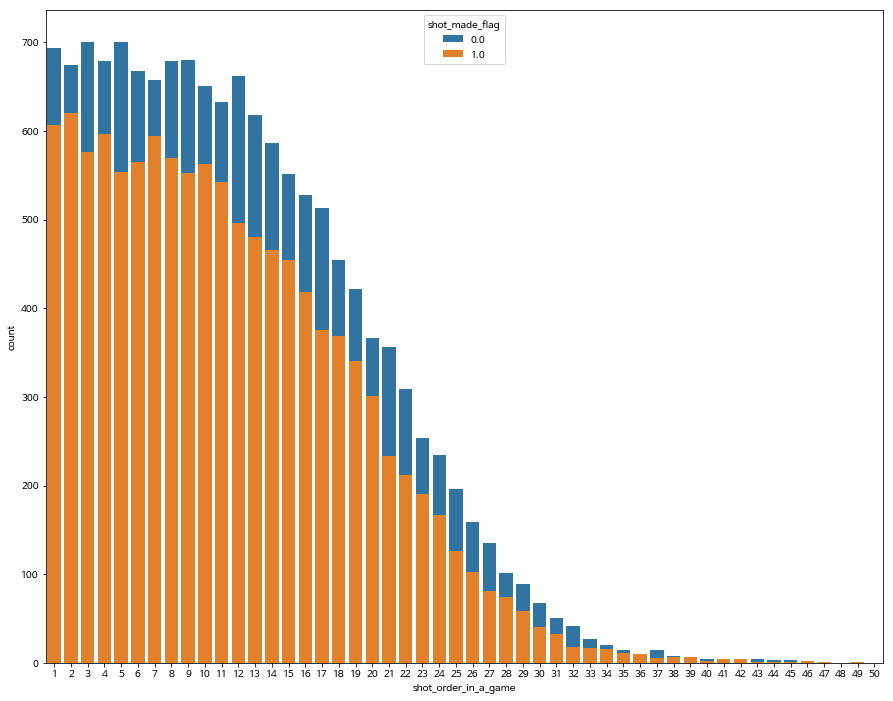

In [18]:
plt.figure(figsize=(15, 12))
sns.countplot(x='shot_order_in_a_game', hue='shot_made_flag', dodge=False, data = data)

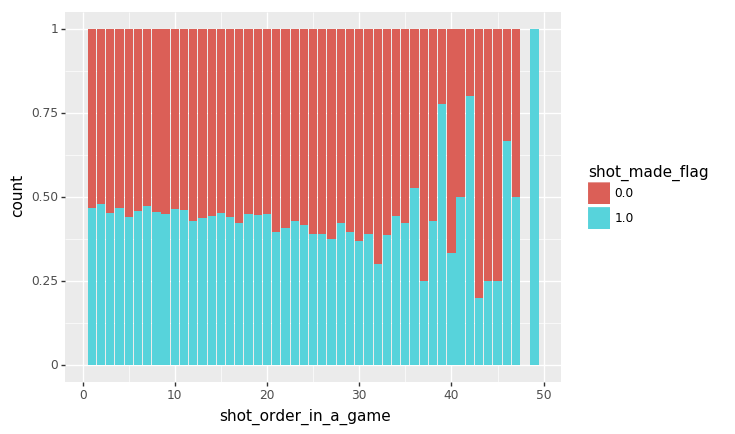

<ggplot: (-9223371938723539340)>

In [19]:
from plotnine import *
data_int = data[data["shot_made_flag"].notnull()].copy()
data_int["shot_made_flag"] = data_int["shot_made_flag"].astype(str)
(
    ggplot(data_int, aes("shot_order_in_a_game", fill = "shot_made_flag")) +
       geom_bar(position = "fill")
) 
# 전반적으로 순서에는 독립적인 것 같다

In [20]:
pd.crosstab(data['shot_order_in_a_game'], data['shot_made_flag'], normalize = 'index').sort_values(by = 1, ascending = False)

shot_made_flag             0.0       1.0
shot_order_in_a_game                    
49                    0.000000  1.000000
42                    0.200000  0.800000
39                    0.222222  0.777778
46                    0.333333  0.666667
36                    0.473684  0.526316
47                    0.500000  0.500000
41                    0.500000  0.500000
2                     0.521236  0.478764
7                     0.525559  0.474441
4                     0.532132  0.467868
1                     0.533436  0.466564
10                    0.536244  0.463756
11                    0.538265  0.461735
6                     0.541768  0.458232
8                     0.543635  0.456365
15                    0.548163  0.451837
3                     0.548589  0.451411
20                    0.549401  0.450599
9                     0.551500  0.448500
18                    0.551640  0.448360
19                    0.553806  0.446194
34                    0.555556  0.444444
14                    0.557455  0.442545
16                    0.558140  0.441860
5                     0.558566  0.441434
13                    0.562842  0.437158
38                    0.571429  0.428571
12                    0.571675  0.428325
23                    0.572072  0.427928
35                    0.576923  0.423077
17                    0.577053  0.422947
28                    0.577143  0.422857
24                    0.584577  0.415423
22                    0.593090  0.406910
21                    0.604414  0.395586
29                    0.605442  0.394558
25                    0.608696  0.391304
26                    0.609195  0.390805
31                    0.609756  0.390244
33                    0.613636  0.386364
27                    0.625000  0.375000
30                    0.629630  0.370370
40                    0.666667  0.333333
32                    0.700000  0.300000
37                    0.750000  0.250000
44                    0.750000  0.250000
45                    0.750000  0.250000
43                    0.800000  0.200000

In [21]:
data['game_date_DT'] = pd.to_datetime(data['game_date'])

In [22]:
yy = pd.DataFrame(data.game_date_DT.dt.year)
yy.columns = ['years']

mm = pd.DataFrame(data.game_date_DT.dt.month)
mm.columns = ['months']
mm.head()

months
0      10
1      10
2      10
3      10
4      10

In [23]:
yy = yy % 100

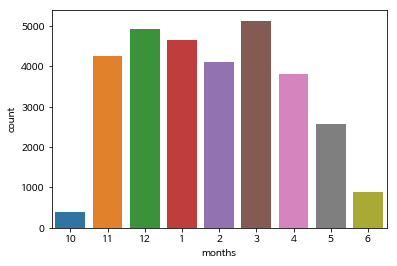

In [24]:
sns.countplot(x='months', data = mm, order = [x for x in range(10, 13)] + [x for x in range(1, 7)])
# 매년 11월 초에 개막해서 팀당 정규시즌 82경기를 뛰고, 이듬해 4월 말 정도부터는 플레이오프에 돌입하여 6월 중순 정도에는 우승 팀이 가려진다
# 5월은 좀 많은것으로 보아 플레이오프 진출은 많이 했고, 파이널도 많이 간 편이다

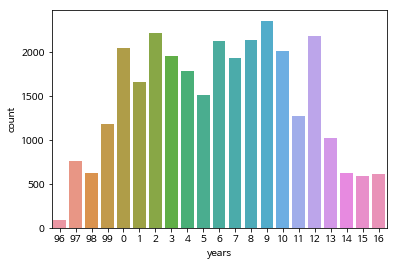

In [25]:
sns.countplot(x='years', data = yy, order = [x for x in range(96,100)] + [x for x in range(0, 17)]) # 96 to 16

In [26]:
data['seconds_from_period_end'] = data['seconds_remaining'] + 60*data['minutes_remaining']
data['seconds_from_period_start'] = 60*(11-data['minutes_remaining'])+(60-data['seconds_remaining'])

In [27]:
data['seconds_from_game_start']   = (data['period'] <= 4).astype(int)*(data['period']-1)*12*60 \
+ (data['period'] > 4).astype(int)*((data['period']-4)*5*60 + 3*12*60) \
+ data['seconds_from_period_start']

In [28]:
data.loc[:6,['period','minutes_remaining','seconds_remaining','seconds_from_game_start']]

period  minutes_remaining  seconds_remaining  seconds_from_game_start
0       1                 10                 27                       93
1       1                 10                 22                       98
2       1                  7                 45                      255
3       1                  6                 52                      308
4       2                  6                 19                     1061
5       3                  9                 32                     1588
6       3                  8                 52                     1628

Text(0.5, 0, '시간 [초]')

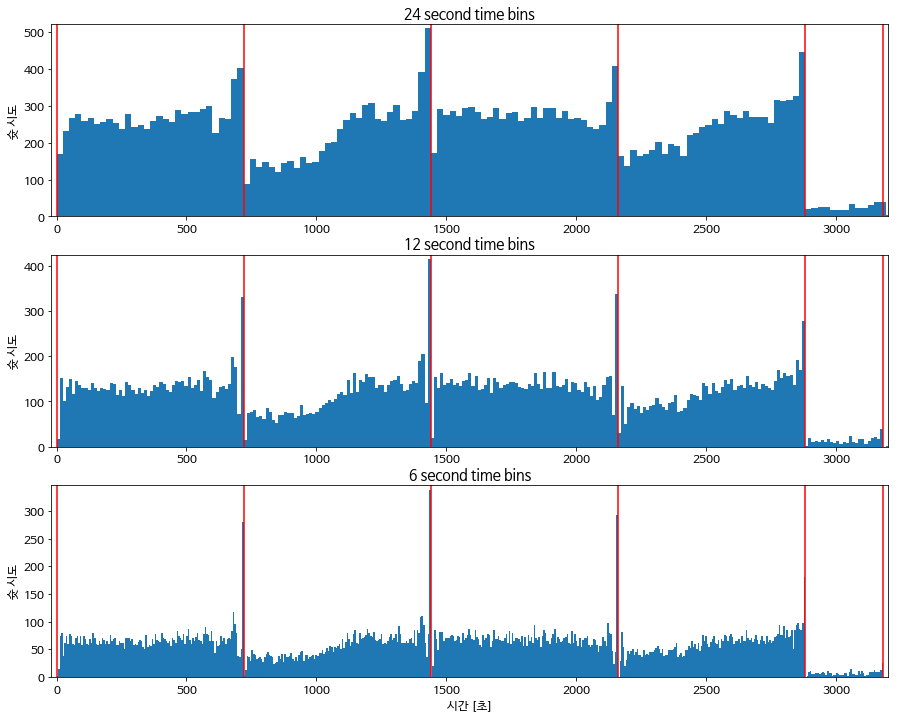

In [29]:
plt.rcParams['font.size'] = 12
bin_size = [24, 12, 6] # bin for hist seconds
plt.figure(figsize = (15, 12))

for i, binLev in enumerate(bin_size):
    times = np.arange(0,60*(4*12+3*5),binLev) + 0.01 # 0부터 60초 * 12분씩 4쿼터 + 연장전 시간 5분 * 대부분 연장 3회 안에 종료
    hist, bn = np.histogram(data['seconds_from_game_start'], bins=times)
    max_height = max(hist) + 10
    bar_width = 0.999*(times[1]-times[0])

    plt.subplot(len(bin_size),1,i+1)
    plt.bar(times[:-1], hist, align='edge', width=bar_width)
    plt.title(str(binLev) + ' second time bins')
    plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0,ymax=max_height, colors='r')
    plt.xlim((-20,3200)); plt.ylim((0, max_height)); plt.ylabel('슛 시도')
plt.xlabel('시간 [초]')

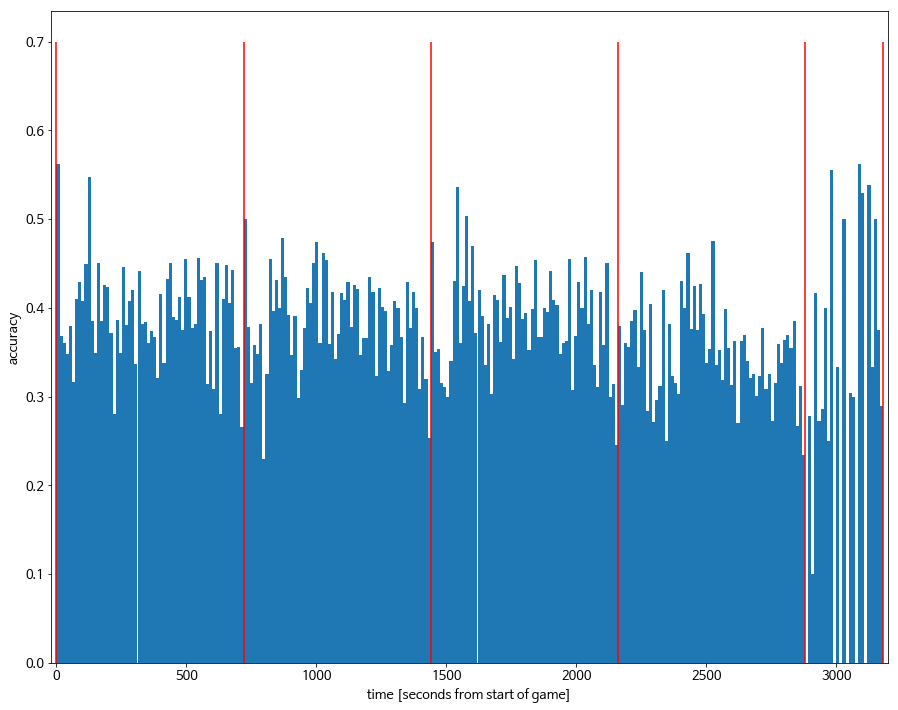

In [307]:
binSizeInSeconds = 12
timeBins = np.arange(0,60*(4*12+3*5),binSizeInSeconds)+0.01
attemptsAsFunctionOfTime,     b = np.histogram(data['seconds_from_game_start'], bins=timeBins)     
madeAttemptsAsFunctionOfTime, b = np.histogram(data.loc[data['shot_made_flag']==1,'seconds_from_game_start'], bins=timeBins)     
attemptsAsFunctionOfTime[attemptsAsFunctionOfTime < 1] = 1
accuracyAsFunctionOfTime = madeAttemptsAsFunctionOfTime.astype(float)/attemptsAsFunctionOfTime
accuracyAsFunctionOfTime[attemptsAsFunctionOfTime <= 8] = 0 # zero accuracy in bins that don't have enough samples

maxHeight = max(attemptsAsFunctionOfTime) + 30
barWidth = 0.999*(timeBins[1]-timeBins[0])

plt.figure(figsize = (15, 12))

plt.bar(timeBins[:-1],accuracyAsFunctionOfTime, align='edge', width=barWidth); 
plt.xlim((-20,3200)); plt.ylabel('accuracy'); plt.xlabel('time [seconds from start of game]')
plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0.0,ymax=0.7, colors='r')

In [535]:
data['quarter'] = np.where((data['seconds_from_game_start']>=0) & (data['seconds_from_game_start']<720), "1st", 
                          np.where((data['seconds_from_game_start']>=720) & (data['seconds_from_game_start']<2*720), "2nd",
                                  np.where((data['seconds_from_game_start']>=2*720) & (data['seconds_from_game_start']<3*720), "3rd",
                                          np.where((data['seconds_from_game_start']>=3*720) & (data['seconds_from_game_start']<4*720), "4th", "5th"))))

In [536]:
data.seconds_from_game_start.quantile([0, 0.25, 0.5, 0.75, 1])

0.00       6.0
0.25     701.0
0.50    1499.0
0.75    2160.0
1.00    3766.0
Name: seconds_from_game_start, dtype: float64

In [537]:
data.quarter.value_counts()

3rd    8323
1st    7903
4th    7329
2nd    6700
5th     442
Name: quarter, dtype: int64

In [372]:
data['buzzer_beater'] = np.where(data['seconds_from_period_end']<6, 1, 0)
data[['seconds_from_period_end', 'buzzer_beater']].head(20)

seconds_from_period_end  buzzer_beater
0                       627              0
1                       622              0
2                       465              0
3                       412              0
4                       379              0
5                       572              0
6                       532              0
7                       485              0
8                       372              0
9                       216              0
10                      116              0
11                      660              0
12                      429              0
13                      164              0
14                       76              0
15                       48              0
16                        1              1
17                      530              0
18                      689              0
19                      646              0

In [30]:
np.histogram(data['seconds_from_game_start']) # 결과가 이런 식으로 나온다

(array([3959, 4264, 2610, 4645, 4380, 3882, 3482, 3221,  228,   26],
       dtype=int64),
 array([   6.,  382.,  758., 1134., 1510., 1886., 2262., 2638., 3014.,
        3390., 3766.]))

In [31]:
data.head().iloc[:, 0:10]

action_type combined_shot_type  game_event_id   game_id      lat  \
0          Jump Shot          Jump Shot             10  20000012  33.9723   
1          Jump Shot          Jump Shot             12  20000012  34.0443   
2          Jump Shot          Jump Shot             35  20000012  33.9093   
3          Jump Shot          Jump Shot             43  20000012  33.8693   
4  Driving Dunk Shot               Dunk            155  20000012  34.0443   

   loc_x  loc_y       lon  minutes_remaining  period  
0    167     72 -118.1028                 10       1  
1   -157      0 -118.4268                 10       1  
2   -101    135 -118.3708                  7       1  
3    138    175 -118.1318                  6       1  
4      0      0 -118.2698                  6       2

In [32]:
data.head().iloc[:, 10:20]

playoffs   season  seconds_remaining  shot_distance  shot_made_flag  \
0         0  2000-01                 27             18             NaN   
1         0  2000-01                 22             15             0.0   
2         0  2000-01                 45             16             1.0   
3         0  2000-01                 52             22             0.0   
4         0  2000-01                 19              0             1.0   

        shot_type         shot_zone_area  shot_zone_basic  shot_zone_range  \
0  2PT Field Goal          Right Side(R)        Mid-Range        16-24 ft.   
1  2PT Field Goal           Left Side(L)        Mid-Range         8-16 ft.   
2  2PT Field Goal   Left Side Center(LC)        Mid-Range        16-24 ft.   
3  2PT Field Goal  Right Side Center(RC)        Mid-Range        16-24 ft.   
4  2PT Field Goal              Center(C)  Restricted Area  Less Than 8 ft.   

    game_date  
0  2000-10-31  
1  2000-10-31  
2  2000-10-31  
3  2000-10-31  
4  2000-10-31

In [33]:
data.head().iloc[:, 20:30]

opponent  shot_id  hometeam  shot_order_in_a_game game_date_DT  \
0      POR        1         0                     1   2000-10-31   
1      POR        2         0                     2   2000-10-31   
2      POR        3         0                     3   2000-10-31   
3      POR        4         0                     4   2000-10-31   
4      POR        5         0                     5   2000-10-31   

   seconds_from_period_end  seconds_from_period_start  seconds_from_game_start  
0                      627                         93                       93  
1                      622                         98                       98  
2                      465                        255                      255  
3                      412                        308                      308  
4                      379                        341                     1061

In [832]:
pd.crosstab(data['season'], data['shot_made_flag']).sort_values(by = 0)

shot_made_flag   0.0  1.0
season                   
2013-14           35   24
1996-97          221  162
2014-15          370  223
1998-99          414  351
1997-98          461  349
2015-16          600  332
2004-05          635  492
1999-00          708  604
2012-13          720  608
2003-04          777  594
2011-12          813  603
2000-01          840  735
2010-11          842  679
2006-07          856  723
2001-02          925  783
2007-08          967  852
2009-10          968  804
2008-09          985  866
2002-03         1044  808
2005-06         1051  873

In [34]:
pd.crosstab(data['combined_shot_type'], data['shot_made_flag'], margins = True).sort_values(by = 1, ascending = False)

shot_made_flag        0.0    1.0    All
combined_shot_type                     
All                 14232  11465  25697
Jump Shot           12002   7708  19710
Layup                1971   2561   4532
Dunk                   76    980   1056
Bank Shot              25     95    120
Hook Shot              59     68    127
Tip Shot               99     53    152

In [35]:
pd.crosstab(data['combined_shot_type'], data['shot_made_flag'], normalize = 'index').sort_values(by = 1, ascending = False)

shot_made_flag           0.0       1.0
combined_shot_type                    
Dunk                0.071970  0.928030
Bank Shot           0.208333  0.791667
Layup               0.434907  0.565093
Hook Shot           0.464567  0.535433
Jump Shot           0.608929  0.391071
Tip Shot            0.651316  0.348684

[Text(0, 0, 'Jump Shot'),
 Text(0, 0, 'Layup Shot'),
 Text(0, 0, 'Driving Layup Shot'),
 Text(0, 0, 'Turnaround Jump Shot'),
 Text(0, 0, 'Fadeaway Jump Shot'),
 Text(0, 0, 'Running Jump Shot'),
 Text(0, 0, 'Pullup Jump shot'),
 Text(0, 0, 'Turnaround Fadeaway shot'),
 Text(0, 0, 'Slam Dunk Shot'),
 Text(0, 0, 'Reverse Layup Shot'),
 Text(0, 0, 'Jump Bank Shot'),
 Text(0, 0, 'Driving Dunk Shot'),
 Text(0, 0, 'Dunk Shot'),
 Text(0, 0, 'Tip Shot'),
 Text(0, 0, 'Alley Oop Dunk Shot'),
 Text(0, 0, 'Step Back Jump shot'),
 Text(0, 0, 'Floating Jump shot'),
 Text(0, 0, 'Driving Reverse Layup Shot'),
 Text(0, 0, 'Hook Shot'),
 Text(0, 0, 'Driving Finger Roll Shot'),
 Text(0, 0, 'Alley Oop Layup shot'),
 Text(0, 0, 'Reverse Dunk Shot'),
 Text(0, 0, 'Running Layup Shot'),
 Text(0, 0, 'Turnaround Bank shot'),
 Text(0, 0, 'Driving Finger Roll Layup Shot'),
 Text(0, 0, 'Driving Slam Dunk Shot'),
 Text(0, 0, 'Running Bank shot'),
 Text(0, 0, 'Running Hook Shot'),
 Text(0, 0, 'Finger Roll Layup Shot'

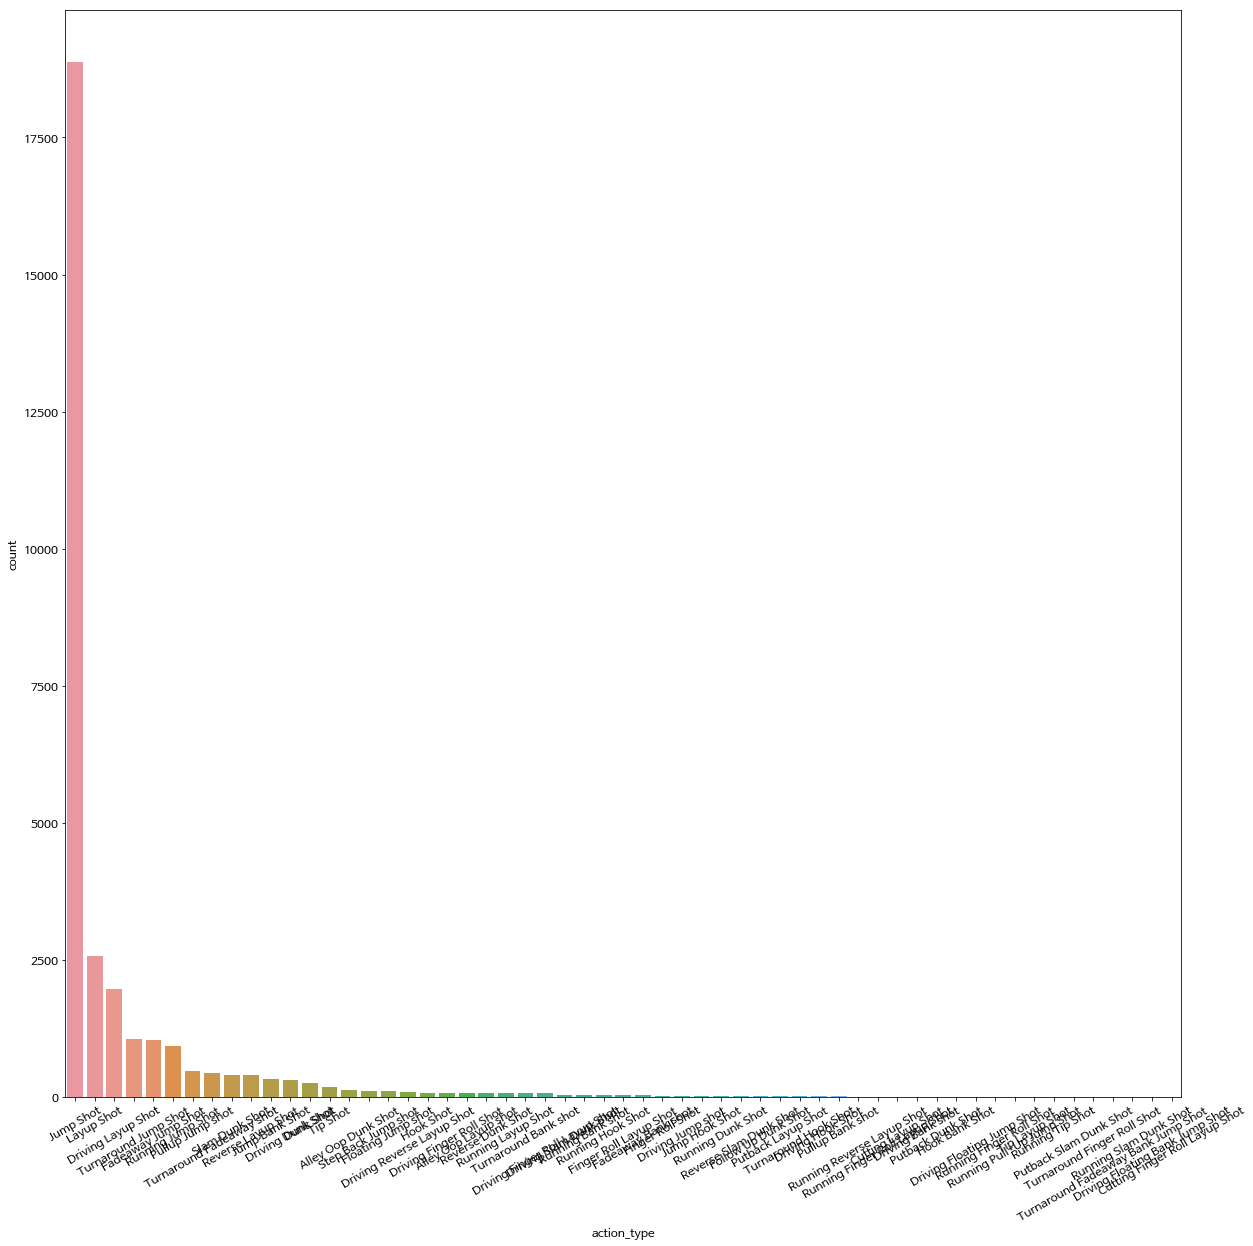

In [36]:
plt.figure(figsize=(20, 20))
g = sns.countplot(x='action_type', data = data, order = data.action_type.value_counts().index, dodge=False)
l = g.get_xticklabels()
g.set_xticklabels(l, rotation=30) # 슛 종류를 줄이자 ex) Dunks, Hook shots, Layups, Bank ...

In [37]:
data['action_type'].value_counts(normalize=True)

Jump Shot                             0.615044
Layup Shot                            0.083624
Driving Layup Shot                    0.064436
Turnaround Jump Shot                  0.034433
Fadeaway Jump Shot                    0.034140
Running Jump Shot                     0.030166
Pullup Jump shot                      0.015506
Turnaround Fadeaway shot              0.014301
Slam Dunk Shot                        0.013389
Reverse Layup Shot                    0.012868
Jump Bank Shot                        0.010848
Driving Dunk Shot                     0.010099
Dunk Shot                             0.008535
Tip Shot                              0.005929
Alley Oop Dunk Shot                   0.003974
Step Back Jump shot                   0.003844
Floating Jump shot                    0.003714
Driving Reverse Layup Shot            0.003160
Hook Shot                             0.002736
Driving Finger Roll Shot              0.002671
Alley Oop Layup shot                  0.002606
Reverse Dunk 

In [38]:
pd.crosstab(data['action_type'], data['shot_made_flag'], normalize='index').sort_values(by = 0)

shot_made_flag                        0.0       1.0
action_type                                        
Reverse Slam Dunk Shot           0.000000  1.000000
Running Slam Dunk Shot           0.000000  1.000000
Hook Bank Shot                   0.000000  1.000000
Turnaround Finger Roll Shot      0.000000  1.000000
Driving Floating Bank Jump Shot  0.000000  1.000000
Slam Dunk Shot                   0.017964  0.982036
Driving Slam Dunk Shot           0.023256  0.976744
Driving Dunk Shot                0.023346  0.976654
Alley Oop Dunk Shot              0.052632  0.947368
Reverse Dunk Shot                0.081967  0.918033
Follow Up Dunk Shot              0.100000  0.900000
Fadeaway Bank shot               0.111111  0.888889
Running Dunk Shot                0.111111  0.888889
Driving Finger Roll Layup Shot   0.118644  0.881356
Running Hook Shot                0.121212  0.878788
Driving Finger Roll Shot         0.147059  0.852941
Running Bank shot                0.162791  0.837209
Finger Roll Layup Shot           0.178571  0.821429
Turnaround Bank shot             0.206897  0.793103
Dunk Shot                        0.221198  0.778802
Jump Bank Shot                   0.224913  0.775087
Running Jump Shot                0.252888  0.747112
Driving Reverse Layup Shot       0.253012  0.746988
Driving Layup Shot               0.258600  0.741400
Jump Hook Shot                   0.263158  0.736842
Pullup Jump shot                 0.276119  0.723881
Floating Jump shot               0.279570  0.720430
Alley Oop Layup shot             0.283582  0.716418
Running Layup Shot               0.294118  0.705882
Driving Bank shot                0.333333  0.666667
Running Pull-Up Jump Shot        0.333333  0.666667
Putback Dunk Shot                0.333333  0.666667
Putback Layup Shot               0.333333  0.666667
Cutting Layup Shot               0.333333  0.666667
Reverse Layup Shot               0.363363  0.636637
Step Back Jump shot              0.367925  0.632075
Driving Hook Shot                0.384615  0.615385
Running Finger Roll Layup Shot   0.400000  0.600000
Turnaround Jump Shot             0.401796  0.598204
Turnaround Fadeaway shot         0.415301  0.584699
Fadeaway Jump Shot               0.425459  0.574541
Running Reverse Layup Shot       0.428571  0.571429
Pullup Bank shot                 0.454545  0.545455
Putback Slam Dunk Shot           0.500000  0.500000
Turnaround Hook Shot             0.500000  0.500000
Tip Layup Shot                   0.500000  0.500000
Finger Roll Shot                 0.538462  0.461538
Driving Jump shot                0.565217  0.434783
Layup Shot                       0.614670  0.385330
Hook Shot                        0.630137  0.369863
Tip Shot                         0.649007  0.350993
Driving Floating Jump Shot       0.666667  0.333333
Jump Shot                        0.673087  0.326913
Running Finger Roll Shot         0.750000  0.250000
Running Tip Shot                 1.000000  0.000000

In [39]:
pd.crosstab(data['action_type'], data['shot_made_flag'], margins = True).sort_values(by = 1, ascending = False)

shot_made_flag                     0.0    1.0    All
action_type                                         
All                              14232  11465  25697
Jump Shot                        10659   5177  15836
Driving Layup Shot                 421   1207   1628
Layup Shot                        1324    830   2154
Running Jump Shot                  197    582    779
Turnaround Jump Shot               358    533    891
Fadeaway Jump Shot                 371    501    872
Slam Dunk Shot                       6    328    334
Pullup Jump shot                   111    291    402
Driving Dunk Shot                    6    251    257
Jump Bank Shot                      65    224    289
Turnaround Fadeaway shot           152    214    366
Reverse Layup Shot                 121    212    333
Dunk Shot                           48    169    217
Alley Oop Dunk Shot                  5     90     95
Floating Jump shot                  26     67     93
Step Back Jump shot                 39     67    106
Driving Reverse Layup Shot          21     62     83
Driving Finger Roll Shot            10     58     68
Reverse Dunk Shot                    5     56     61
Tip Shot                            98     53    151
Driving Finger Roll Layup Shot       7     52     59
Alley Oop Layup shot                19     48     67
Turnaround Bank shot                12     46     58
Driving Slam Dunk Shot               1     42     43
Running Layup Shot                  15     36     51
Running Bank shot                    7     36     43
Running Hook Shot                    4     29     33
Hook Shot                           46     27     73
Fadeaway Bank shot                   3     24     27
Finger Roll Layup Shot               5     23     28
Running Dunk Shot                    2     16     18
Reverse Slam Dunk Shot               0     15     15
Jump Hook Shot                       5     14     19
Finger Roll Shot                    14     12     26
Driving Jump shot                   13     10     23
Follow Up Dunk Shot                  1      9     10
Driving Hook Shot                    5      8     13
Putback Layup Shot                   3      6      9
Pullup Bank shot                     5      6     11
Hook Bank Shot                       0      5      5
Running Reverse Layup Shot           3      4      7
Turnaround Hook Shot                 4      4      8
Cutting Layup Shot                   2      4      6
Running Finger Roll Layup Shot       2      3      5
Running Pull-Up Jump Shot            1      2      3
Driving Bank shot                    1      2      3
Putback Dunk Shot                    1      2      3
Turnaround Finger Roll Shot          0      2      2
Putback Slam Dunk Shot               1      1      2
Running Slam Dunk Shot               0      1      1
Tip Layup Shot                       1      1      2
Driving Floating Bank Jump Shot      0      1      1
Driving Floating Jump Shot           2      1      3
Running Finger Roll Shot             3      1      4
Running Tip Shot                     1      0      1

In [40]:
# dunk shot만 뽑아서 비교
dunks = data[data.action_type.str.contains("Dunk")]
pd.crosstab(dunks['action_type'], dunks['shot_made_flag'], margins = True).sort_values(by = 1, ascending = False)
# Dunk Shot VS. else Dunks

shot_made_flag          0.0  1.0   All
action_type                           
All                      76  980  1056
Slam Dunk Shot            6  328   334
Driving Dunk Shot         6  251   257
Dunk Shot                48  169   217
Alley Oop Dunk Shot       5   90    95
Reverse Dunk Shot         5   56    61
Driving Slam Dunk Shot    1   42    43
Running Dunk Shot         2   16    18
Reverse Slam Dunk Shot    0   15    15
Follow Up Dunk Shot       1    9    10
Putback Dunk Shot         1    2     3
Putback Slam Dunk Shot    1    1     2
Running Slam Dunk Shot    0    1     1

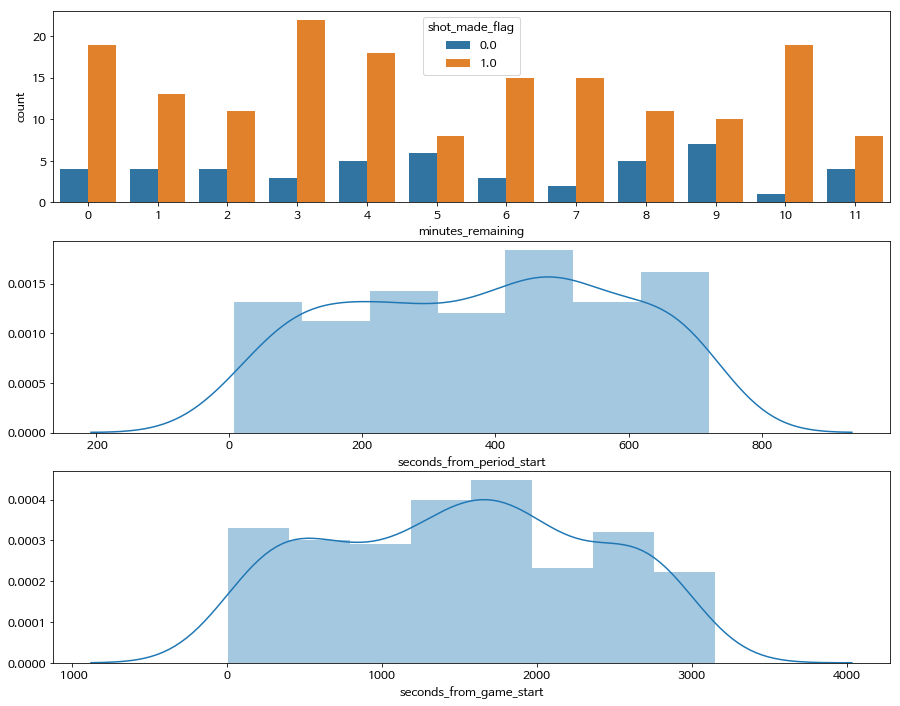

In [41]:
# 왜 그냥 Dunk Shot만 확률이 낮지?
dunkshot = data[data.action_type == 'Dunk Shot']
plt.figure(figsize=(15,12))
plt.subplot(311)
sns.countplot(dunkshot.minutes_remaining, hue = dunkshot.shot_made_flag)
plt.subplot(312)
sns.distplot(dunkshot.seconds_from_period_start)
plt.subplot(313)
sns.distplot(dunkshot.seconds_from_game_start)

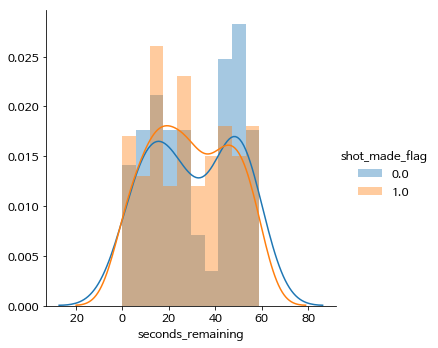

In [42]:
_, bins = np.histogram(dunkshot["seconds_remaining"])
g = sns.FacetGrid(dunkshot, hue = 'shot_made_flag', height = 5)
g.map(sns.distplot, "seconds_remaining", bins = bins).add_legend()

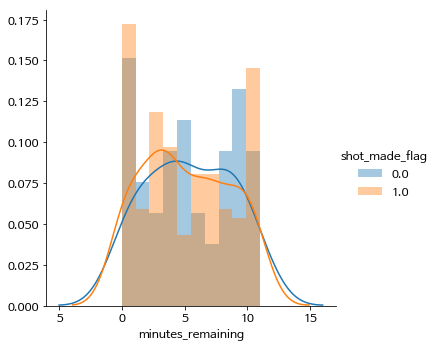

In [43]:
_, bins = np.histogram(dunkshot["minutes_remaining"])
g = sns.FacetGrid(dunkshot, hue = 'shot_made_flag', height = 5)
g.map(sns.distplot, "minutes_remaining", bins = bins).add_legend()

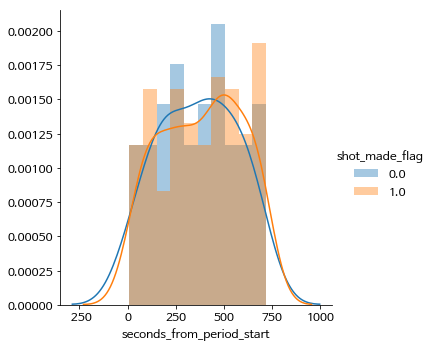

In [44]:
_, bins = np.histogram(dunkshot["seconds_from_period_start"])
g = sns.FacetGrid(dunkshot, hue = 'shot_made_flag', height = 5)
g.map(sns.distplot, "seconds_from_period_start", bins = bins).add_legend()

([<matplotlib.axis.XTick at 0x16d927c9c50>,
 <a list of 9 Text xticklabel objects>)

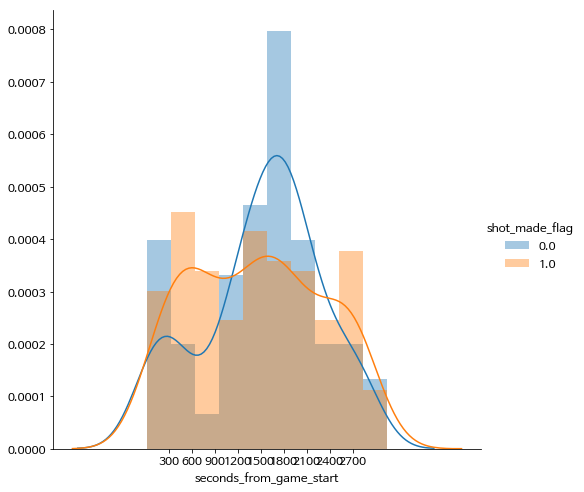

In [45]:
_, bins = np.histogram(dunkshot["seconds_from_game_start"])
g = sns.FacetGrid(dunkshot, hue = 'shot_made_flag', height = 7)
g.map(sns.distplot, "seconds_from_game_start", bins = bins).add_legend() # 3쿼터 후반~4쿼터 초반에 무슨 일이?; 승패 기록 없어 아쉽다
plt.xticks([300*x for x in range(1,10)])

In [46]:
# hothand 아이디어도 재밌겠다(2개 연속까지는 그냥 0으로 치는 법도 가능) # test로 쓰이는 데이터들 때문에 오류 여지가 있다
# condition 덩크나 레이업은 어지간하면 넣으니까 중장거리 위주로 해당 경기 최근 n개 슛으로 슛확률 구해서 컨디션이 어떤지 판가름하면
# hothand 쓰지 못하는 이유를 어느 정도 보완하고 n개가 차기 전에는 0.4 정도로 해서 사전확률을 줄 수도 있다

In [47]:
hooks = data[data['action_type'].str.contains("Hook")]
pd.crosstab(hooks['action_type'], hooks['shot_made_flag'], margins = True).sort_values(by = 1, ascending = False)
# Hook Shot VS. else hooks

shot_made_flag        0.0  1.0  All
action_type                        
All                    64   87  151
Running Hook Shot       4   29   33
Hook Shot              46   27   73
Jump Hook Shot          5   14   19
Driving Hook Shot       5    8   13
Hook Bank Shot          0    5    5
Turnaround Hook Shot    4    4    8

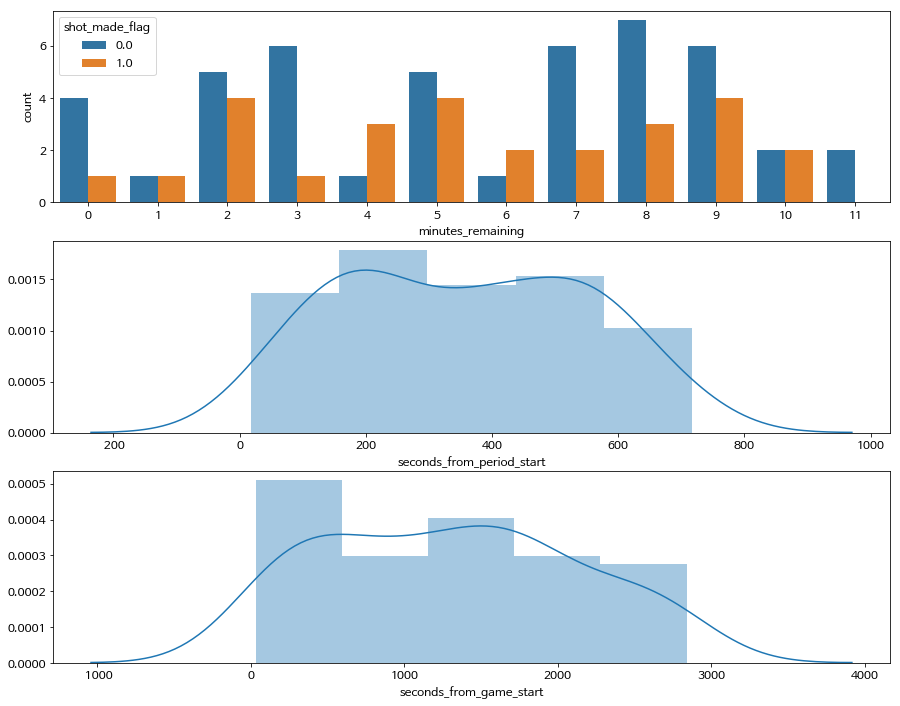

In [48]:
# 왜 그냥 hook shot만 확률이 낮지?
hookshot = data[data.action_type == 'Hook Shot']
plt.figure(figsize=(15,12))
plt.subplot(311)
sns.countplot(hookshot.minutes_remaining, hue = hookshot.shot_made_flag)
plt.subplot(312)
sns.distplot(hookshot.seconds_from_period_start)
plt.subplot(313)
sns.distplot(hookshot.seconds_from_game_start) # hook shot은 경기 초에 더 많이 쓰는 경향이 있다

In [49]:
layups = data[data['action_type'].str.contains("Lay")]
pd.crosstab(layups['action_type'], layups['shot_made_flag'], margins = True).sort_values(by = 1, ascending = False)
# Layup Shot VS. else Layup (차원 커질까봐 핑거롤은 추가 안함)

shot_made_flag                   0.0   1.0   All
action_type                                     
All                             1944  2488  4432
Driving Layup Shot               421  1207  1628
Layup Shot                      1324   830  2154
Reverse Layup Shot               121   212   333
Driving Reverse Layup Shot        21    62    83
Driving Finger Roll Layup Shot     7    52    59
Alley Oop Layup shot              19    48    67
Running Layup Shot                15    36    51
Finger Roll Layup Shot             5    23    28
Putback Layup Shot                 3     6     9
Cutting Layup Shot                 2     4     6
Running Reverse Layup Shot         3     4     7
Running Finger Roll Layup Shot     2     3     5
Tip Layup Shot                     1     1     2

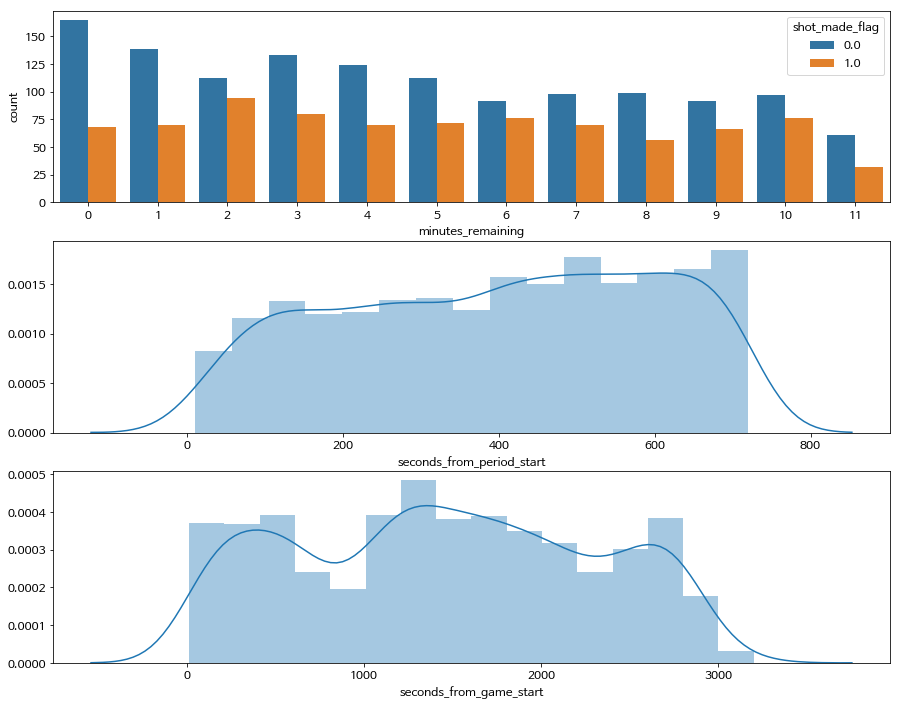

In [50]:
# 왜 그냥 Layup shot만 확률이 낮지?
layup = data[data.action_type == 'Layup Shot']
plt.figure(figsize=(15,12))

plt.subplot(311)
sns.countplot(layup.minutes_remaining, hue = layup.shot_made_flag)
plt.subplot(312)
sns.distplot(layup.seconds_from_period_start)
plt.subplot(313)
sns.distplot(layup.seconds_from_game_start) # hook shot은 경기 초에 더 많이 쓰는 경향이 있다

In [51]:
banks = data[data['action_type'].str.contains("Bank")]
pd.crosstab(banks['action_type'], banks['shot_made_flag'], margins = True).sort_values(by = 1, ascending = False)
# Bank쪽은 전반적으로 확률이 좋다 1:4 정도

shot_made_flag                   0.0  1.0  All
action_type                                   
All                               93  344  437
Jump Bank Shot                    65  224  289
Turnaround Bank shot              12   46   58
Running Bank shot                  7   36   43
Fadeaway Bank shot                 3   24   27
Pullup Bank shot                   5    6   11
Hook Bank Shot                     0    5    5
Driving Bank shot                  1    2    3
Driving Floating Bank Jump Shot    0    1    1

In [52]:
tips = data[data['action_type'].str.contains("Tip")]
pd.crosstab(tips['action_type'], tips['shot_made_flag'], margins = True).sort_values(by = 1, ascending = False)
# Tip Shot은 사실상 하나임. 그리고 확률이 안 좋음

shot_made_flag    0.0  1.0  All
action_type                    
All               100   54  154
Tip Shot           98   53  151
Tip Layup Shot      1    1    2
Running Tip Shot    1    0    1

In [53]:
jumpers = data[data['action_type'].str.contains("Jump")]
pd.crosstab(jumpers['action_type'], jumpers['shot_made_flag'], margins = True).sort_values(by = 1, ascending = False)
# Jump Shot VS. else Jump

shot_made_flag                     0.0   1.0    All
action_type                                        
All                              11847  7470  19317
Jump Shot                        10659  5177  15836
Running Jump Shot                  197   582    779
Turnaround Jump Shot               358   533    891
Fadeaway Jump Shot                 371   501    872
Pullup Jump shot                   111   291    402
Jump Bank Shot                      65   224    289
Floating Jump shot                  26    67     93
Step Back Jump shot                 39    67    106
Jump Hook Shot                       5    14     19
Driving Jump shot                   13    10     23
Running Pull-Up Jump Shot            1     2      3
Driving Floating Bank Jump Shot      0     1      1
Driving Floating Jump Shot           2     1      3

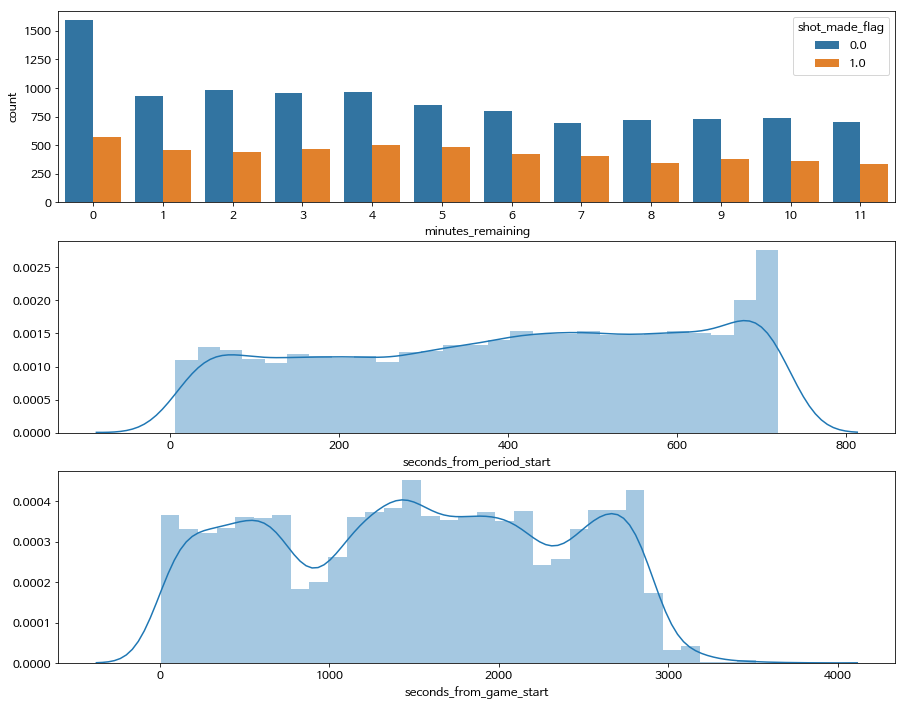

In [54]:
# 왜 그냥 jump shot만 확률이 낮지?
jumpshot = data[data.action_type == 'Jump Shot']
plt.figure(figsize=(15,12))
plt.subplot(311)
sns.countplot(jumpshot.minutes_remaining, hue = jumpshot.shot_made_flag)
plt.subplot(312)
sns.distplot(jumpshot.seconds_from_period_start)
plt.subplot(313)
sns.distplot(jumpshot.seconds_from_game_start) 

In [55]:
fingerRoll = data[data['action_type'].str.contains("Finger")]
pd.crosstab(fingerRoll['action_type'], fingerRoll['shot_made_flag'], margins = True).sort_values(by = 1, ascending = False)
# 다 하나로 쳐도 되겠다

shot_made_flag                  0.0  1.0  All
action_type                                  
All                              41  151  192
Driving Finger Roll Shot         10   58   68
Driving Finger Roll Layup Shot    7   52   59
Finger Roll Layup Shot            5   23   28
Finger Roll Shot                 14   12   26
Running Finger Roll Layup Shot    2    3    5
Turnaround Finger Roll Shot       0    2    2
Running Finger Roll Shot          3    1    4

In [56]:
fadeaway = data[data['action_type'].str.contains("Fadeaway")]
pd.crosstab(fadeaway['action_type'], fadeaway['shot_made_flag'], margins = True).sort_values(by = 1, ascending = False)
# 다 하나로 쳐도 되겠다

shot_made_flag            0.0  1.0   All
action_type                             
All                       526  739  1265
Fadeaway Jump Shot        371  501   872
Turnaround Fadeaway shot  152  214   366
Fadeaway Bank shot          3   24    27

In [57]:
# new action type 
data['shot_class'] = np.where((data['action_type']!="Jump Shot") & (data['action_type'].str.contains("Jump")), "Good Jump Shot",
                             np.where(data['action_type']=="Jump Shot", "Jump Shot", 
                                     np.where((data['action_type']!="Dunk Shot") & (data['action_type'].str.contains("Dunk")), "Good Dunk Shot",
                                             np.where(data['action_type']=="Dunk Shot", "Dunk Shot", 
                                                      np.where((data['action_type']!="Hook Shot") & (data['action_type'].str.contains("Hook")), "Good Hook Shot",
                                                               np.where(data['action_type']=="Hook Shot", "Hook Shot",  
                                                                       np.where((data['action_type']!="Layup Shot") & (data['action_type'].str.contains("Layup")), "Good Layup Shot",
                                                                                np.where(data['action_type']=="Layup Shot", "Layup Shot", 
                                                                                        np.where(data['action_type'].str.contains("Bank"), "Bank Shot", 
                                                                                                np.where(data['action_type'].str.contains("Tip"), "Tip Shot", 
                                                                                                         np.where(data['action_type'].str.contains("Finger"), "Finger Roll",
                                                                                                                  np.where(data['action_type'].str.contains("Fadeaway"), "Fadeaway Shot",
                                                                                                                           "Not named"))))))))))))
data['shot_class'].value_counts()

Jump Shot          18880
Good Jump Shot      4135
Good Layup Shot     2765
Layup Shot          2567
Good Dunk Shot      1024
Fadeaway Shot        439
Dunk Shot            262
Tip Shot             184
Bank Shot            167
Finger Roll          116
Hook Shot             84
Good Hook Shot        74
Name: shot_class, dtype: int64

In [58]:
data[data.shot_class == "Not named"] # no not named finally

Empty DataFrame
Columns: [action_type, combined_shot_type, game_event_id, game_id, lat, loc_x, loc_y, lon, minutes_remaining, period, playoffs, season, seconds_remaining, shot_distance, shot_made_flag, shot_type, shot_zone_area, shot_zone_basic, shot_zone_range, game_date, opponent, shot_id, hometeam, shot_order_in_a_game, game_date_DT, seconds_from_period_end, seconds_from_period_start, seconds_from_game_start, shot_class]
Index: []

[0 rows x 29 columns]

In [59]:
data.columns

Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'game_date', 'opponent', 'shot_id', 'hometeam', 'shot_order_in_a_game',
       'game_date_DT', 'seconds_from_period_end', 'seconds_from_period_start',
       'seconds_from_game_start', 'shot_class'],
      dtype='object')

## from https://www.kaggle.com/bbx396/kobechart
## from https://www.kaggle.com/hyunheo/psychology-of-a-professional-athlete?scriptVersionId=10211154

(-100, 500)

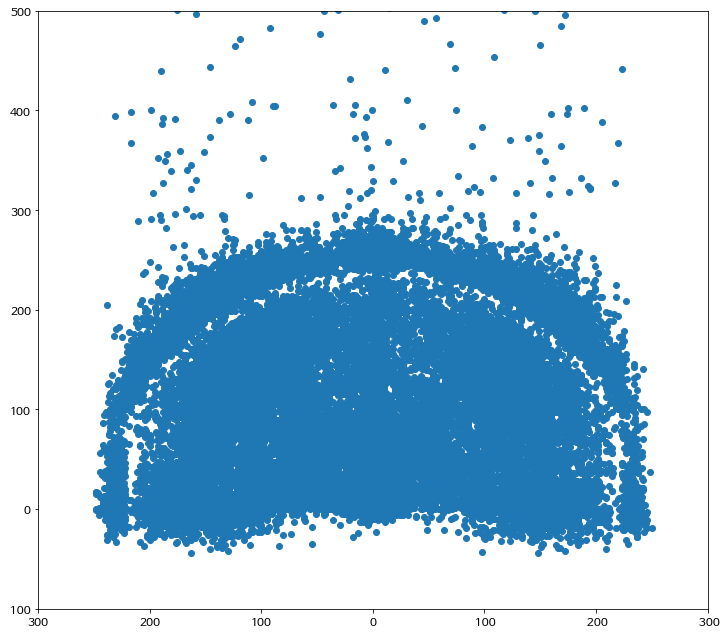

In [60]:
plt.figure(figsize = (12,11))
plt.scatter(data.loc_x, data.loc_y)
plt.xlim(300,-300)
plt.ylim(-100,500)

In [61]:
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

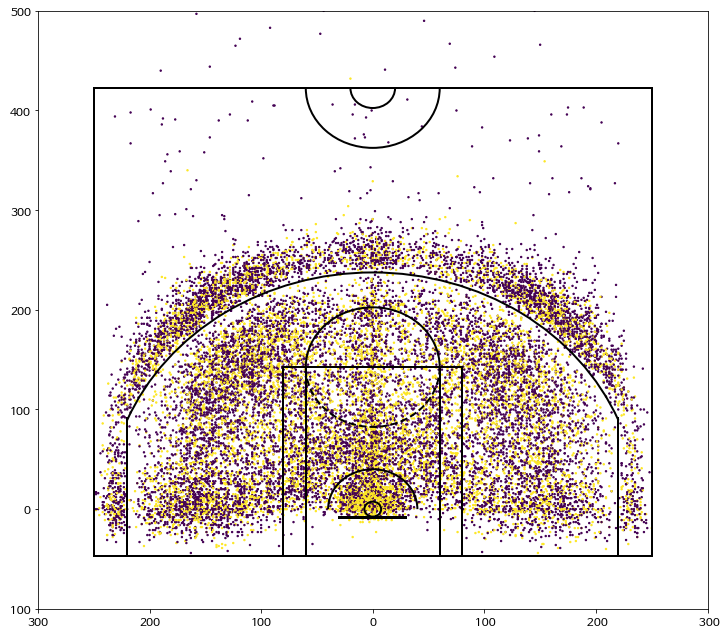

In [62]:
plt.figure(figsize=(12,11))
plt.scatter(data['loc_x'],data['loc_y'], c = data['shot_made_flag'], s=2)
draw_court(outer_lines=True)
plt.ylim(-100,500) # actually there are many shots before half line which are meaningless
plt.xlim(300,-300)
plt.show()

In [63]:
def Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages):
    
    fig, h = plt.subplots();
    for i, (mean, covarianceMatrix) in enumerate(zip(gaussianMixtureModel.means_, gaussianMixtureModel.covariances_)):
        # get the eigen vectors and eigen values of the covariance matrix
        v, w = np.linalg.eigh(covarianceMatrix)
        v = 2.5*np.sqrt(v) # go to units of standard deviation instead of variance
        
        # calculate the ellipse angle and two axis length and draw it
        u = w[0] / np.linalg.norm(w[0])    
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        currEllipse = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=ellipseColors[i])
        currEllipse.set_alpha(0.5)
        h.add_artist(currEllipse)
        h.text(mean[0]+7, mean[1]-1, ellipseTextMessages[i], fontsize=13, color='blue')

In [64]:
numGaussians = 13
gaussianMixtureModel = mixture.GaussianMixture(n_components=numGaussians, covariance_type='full', 
                                               init_params='kmeans', n_init=50, 
                                               verbose=0, random_state=5)
gaussianMixtureModel.fit(data.loc[:,['loc_x','loc_y']])

# add the GMM cluster as a field in the dataset
data['shotLocationCluster'] = gaussianMixtureModel.predict(data.loc[:,['loc_x','loc_y']])

Text(0.5, 1.0, 'shot attempts')

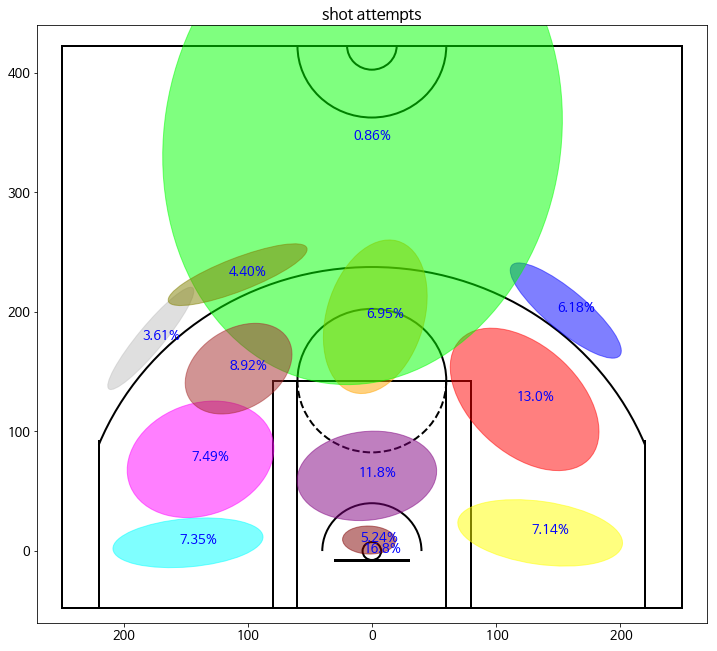

In [65]:
plt.rcParams['figure.figsize'] = (12, 11)
plt.rcParams['font.size'] = 13

ellipseTextMessages = [str(100*gaussianMixtureModel.weights_[x])[:4]+'%' for x in range(numGaussians)]
ellipseColors = ['red','green','purple','cyan','magenta','yellow','blue','orange','silver','maroon','lime','olive','brown','darkblue']
Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)
draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270); plt.title('shot attempts')

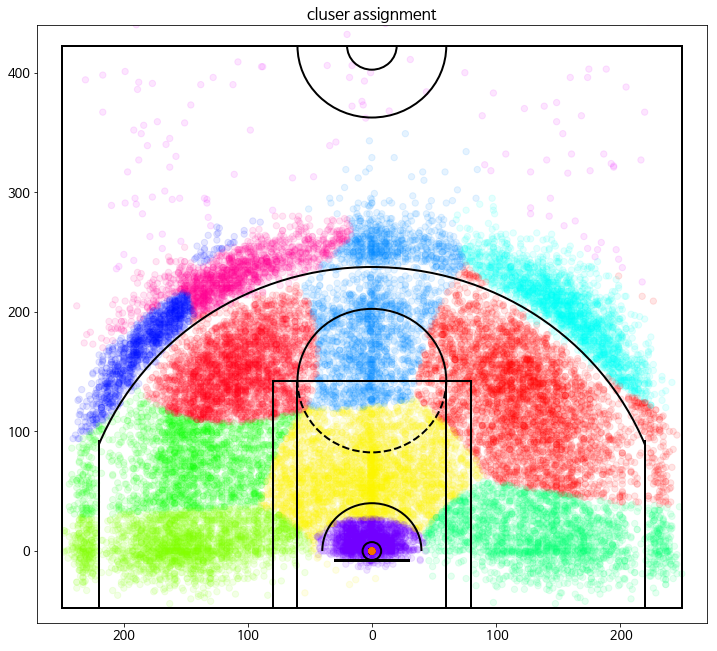

In [66]:
plt.figure(); draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270); plt.title('cluser assignment')
plt.scatter(x=data['loc_x'],y=data['loc_y'],c=data['shotLocationCluster'],s=40,cmap='hsv',alpha=0.1)

Text(0.5, 1.0, 'shot accuracy')

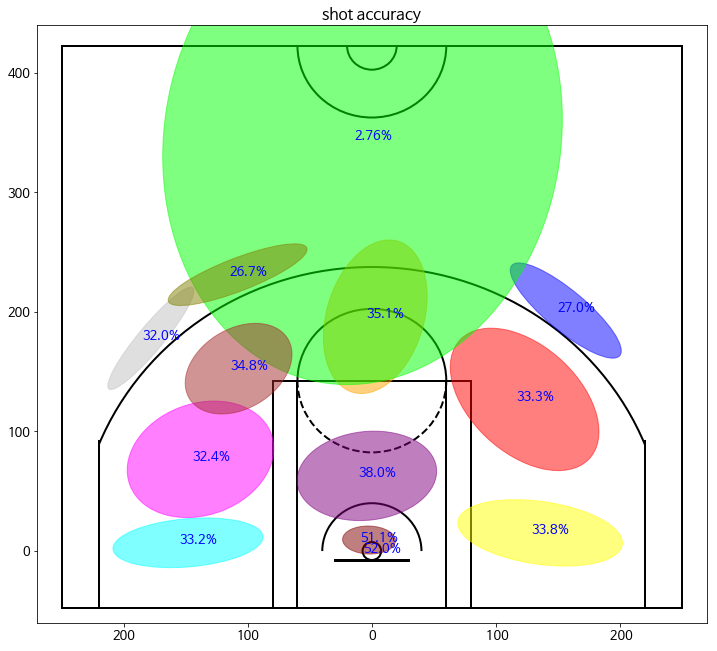

In [67]:
variableCategories = data['shotLocationCluster'].value_counts().index.tolist()

clusterAccuracy = {}
for category in variableCategories:
    shotsAttempted = np.array(data['shotLocationCluster'] == category).sum()
    shotsMade = np.array(data.loc[data['shotLocationCluster'] == category,'shot_made_flag'] == 1).sum()
    clusterAccuracy[category] = float(shotsMade)/shotsAttempted

ellipseTextMessages = [str(100*clusterAccuracy[x])[:4]+'%' for x in range(numGaussians)]
Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)
draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270); plt.title('shot accuracy')

In [68]:
def attemptsGaussian(data, numGaussians = 13, option = "attempts", about_play_offs = False):
    data = data.reset_index()
    ellipseColors = ['red','green','purple','cyan','magenta','yellow','blue','orange','silver','maroon','lime','olive','brown','darkblue']

    gaussianMixtureModel = mixture.GaussianMixture(n_components=numGaussians, covariance_type='full', 
                                               init_params='kmeans', n_init=50, 
                                               verbose=0, random_state=5)
    gaussianMixtureModel.fit(data.loc[:,['loc_x','loc_y']])
    
    # add the GMM cluster as a field in the dataset
    data['shotLocationCluster'] = gaussianMixtureModel.predict(data.loc[:,['loc_x','loc_y']])
    
    if option == "attempts":
        ellipseTextMessages = [str(100*gaussianMixtureModel.weights_[x])[:4]+'%' for x in range(numGaussians)]
    elif option == "accuracy":
        variableCategories = data['shotLocationCluster'].value_counts().index.tolist()

        clusterAccuracy = {}
        for category in variableCategories:
            shotsAttempted = np.array(data['shotLocationCluster'] == category).sum()
            shotsMade = np.array(data.loc[data['shotLocationCluster'] == category,'shot_made_flag'] == 1).sum()
            clusterAccuracy[category] = float(shotsMade)/shotsAttempted

        ellipseTextMessages = [str(100*clusterAccuracy[x])[:4]+'%' for x in range(numGaussians)]
            
    Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)
    draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270)
    season=data["season"][1]
    if about_play_offs:
        if data["playoffs"][1] == 1:
            season = "playoff"
        else:
            season = "not playoff"
    plt.title("shot {} {}".format(option, season))

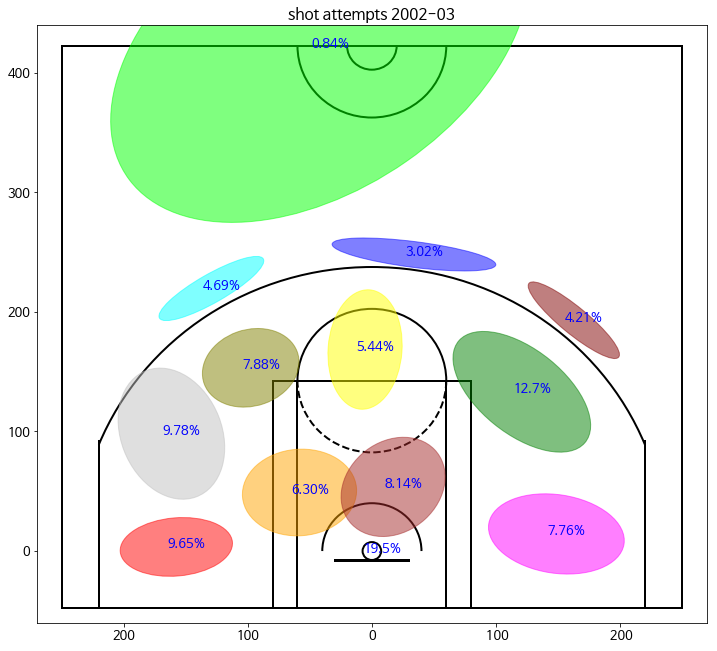

In [69]:
attemptsGaussian(data[data["season"]=='2002-03'].copy())

In [70]:
seasons = ['1996-97', '1997-98', '1998-99', '1999-00', '2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06',
       '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16']
print(seasons)

['1996-97', '1997-98', '1998-99', '1999-00', '2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16']


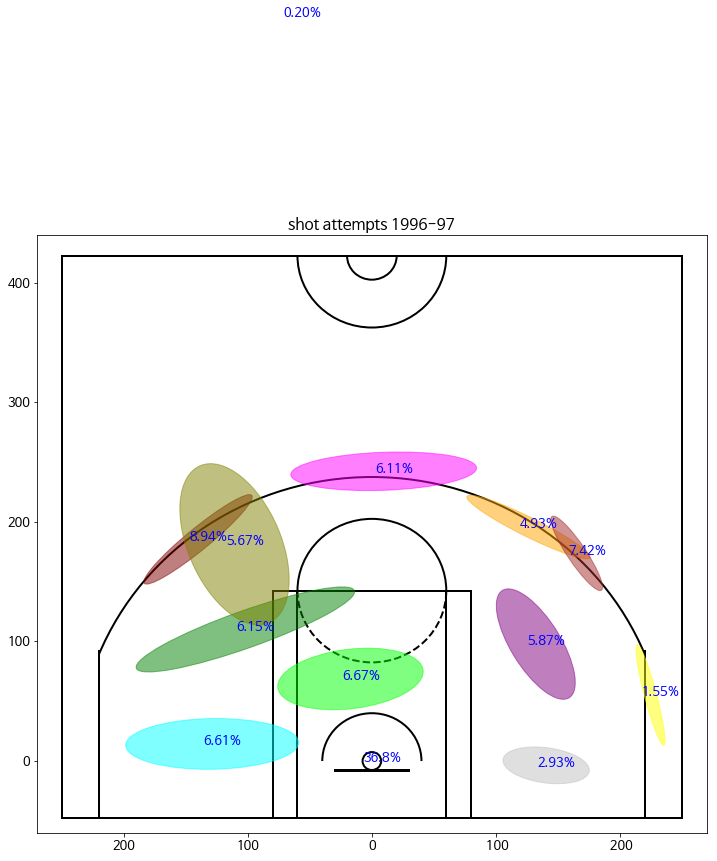

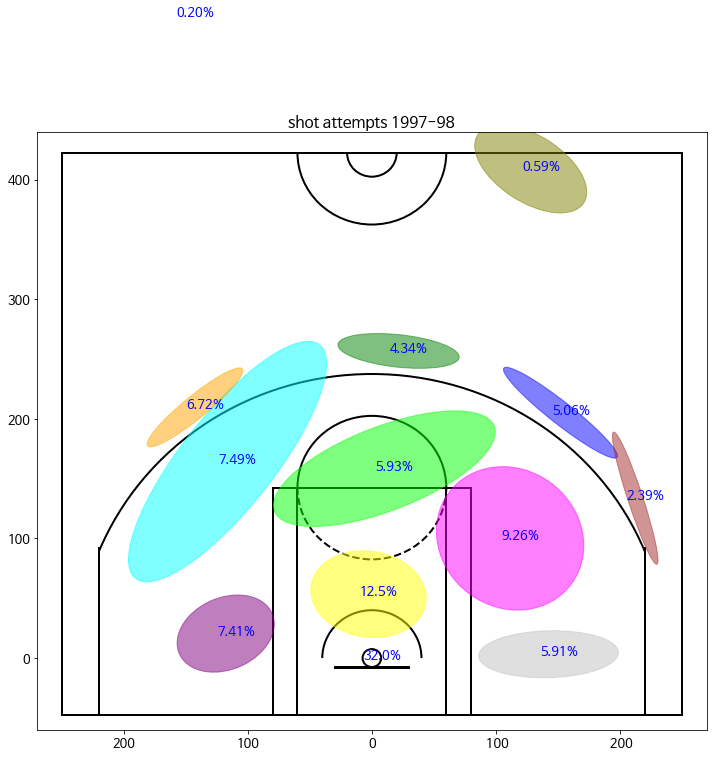

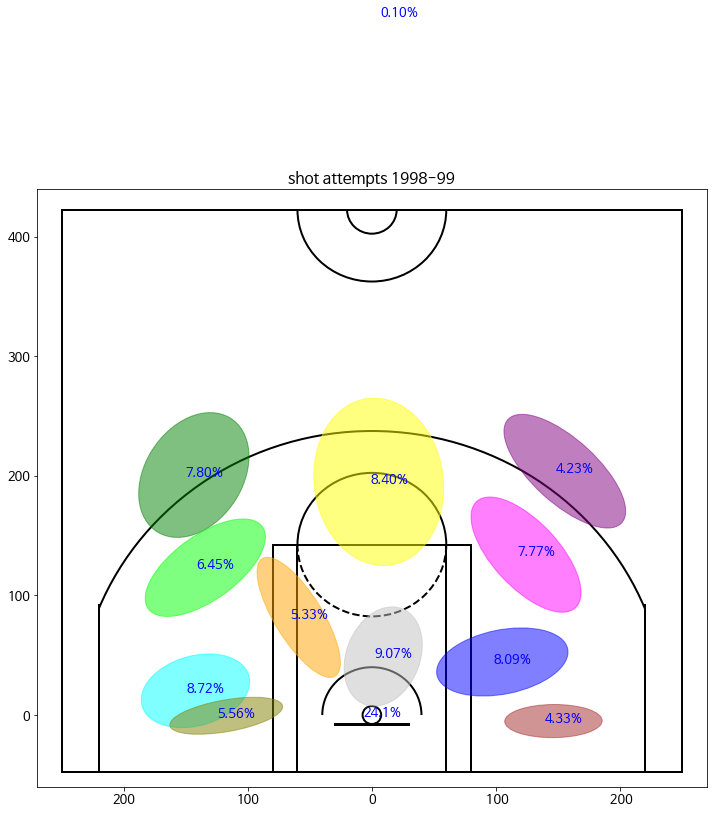

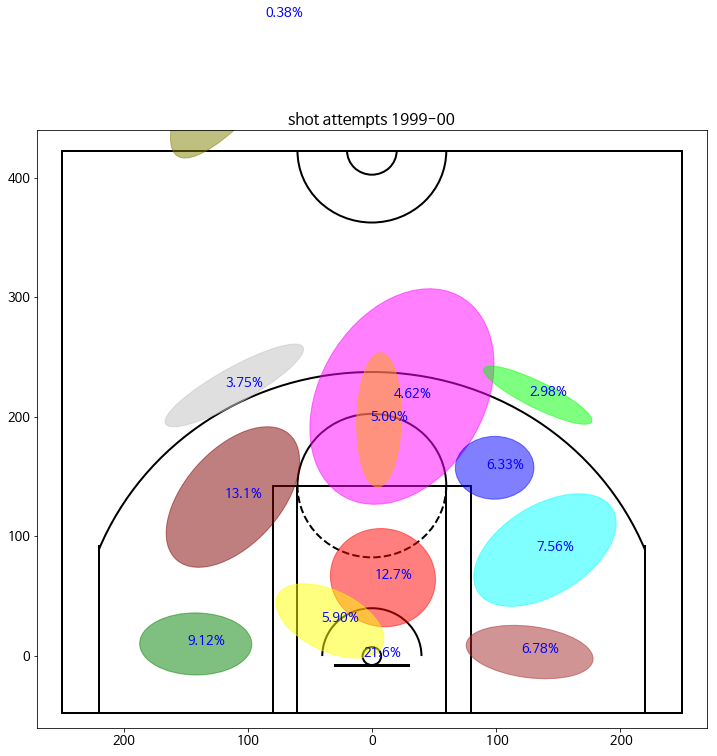

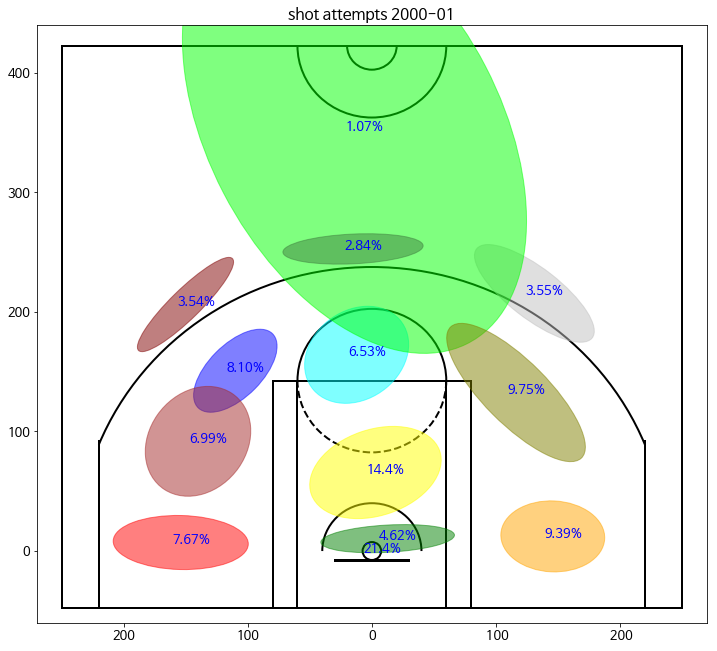

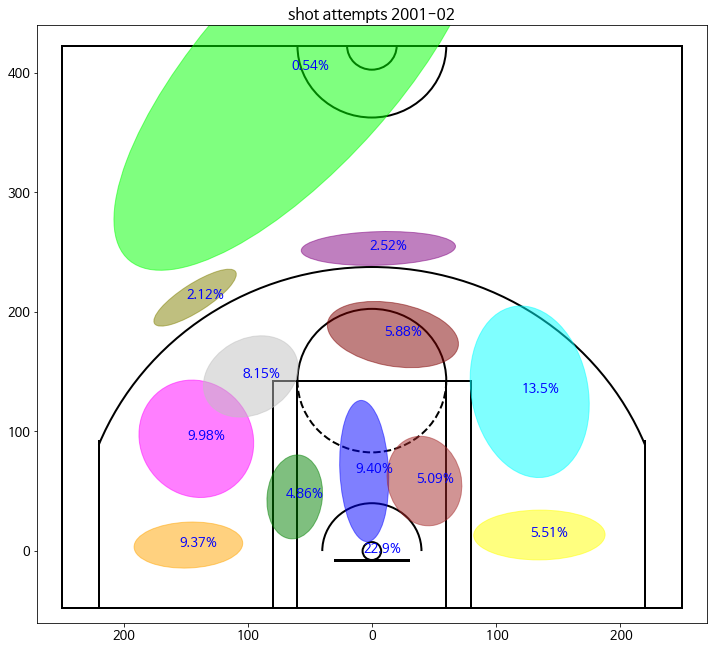

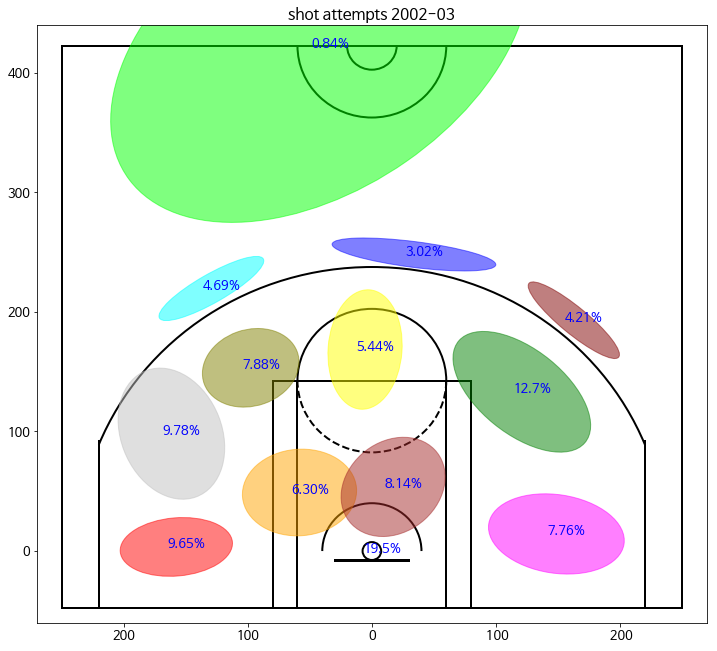

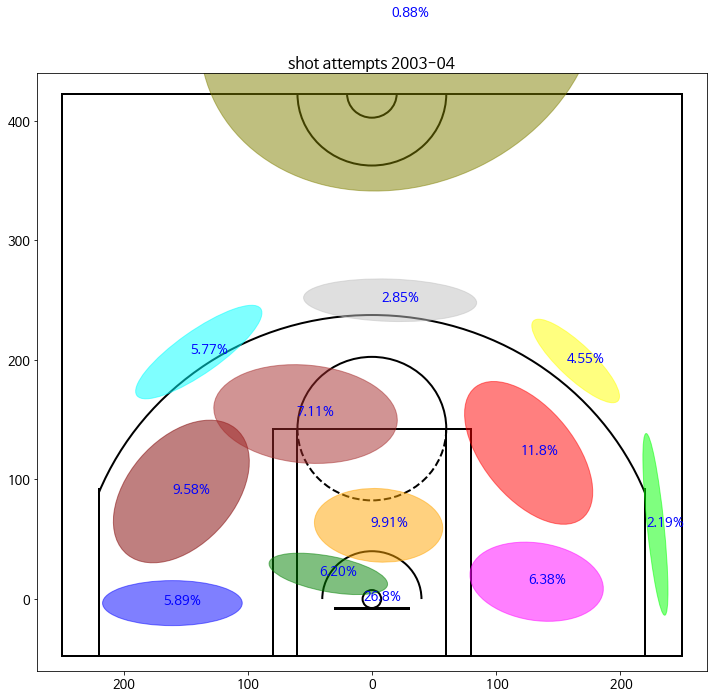

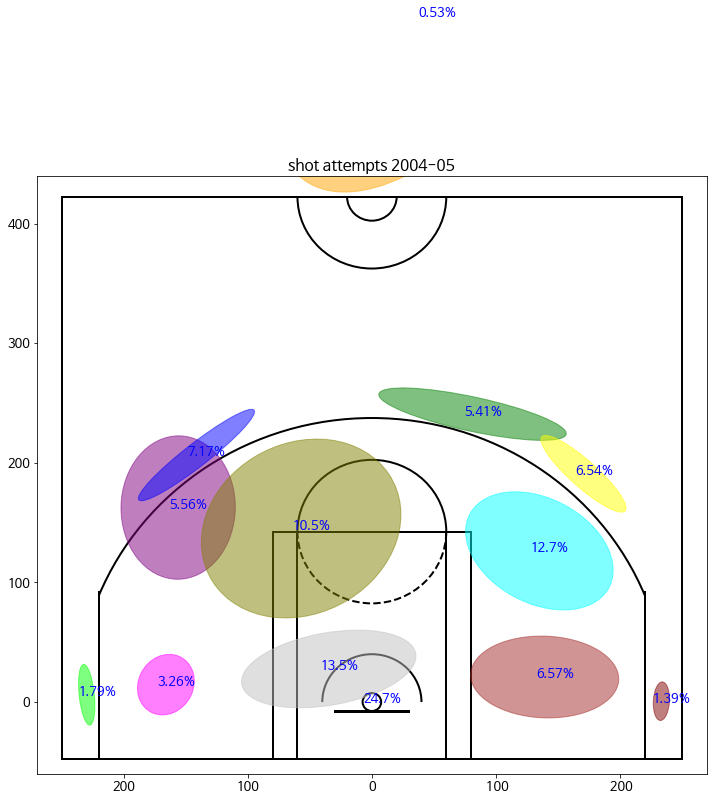

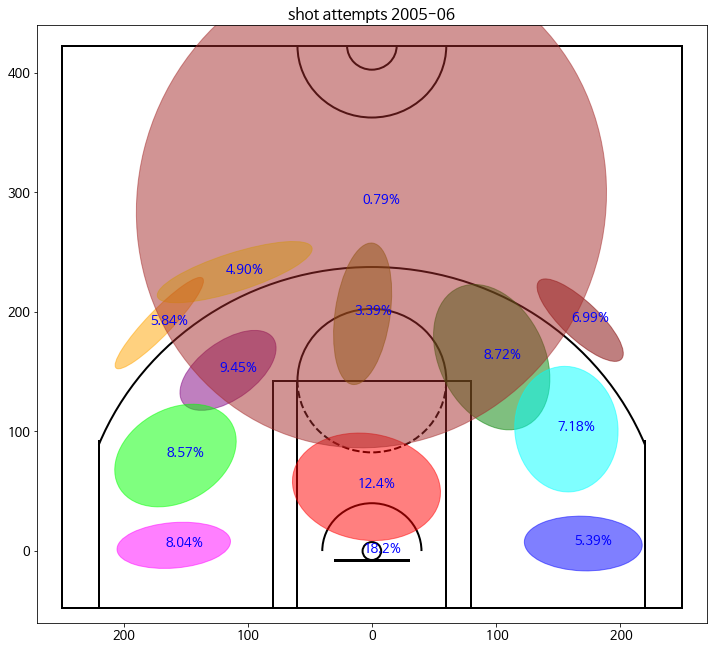

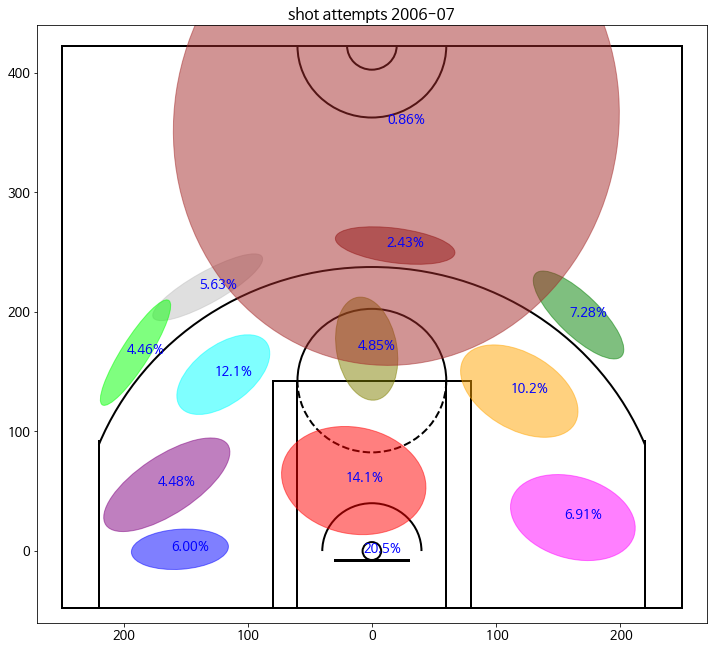

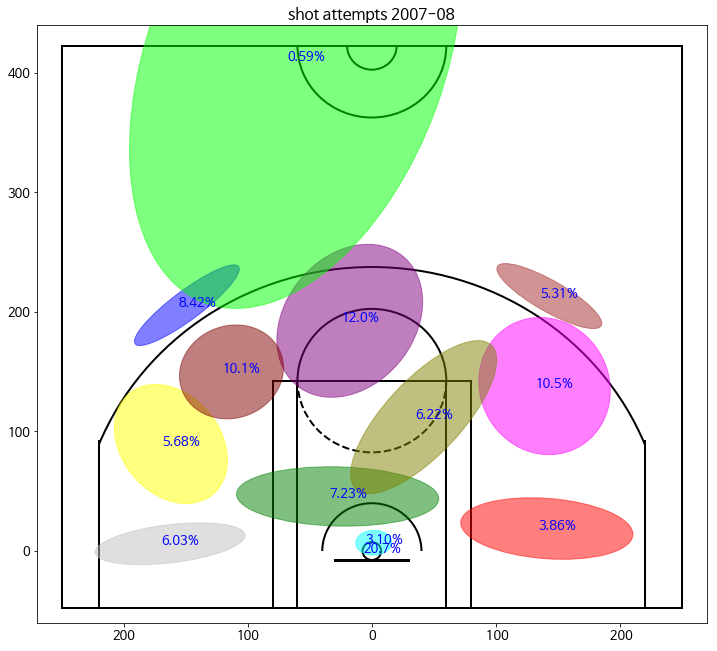

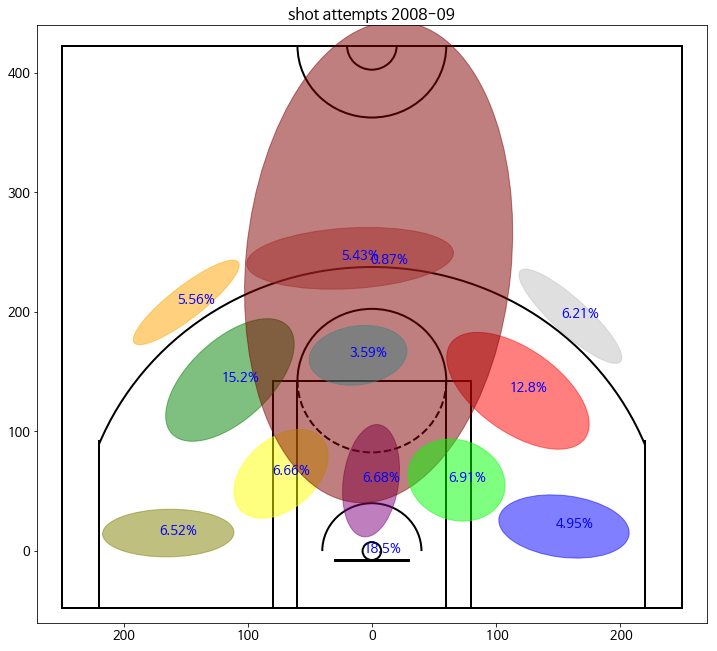

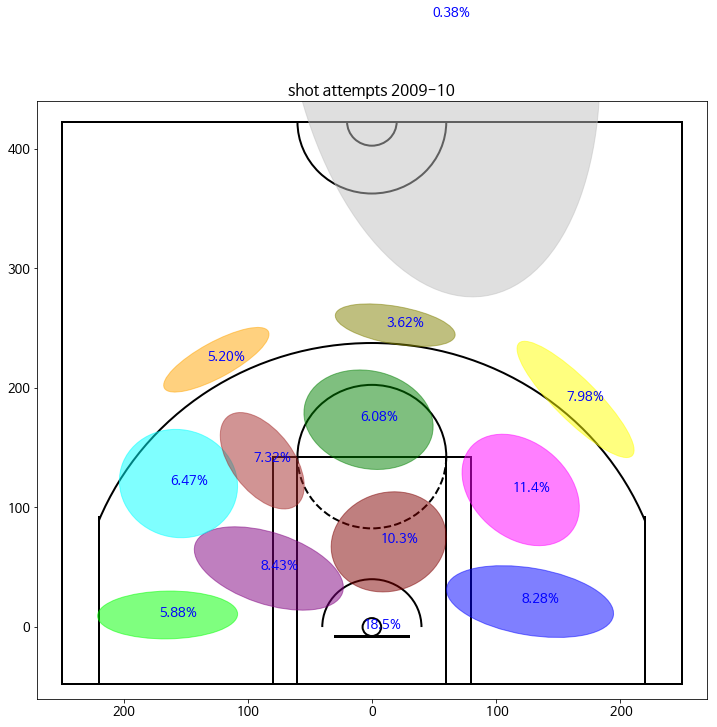

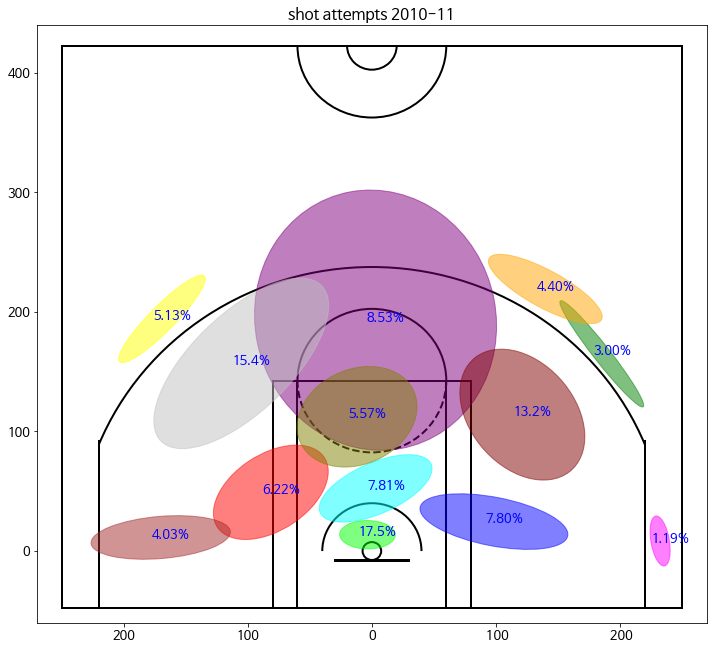

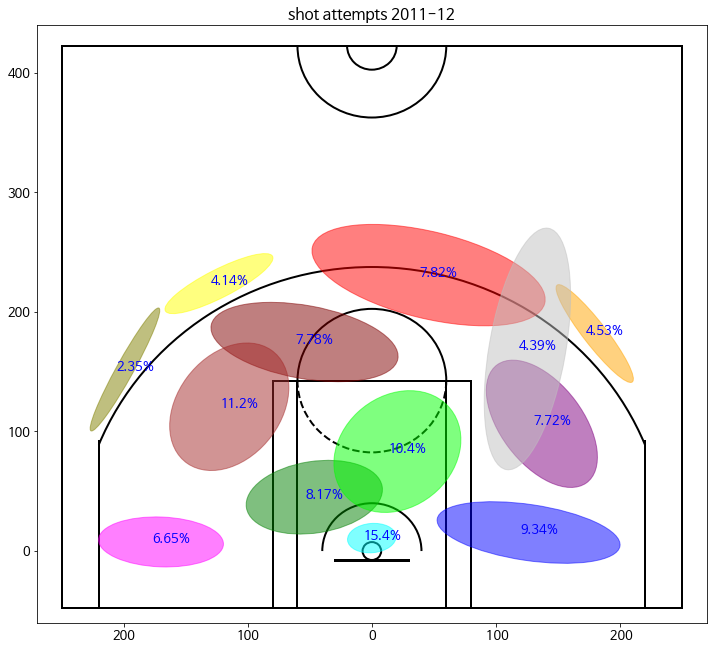

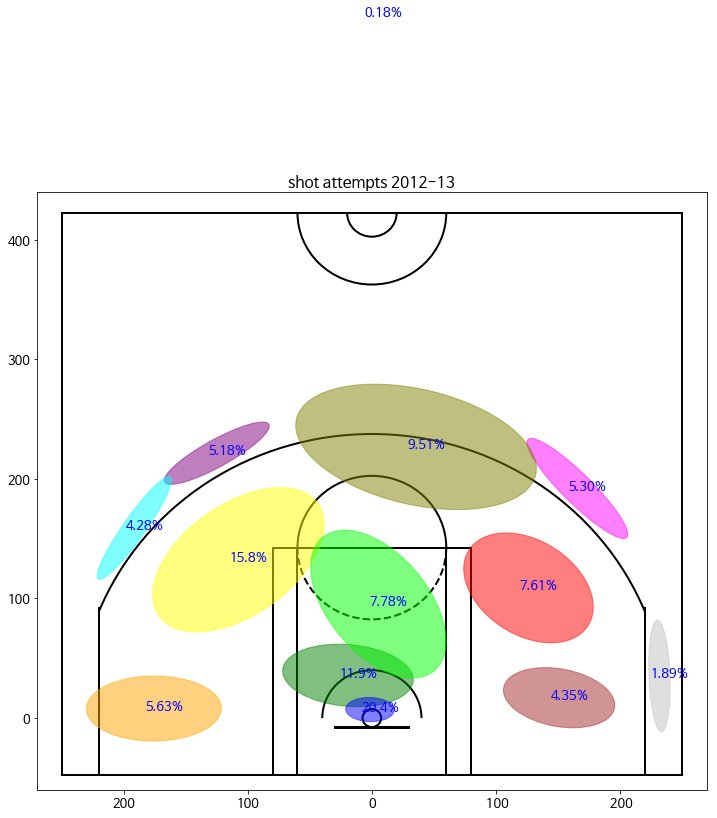

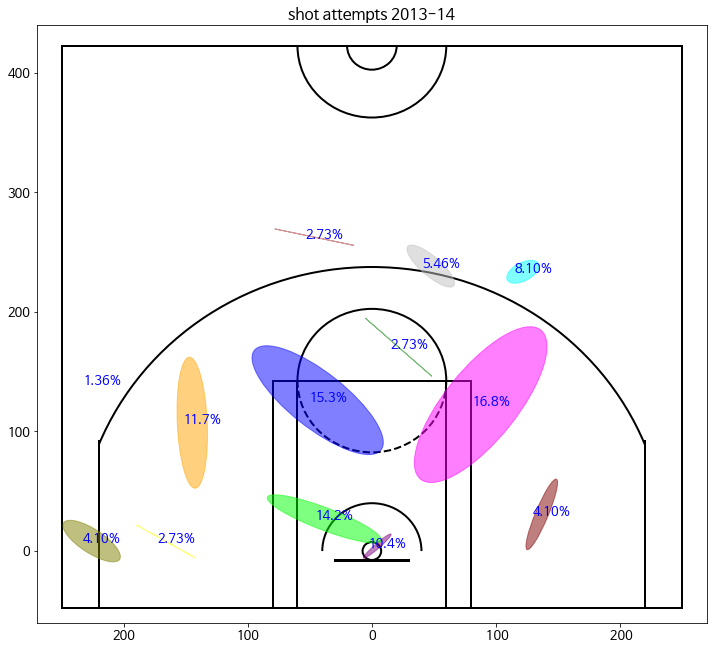

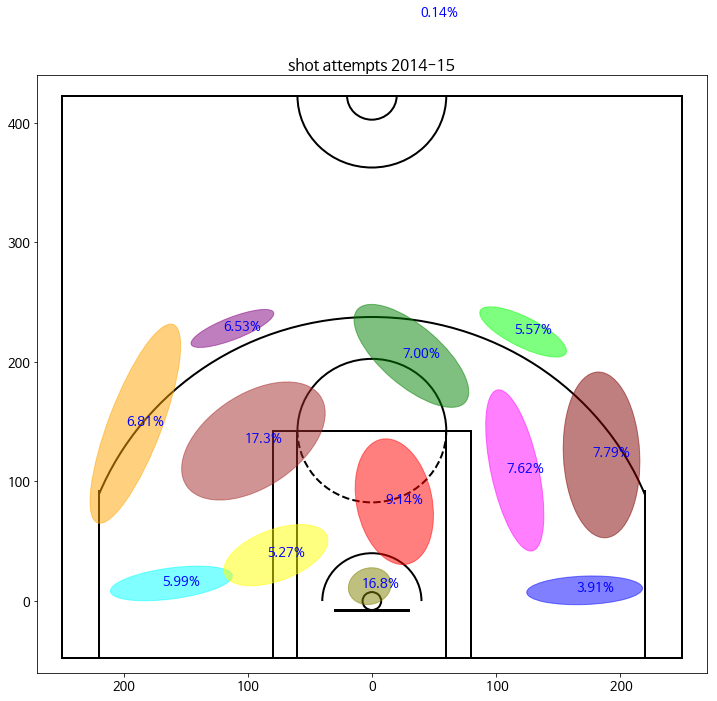

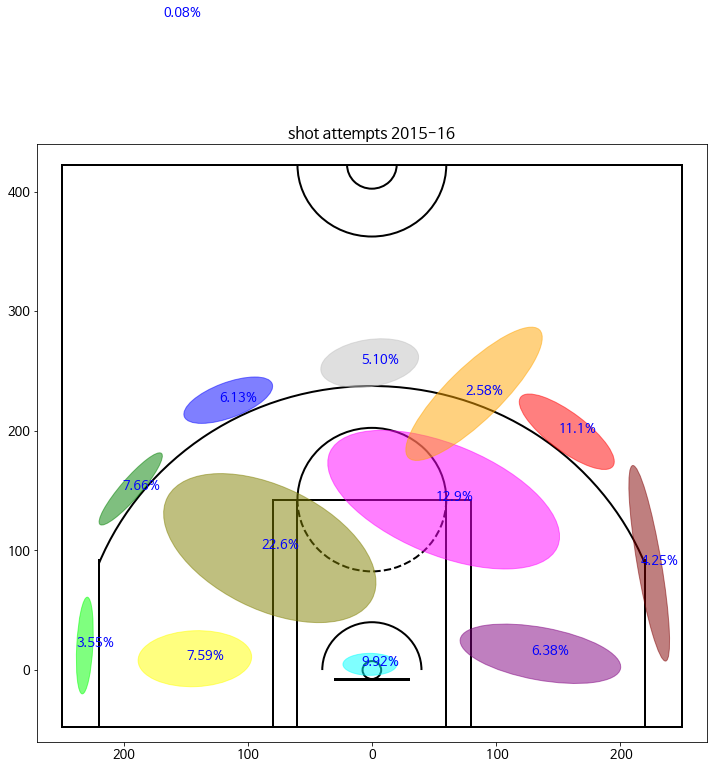

In [71]:
for s in seasons:
    attemptsGaussian(data[data["season"]==s].copy())

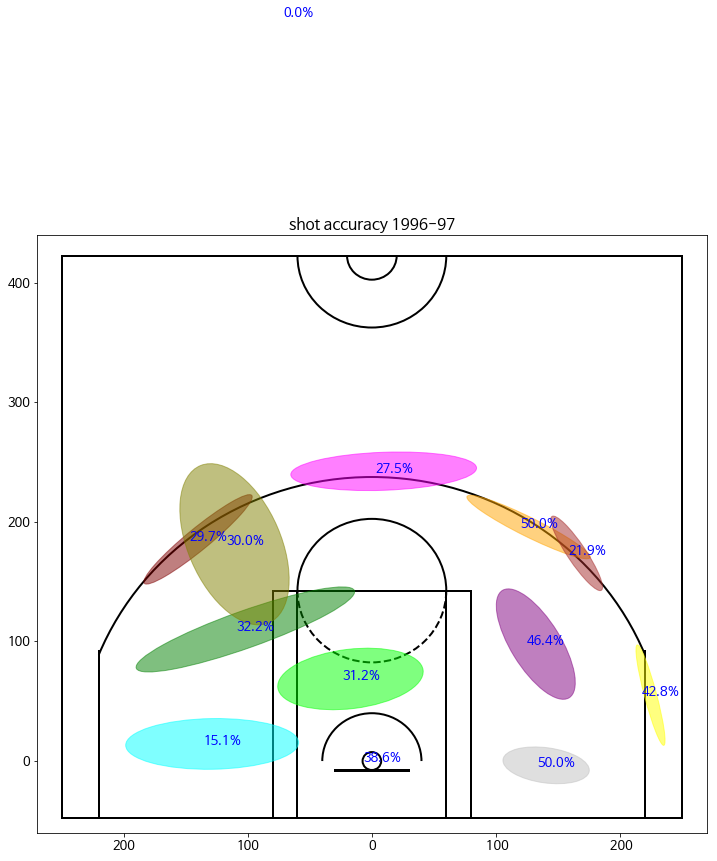

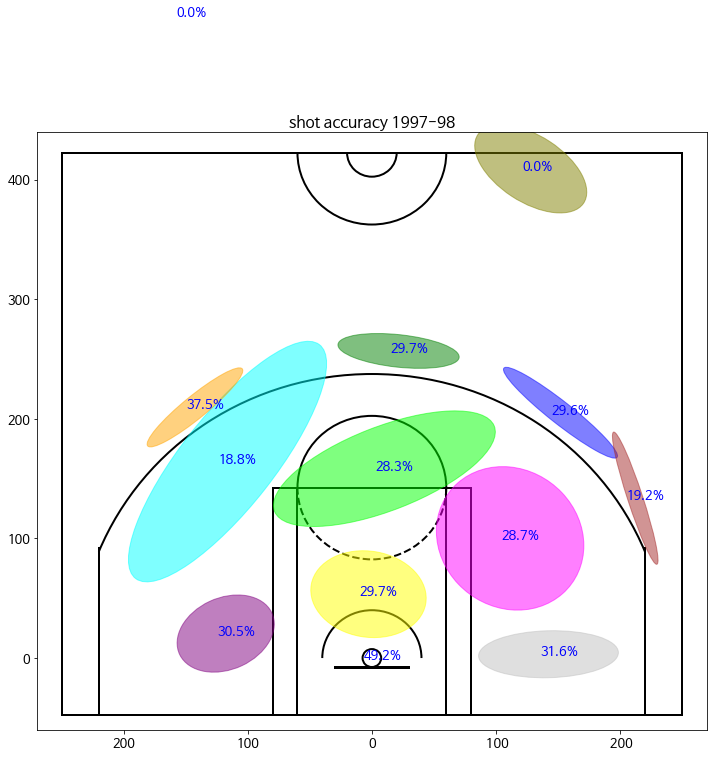

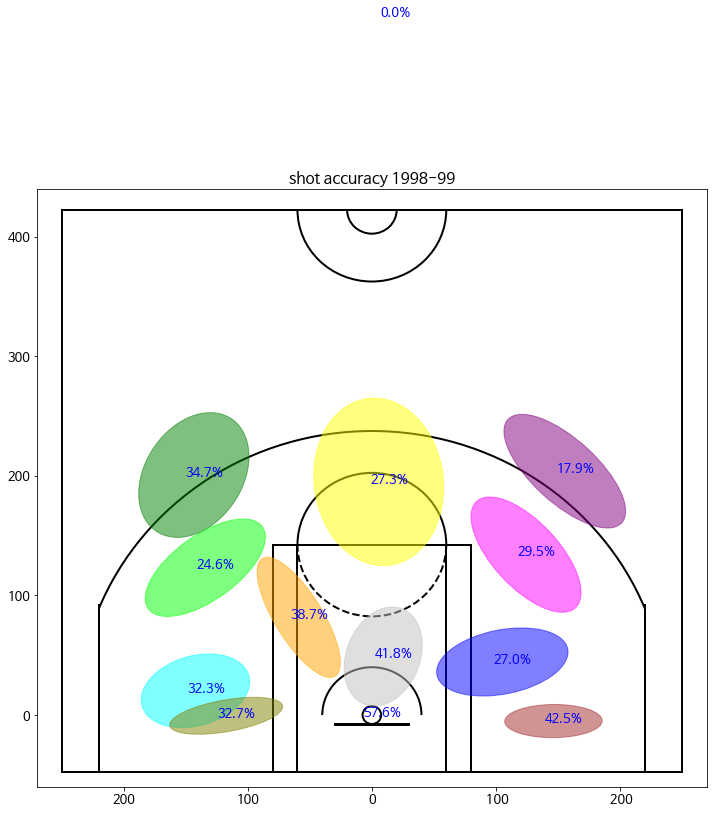

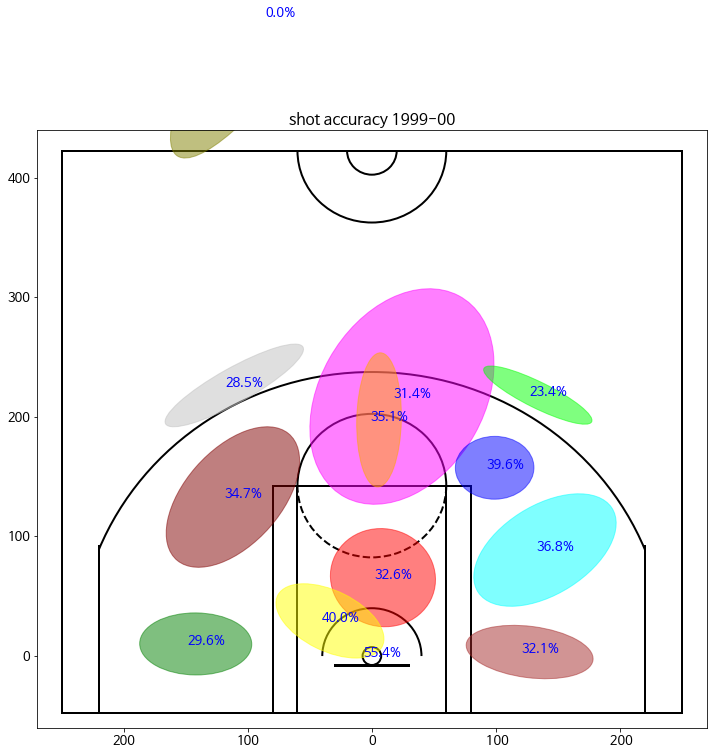

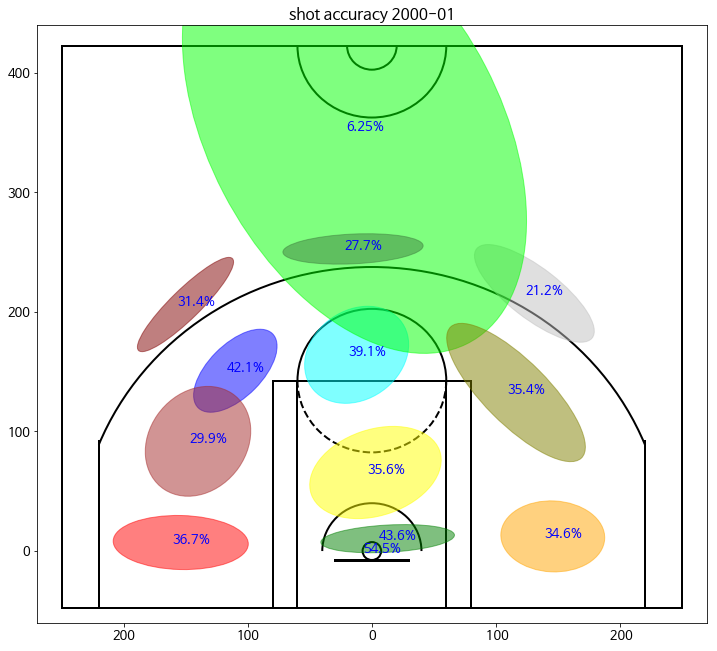

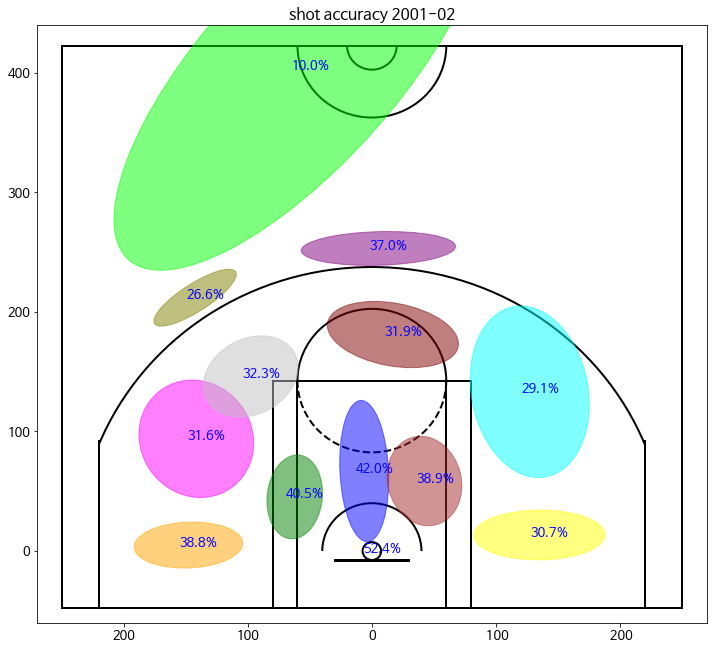

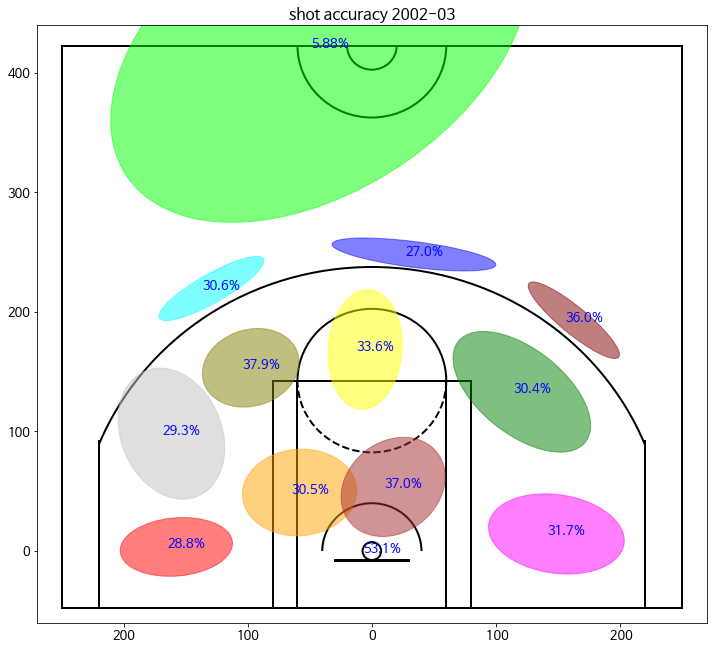

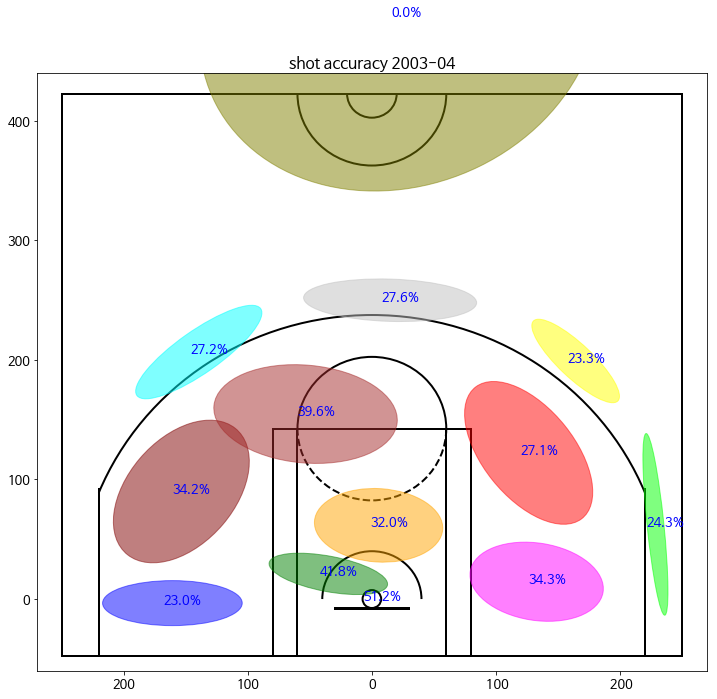

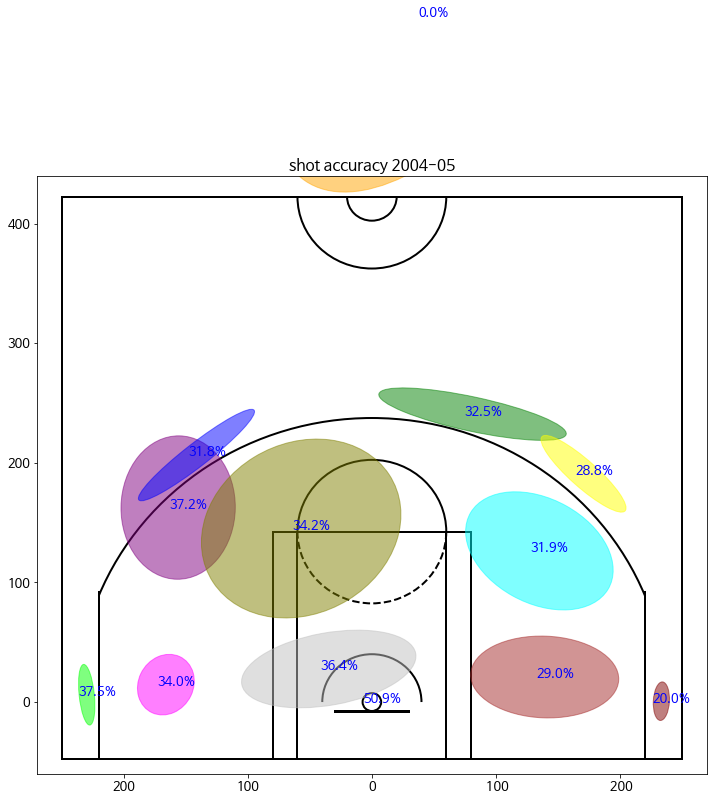

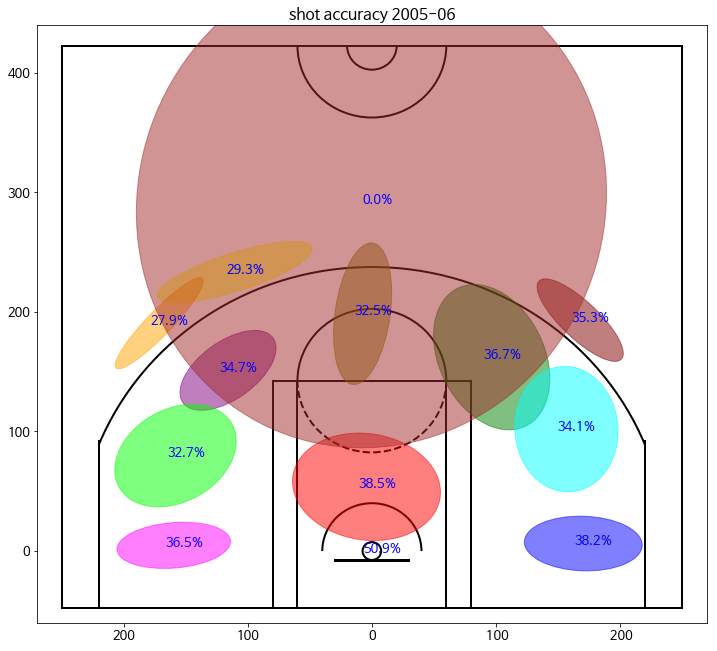

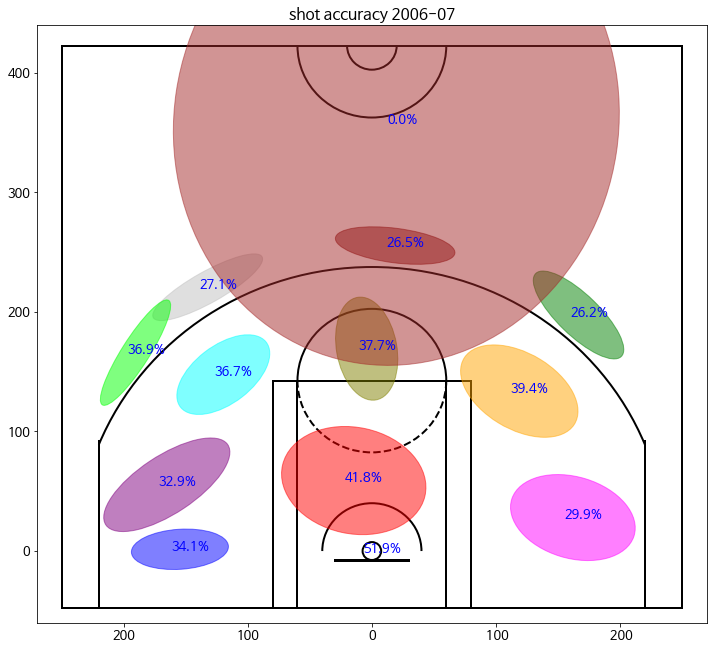

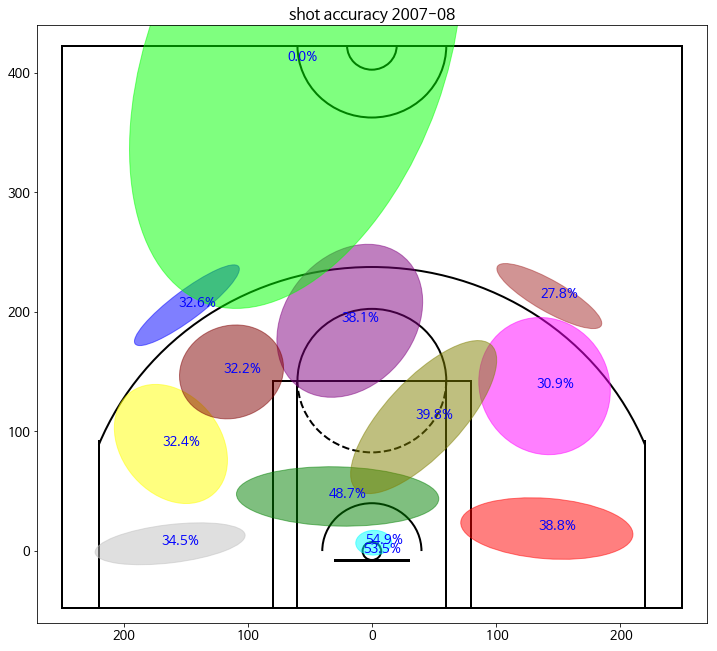

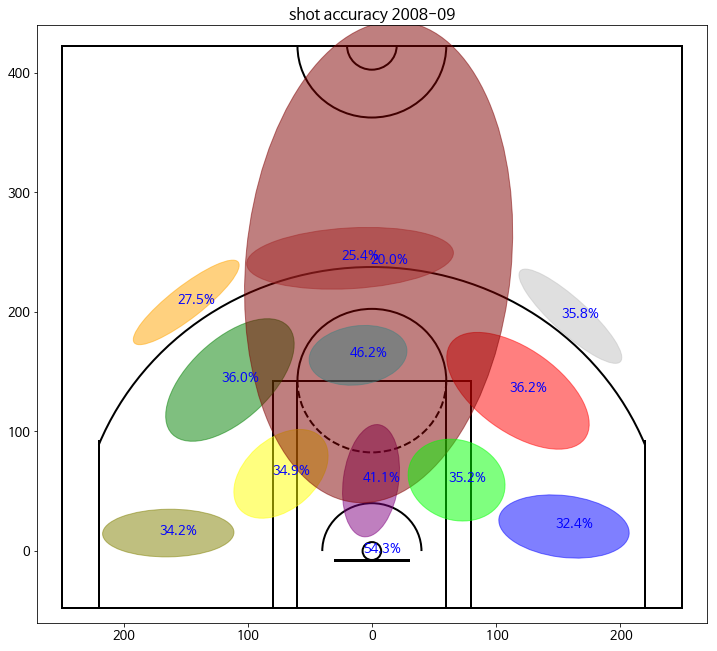

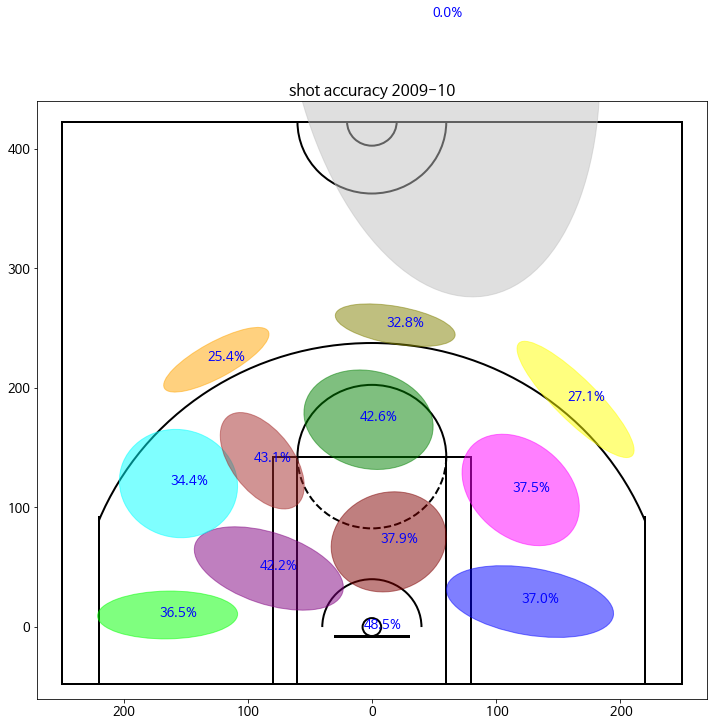

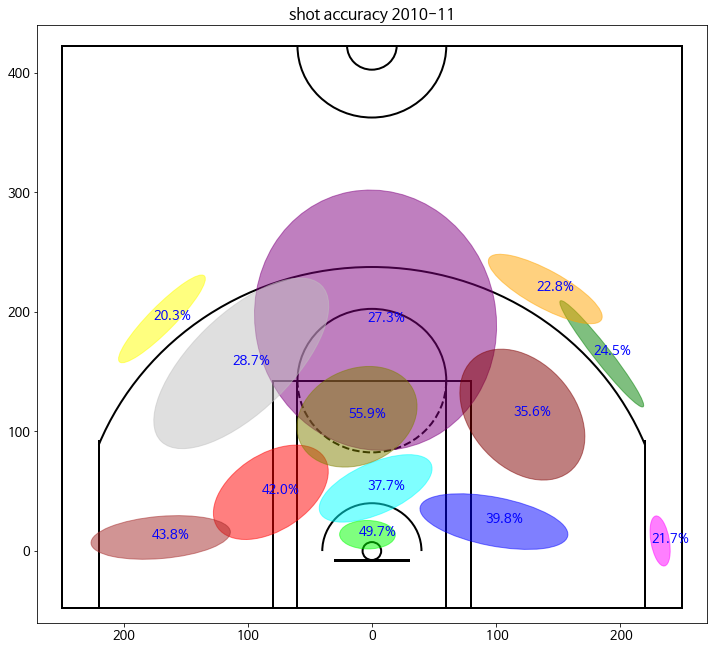

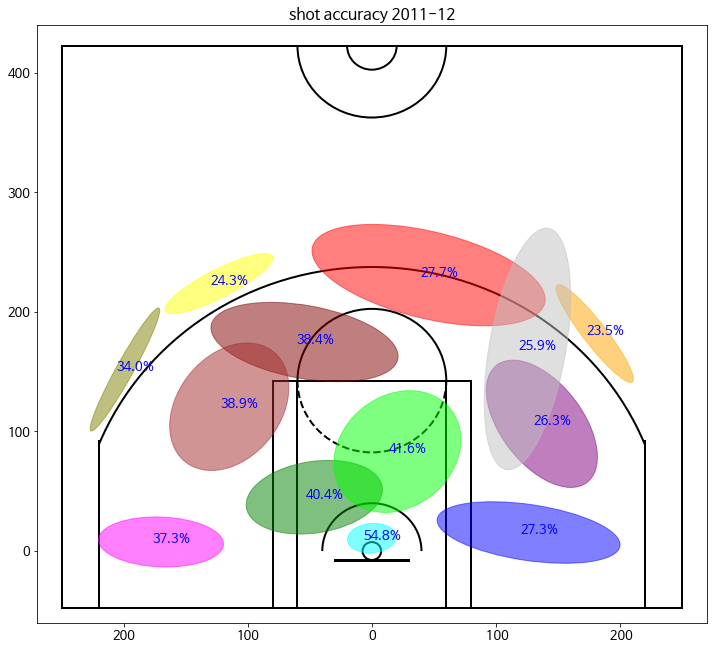

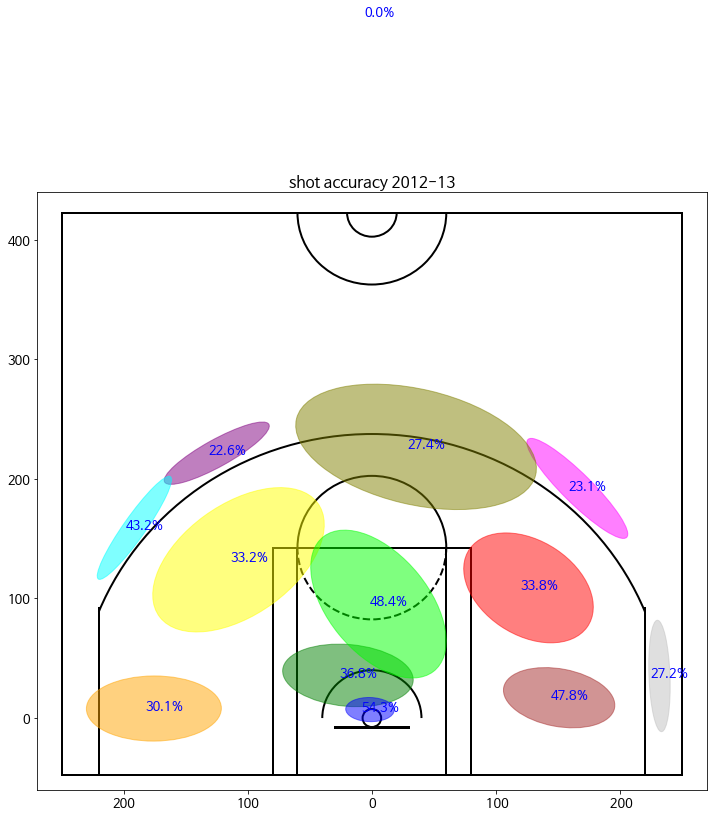

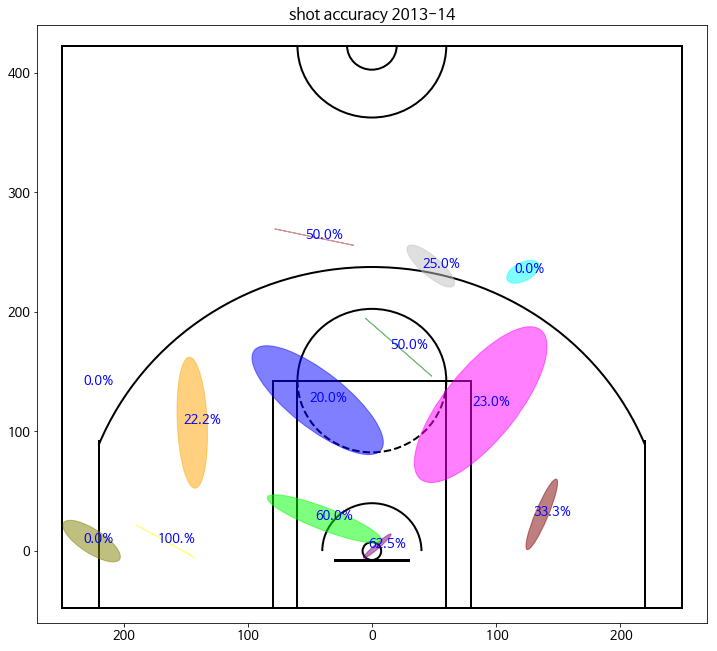

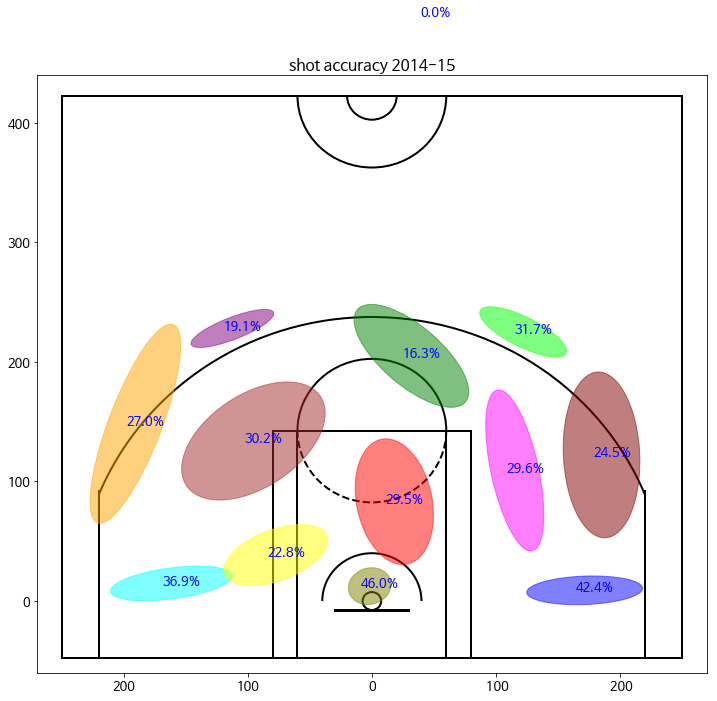

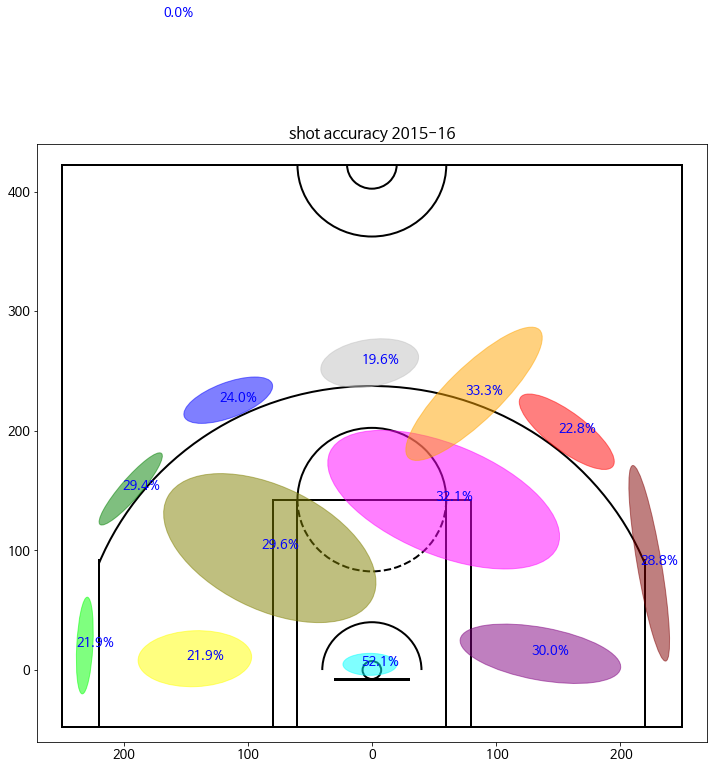

In [72]:
for s in seasons:
    attemptsGaussian(data[data["season"]==s].copy(), option="accuracy")

In [73]:
data.season.unique()

array(['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06',
       '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12',
       '2012-13', '2013-14', '2014-15', '2015-16', '1996-97', '1997-98',
       '1998-99', '1999-00'], dtype=object)

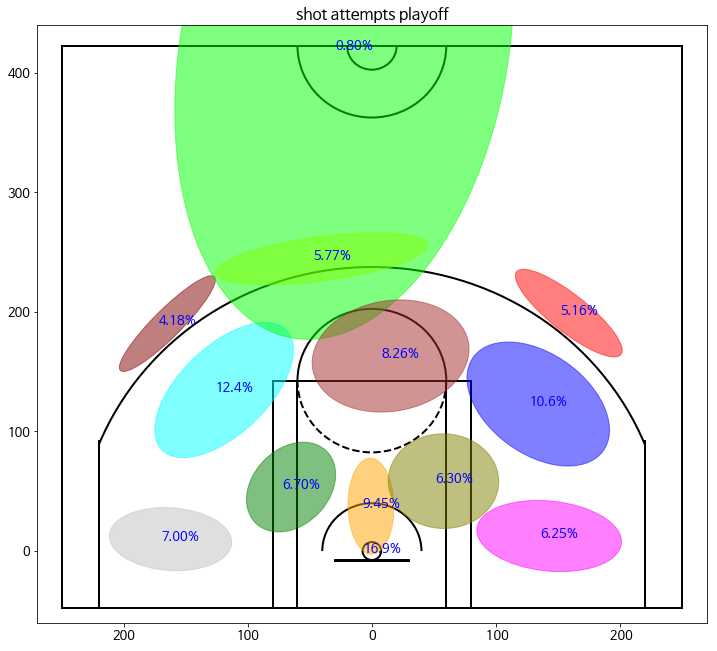

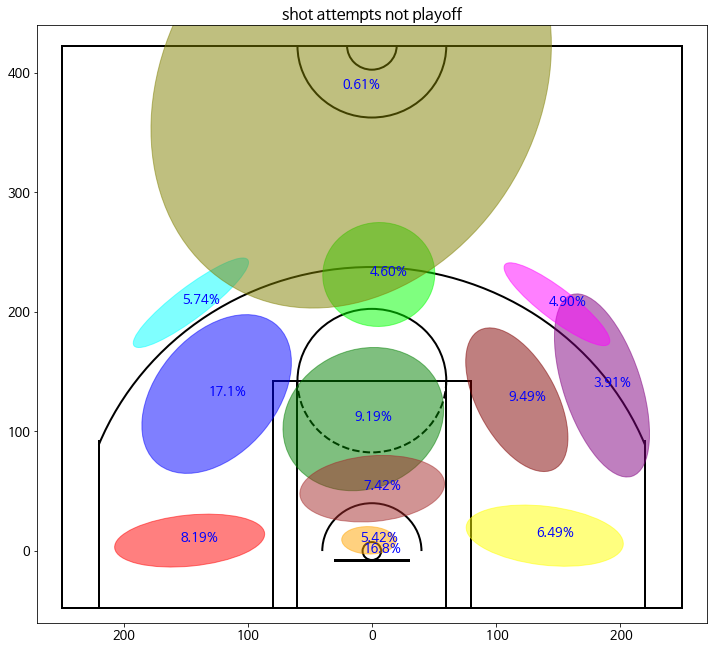

In [74]:
attemptsGaussian(data[data["playoffs"]==1].copy(), about_play_offs=True)
attemptsGaussian(data[data["playoffs"]==0].copy(), about_play_offs=True)

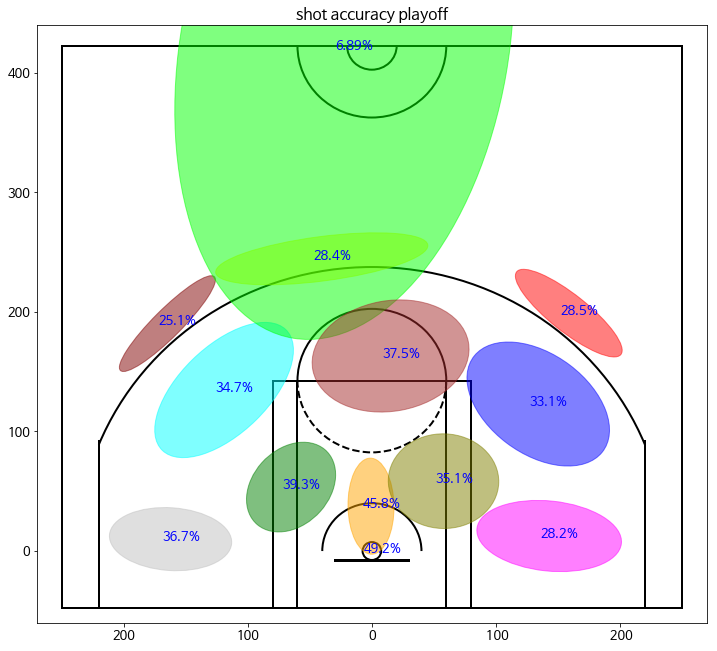

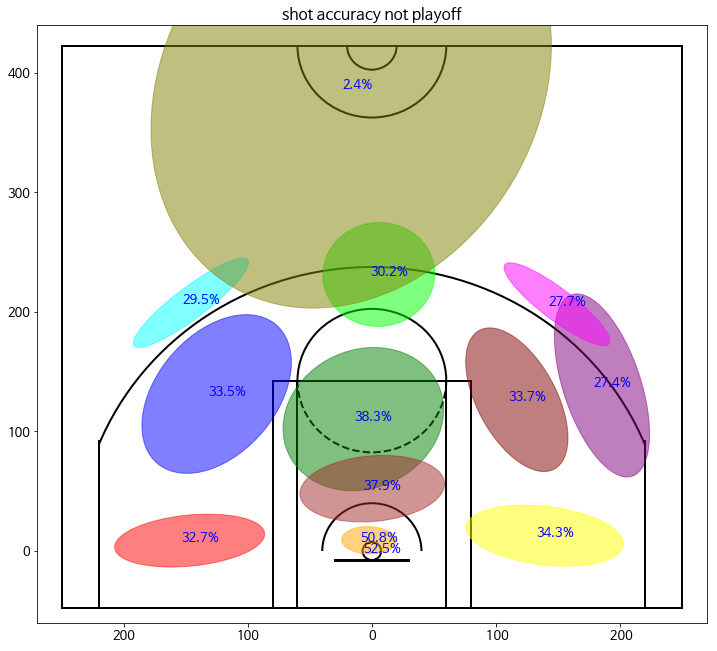

In [821]:
attemptsGaussian(data[data["playoffs"]==1].copy(), option="accuracy", about_play_offs=True)
attemptsGaussian(data[data["playoffs"]==0].copy(), option="accuracy", about_play_offs=True)

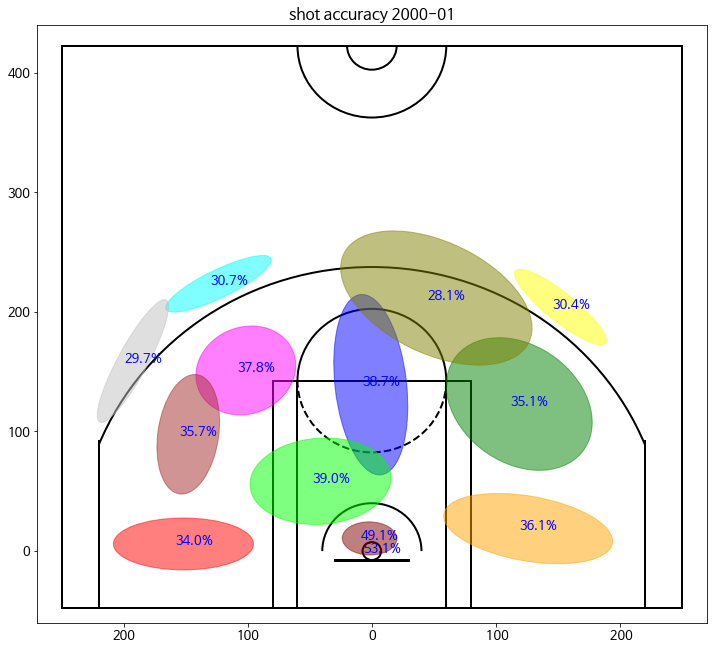

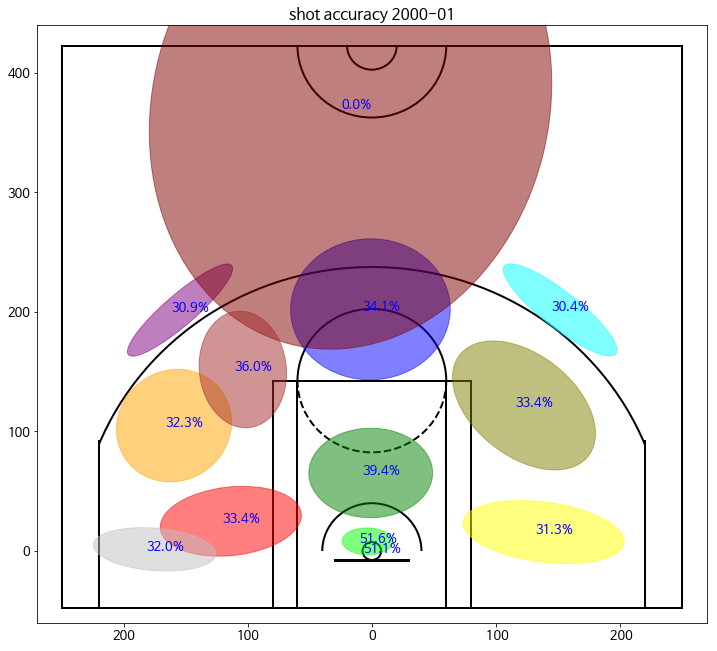

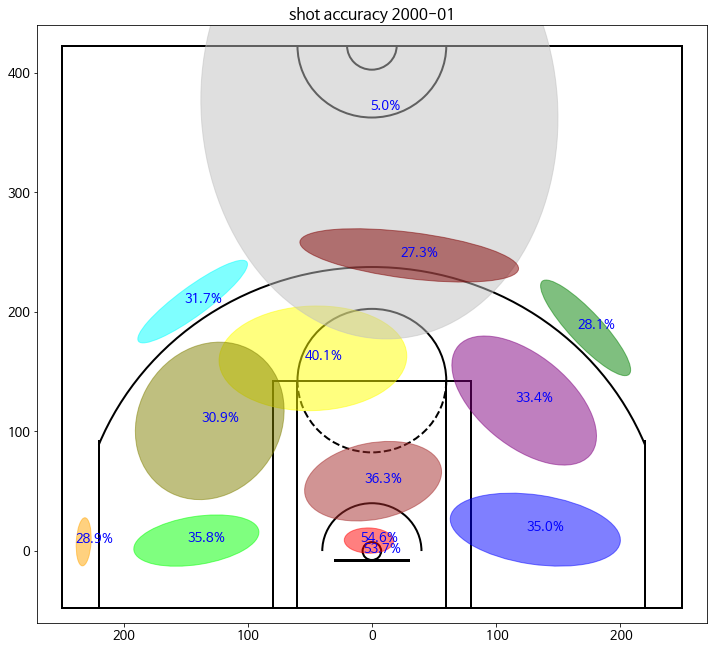

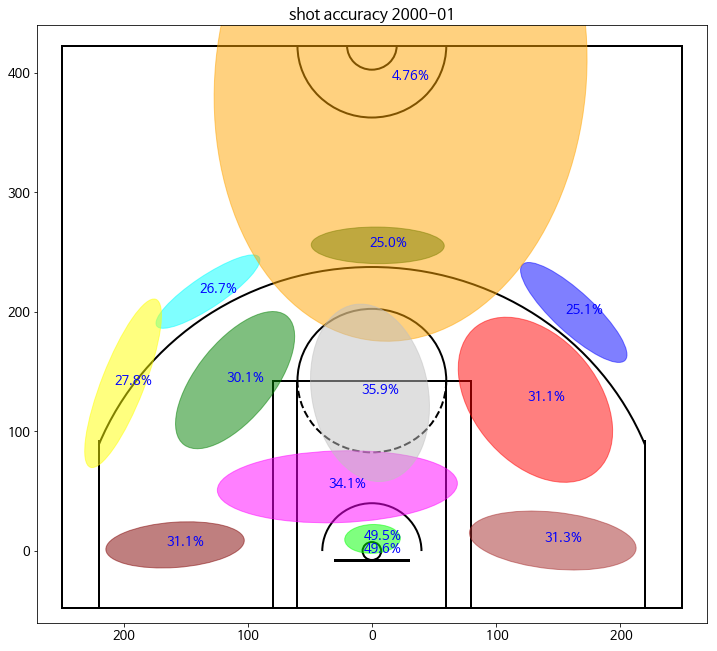

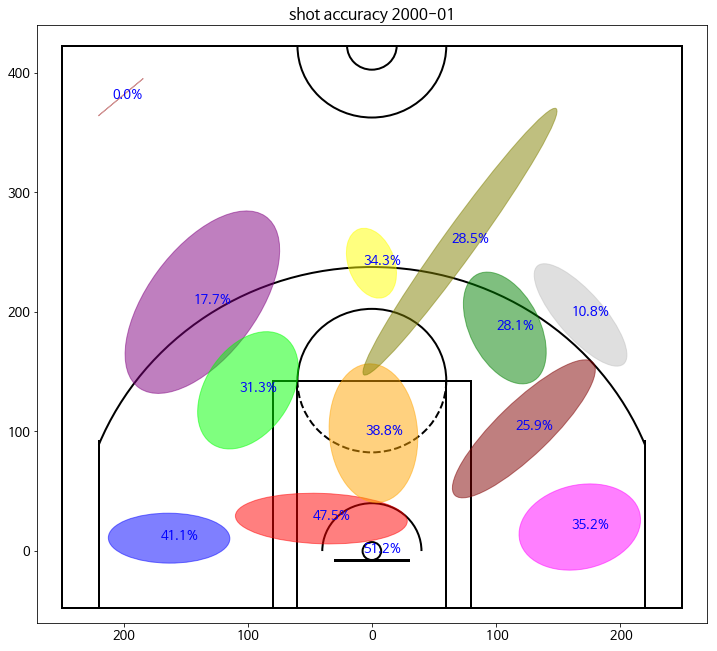

In [539]:
attemptsGaussian(data[data["quarter"]=="1st"].copy(), option="accuracy")
attemptsGaussian(data[data["quarter"]=="2nd"].copy(), option="accuracy")
attemptsGaussian(data[data["quarter"]=="3rd"].copy(), option="accuracy")
attemptsGaussian(data[data["quarter"]=="4th"].copy(), option="accuracy")
attemptsGaussian(data[data["quarter"]=="5th"].copy(), option="accuracy")
# 4,5쿼터에서 득점력이 달라지는 건 맞는듯하다

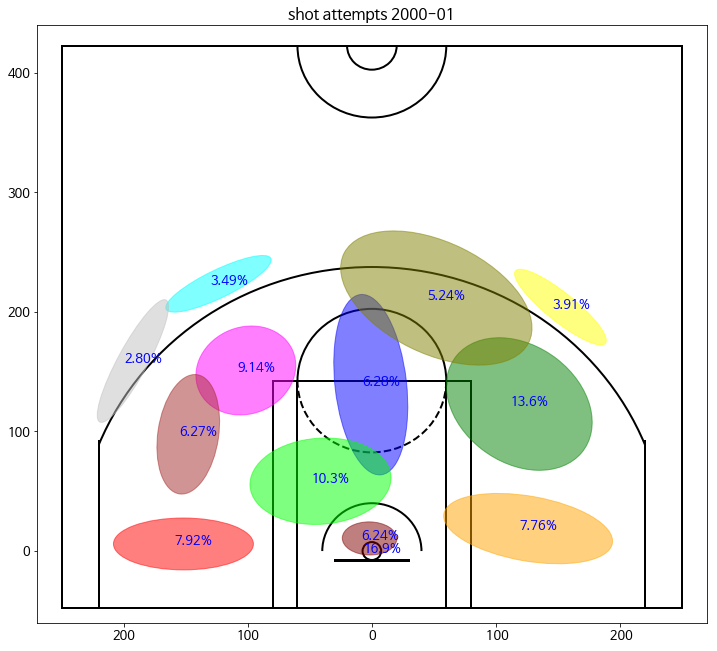

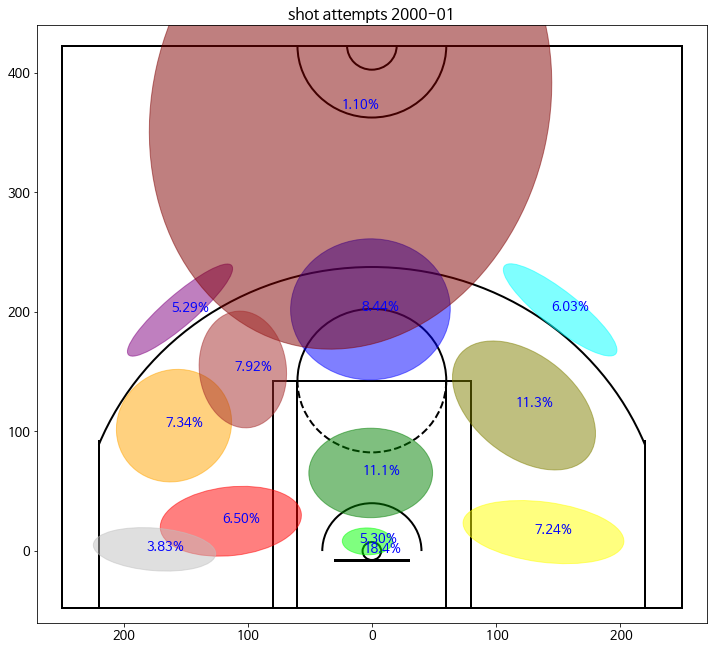

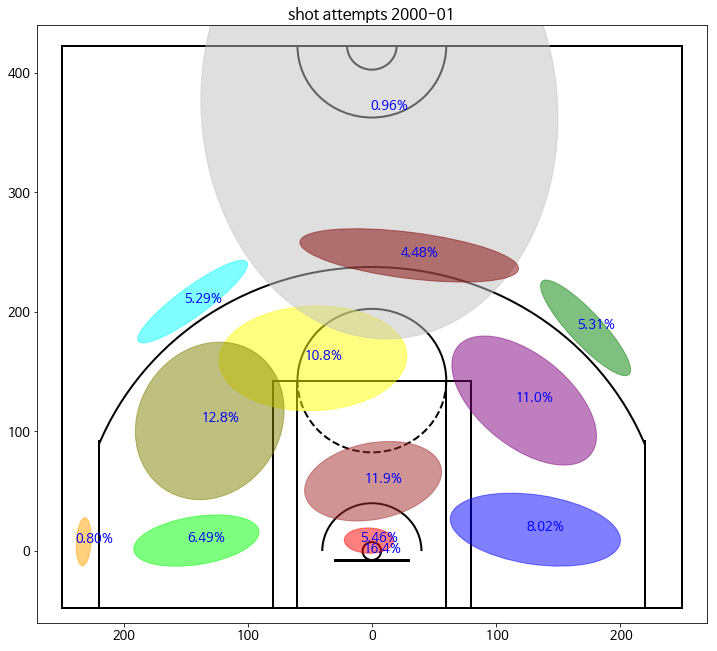

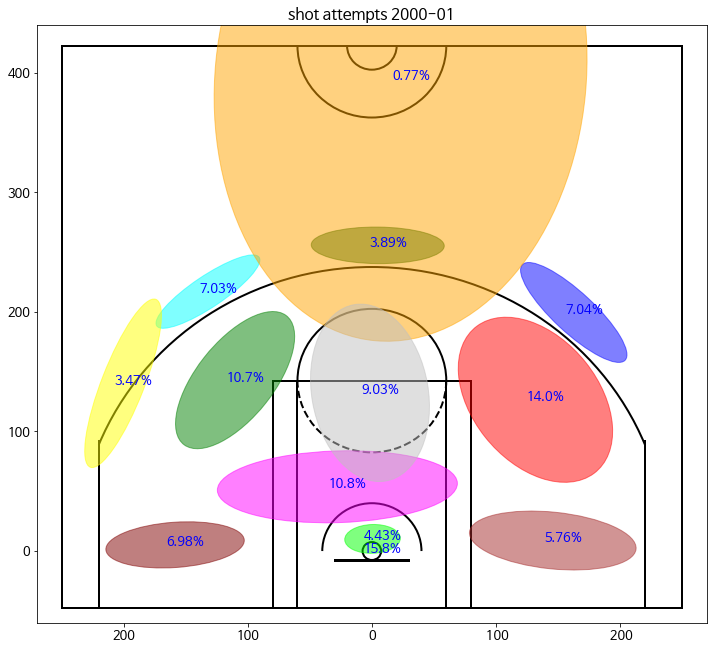

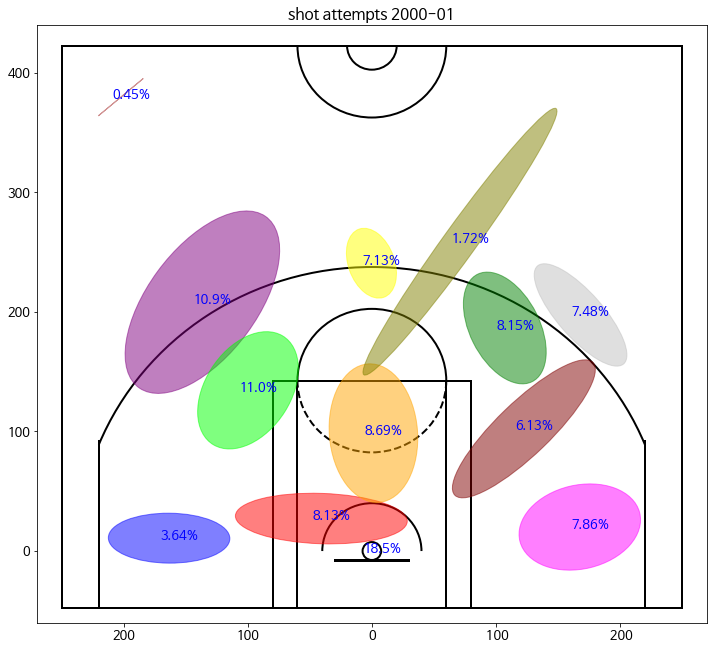

In [540]:
attemptsGaussian(data[data["quarter"]=="1st"].copy())
attemptsGaussian(data[data["quarter"]=="2nd"].copy())
attemptsGaussian(data[data["quarter"]=="3rd"].copy())
attemptsGaussian(data[data["quarter"]=="4th"].copy())
attemptsGaussian(data[data["quarter"]=="5th"].copy())

In [541]:
data['quarter_4th'] = np.where(data['quarter'] == "4th", 1, 0)
data['quarter_5th'] = np.where(data['quarter'] == "5th", 1, 0)

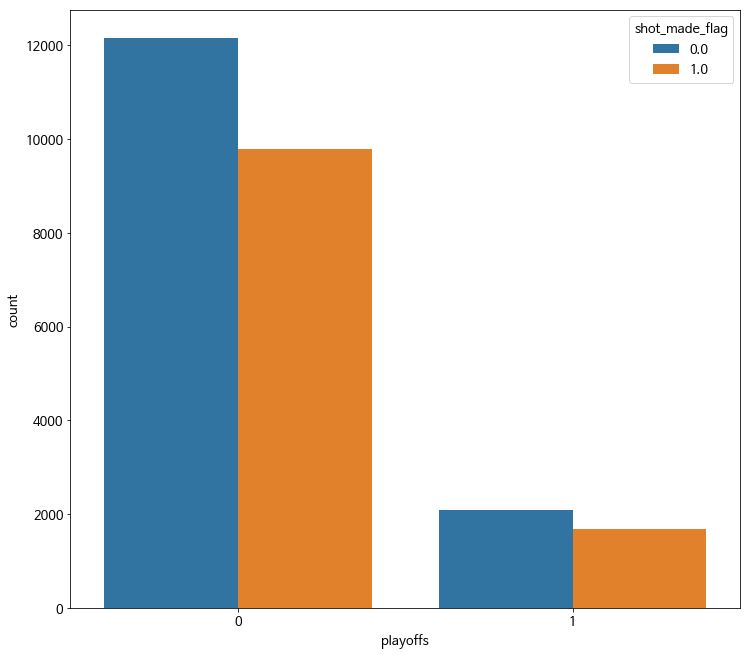

In [76]:
sns.countplot("playoffs", hue="shot_made_flag", data=data) 
# 플레이오프 시즌이 그만큼 더 잘했던 시즌이기 때문일 수도 있고
# 위 그래프를 보면 플레이오프 때는 외곽 덜 던진다...!? 플옵-비플옵 위치별 득점 비율은 비슷한 거 같은데 외곽 슛을 덜 던짐

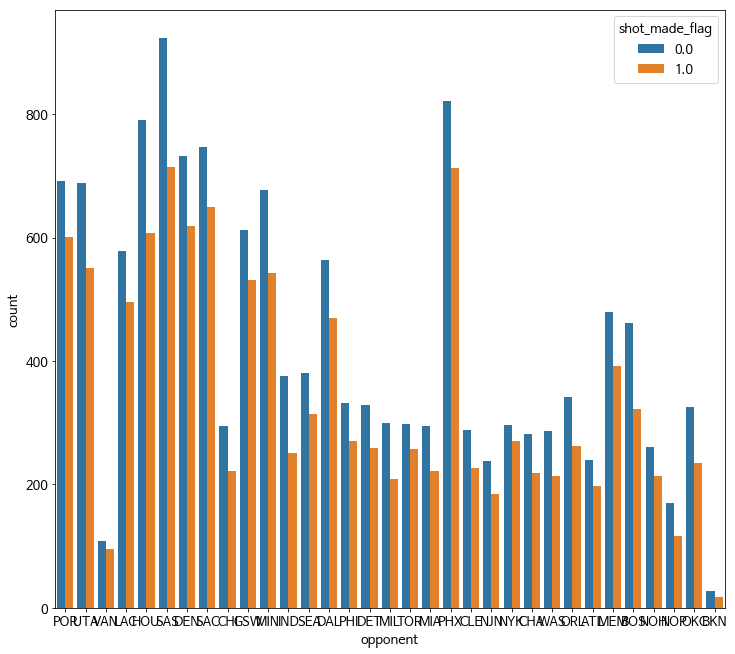

In [77]:
sns.countplot("opponent", hue="shot_made_flag", data=data)

In [78]:
pd.crosstab(data['opponent'], data['shot_made_flag'], normalize='index') # 상대에 따라 크게 다르다하기는 애매하지 않을까?

shot_made_flag       0.0       1.0
opponent                          
ATL             0.547945  0.452055
BKN             0.600000  0.400000
BOS             0.588761  0.411239
CHA             0.564000  0.436000
CHI             0.569767  0.430233
CLE             0.560311  0.439689
DAL             0.545983  0.454017
DEN             0.542160  0.457840
DET             0.558773  0.441227
GSW             0.535433  0.464567
HOU             0.565404  0.434596
IND             0.599042  0.400958
LAC             0.539106  0.460894
MEM             0.549943  0.450057
MIA             0.570600  0.429400
MIL             0.589744  0.410256
MIN             0.555373  0.444627
NJN             0.563981  0.436019
NOH             0.549474  0.450526
NOP             0.592334  0.407666
NYK             0.522968  0.477032
OKC             0.581105  0.418895
ORL             0.564570  0.435430
PHI             0.550580  0.449420
PHX             0.535505  0.464495
POR             0.534830  0.465170
SAC             0.534717  0.465283
SAS             0.563492  0.436508
SEA             0.547550  0.452450
TOR             0.535971  0.464029
UTA             0.555735  0.444265
VAN             0.529412  0.470588
WAS             0.572854  0.427146

In [392]:
pd.crosstab(data["shot_zone_basic"], data["shot_made_flag"], normalize='index')
# [Above the Break 3, Left Corner 3, Right Corner 3] 
# [In The Paint (Non-RA), Mid-Range	]
# [Backcourt]
# [Restricted Area]

shot_made_flag              0.0       1.0
shot_zone_basic                          
Above the Break 3      0.670763  0.329237
Backcourt              0.983333  0.016667
In The Paint (Non-RA)  0.545619  0.454381
Left Corner 3          0.629167  0.370833
Mid-Range              0.593714  0.406286
Restricted Area        0.381996  0.618004
Right Corner 3         0.660661  0.339339

In [397]:
# new action type 
data['shot_zone_basic'] = np.where(data['shot_zone_basic'].str.contains("3"), "Point3",
                             np.where(data['shot_zone_basic']=="In The Paint (Non-RA)", "Middle Shot",
                                      np.where(data['shot_zone_basic']=="Mid-Range", "Middle Shot",
                                      data['shot_zone_basic'])))
                                      
data['shot_zone_basic'].value_counts()

Middle Shot        17203
Restricted Area     7136
Point3              6287
Backcourt             71
Name: shot_zone_basic, dtype: int64

In [542]:
data.columns

Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'game_date', 'opponent', 'shot_id', 'hometeam', 'shot_order_in_a_game',
       'game_date_DT', 'seconds_from_period_end', 'seconds_from_period_start',
       'seconds_from_game_start', 'shot_class', 'shotLocationCluster',
       'buzzer_beater', 'quarter', 'quarter_4th', 'quarter_5th'],
      dtype='object')

In [603]:
variables = ['season', 'shot_id', 'loc_x', 'loc_y', 'playoffs', 
             'shot_distance', 'hometeam', 'shot_class', 'buzzer_beater',
             'shot_zone_basic', 'quarter_5th',
             'shot_made_flag']
# 포함하지만 모델링에 안 쓰는 변수 season, shot_id, shot_made_flag, loc_x, loc_y

predictor = ['playoffs', 'hometeam', 'shot_class', 'buzzer_beater', 'quarter_5th',
             'shot_zone_basic']
no_vars = ['season', 'shot_id', 'loc_x', 'loc_y', 'shot_distance']
yvar = 'shot_made_flag'

In [258]:
data.shot_type.unique()

array(['2PT Field Goal', '3PT Field Goal'], dtype=object)

In [87]:
data.shot_zone_area.unique()

array(['Right Side(R)', 'Left Side(L)', 'Left Side Center(LC)',
       'Right Side Center(RC)', 'Center(C)', 'Back Court(BC)'],
      dtype=object)

In [88]:
data.shot_zone_basic.unique()

array(['Mid-Range', 'Restricted Area', 'In The Paint (Non-RA)',
       'Above the Break 3', 'Right Corner 3', 'Backcourt',
       'Left Corner 3'], dtype=object)

In [89]:
data.shot_zone_range.unique()

array(['16-24 ft.', '8-16 ft.', 'Less Than 8 ft.', '24+ ft.',
       'Back Court Shot'], dtype=object)

In [398]:
data[['shot_distance', 'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range']].head()

shot_distance       shot_type         shot_zone_area  shot_zone_basic  \
0             18  2PT Field Goal          Right Side(R)      Middle Shot   
1             15  2PT Field Goal           Left Side(L)      Middle Shot   
2             16  2PT Field Goal   Left Side Center(LC)      Middle Shot   
3             22  2PT Field Goal  Right Side Center(RC)      Middle Shot   
4              0  2PT Field Goal              Center(C)  Restricted Area   

   shot_zone_range  
0        16-24 ft.  
1         8-16 ft.  
2        16-24 ft.  
3        16-24 ft.  
4  Less Than 8 ft.

In [602]:
data.to_pickle('./data.pkl')

In [640]:
df = data[variables]
df.head()

season  shot_id  loc_x  loc_y  playoffs  shot_distance  hometeam  \
0  2000-01        1    167     72         0             18         0   
1  2000-01        2   -157      0         0             15         0   
2  2000-01        3   -101    135         0             16         0   
3  2000-01        4    138    175         0             22         0   
4  2000-01        5      0      0         0              0         0   

       shot_class  buzzer_beater  shot_zone_basic  quarter_5th  shot_made_flag  
0       Jump Shot              0      Middle Shot            0             NaN  
1       Jump Shot              0      Middle Shot            0             0.0  
2       Jump Shot              0      Middle Shot            0             1.0  
3       Jump Shot              0      Middle Shot            0             0.0  
4  Good Dunk Shot              0  Restricted Area            0             1.0

In [641]:
df['buzzer_beater'] = df['buzzer_beater'].astype('category')

C:\Users\asd\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [642]:
df['playoffs'] = df['playoffs'].astype('category')

C:\Users\asd\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [643]:
df['hometeam'] = df['hometeam'].astype('category')

C:\Users\asd\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [623]:
df['quarter_4th'] = df['quarter_4th'].astype('category')

KeyError: 'quarter_4th'

In [644]:
df['quarter_5th'] = df['quarter_5th'].astype('category')

C:\Users\asd\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [645]:
df[predictor].dtypes

playoffs           category
hometeam           category
shot_class           object
buzzer_beater      category
quarter_5th        category
shot_zone_basic      object
dtype: object

In [646]:
df2 = df.copy()
categorial_cols = ['shot_class', 'shot_zone_basic']
for cc in categorial_cols:
    dummies = pd.get_dummies(df2[cc])
    dummies = dummies.add_prefix("{}#".format(cc))
    df2.drop(cc, axis=1, inplace=True)
    df2 = df2.join(dummies)
df2.head()

season  shot_id  loc_x  loc_y playoffs  shot_distance hometeam  \
0  2000-01        1    167     72        0             18        0   
1  2000-01        2   -157      0        0             15        0   
2  2000-01        3   -101    135        0             16        0   
3  2000-01        4    138    175        0             22        0   
4  2000-01        5      0      0        0              0        0   

  buzzer_beater quarter_5th  shot_made_flag  ...  shot_class#Good Jump Shot  \
0             0           0             NaN  ...                          0   
1             0           0             0.0  ...                          0   
2             0           0             1.0  ...                          0   
3             0           0             0.0  ...                          0   
4             0           0             1.0  ...                          0   

   shot_class#Good Layup Shot  shot_class#Hook Shot  shot_class#Jump Shot  \
0                           0                     0                     1   
1                           0                     0                     1   
2                           0                     0                     1   
3                           0                     0                     1   
4                           0                     0                     0   

   shot_class#Layup Shot  shot_class#Tip Shot  shot_zone_basic#Backcourt  \
0                      0                    0                          0   
1                      0                    0                          0   
2                      0                    0                          0   
3                      0                    0                          0   
4                      0                    0                          0   

   shot_zone_basic#Middle Shot  shot_zone_basic#Point3  \
0                            1                       0   
1                            1                       0   
2                            1                       0   
3                            1                       0   
4                            0                       0   

   shot_zone_basic#Restricted Area  
0                                0  
1                                0  
2                                0  
3                                0  
4                                1  

[5 rows x 26 columns]

In [647]:
df2.dtypes

season                               object
shot_id                               int64
loc_x                                 int64
loc_y                                 int64
playoffs                           category
shot_distance                         int64
hometeam                           category
buzzer_beater                      category
quarter_5th                        category
shot_made_flag                      float64
shot_class#Bank Shot                  uint8
shot_class#Dunk Shot                  uint8
shot_class#Fadeaway Shot              uint8
shot_class#Finger Roll                uint8
shot_class#Good Dunk Shot             uint8
shot_class#Good Hook Shot             uint8
shot_class#Good Jump Shot             uint8
shot_class#Good Layup Shot            uint8
shot_class#Hook Shot                  uint8
shot_class#Jump Shot                  uint8
shot_class#Layup Shot                 uint8
shot_class#Tip Shot                   uint8
shot_zone_basic#Backcourt       

In [648]:
df3 = df2.drop(no_vars, axis=1)

# For Baseline 
### Score 0.61979 == buzzer 0/1 ==> 0.61226 == no shot zone area ==> 0.60720
### Rank 662/1117 == buzzer 0/1 ==> 573/1117 == no shot zone area ==> 402/1117

In [649]:
train = df3[df3['shot_made_flag'].notnull()].reset_index(drop=True) # 샷 성공 여부 알 수 없는 관측치 제거

train['season'].unique() # 전체 기간에 대해 할 필요가 없다. 전성기(1998~2010년) => 시즌으로 나누자(98-99 ~ 10-11)

In [650]:
test = df3[df3['shot_made_flag'].isnull()].reset_index(drop=True) # test set which shot_made_flag is NaN

In [651]:
test.head().iloc[:, -11:-1]

shot_class#Good Hook Shot  shot_class#Good Jump Shot  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   shot_class#Good Layup Shot  shot_class#Hook Shot  shot_class#Jump Shot  \
0                           0                     0                     1   
1                           0                     0                     1   
2                           1                     0                     0   
3                           1                     0                     0   
4                           0                     0                     1   

   shot_class#Layup Shot  shot_class#Tip Shot  shot_zone_basic#Backcourt  \
0                      0                    0                          0   
1                      0                    0                          0   
2                      0                    0                          0   
3                      0                    0                          0   
4                      0                    0                          0   

   shot_zone_basic#Middle Shot  shot_zone_basic#Point3  
0                            1                       0  
1                            0                       0  
2                            0                       0  
3                            0                       0  
4                            1                       0

test.season.unique()

In [652]:
X_train = train.drop(yvar, axis=1)
y_train = train[yvar].astype(int).astype('category')
X_test = test.drop(yvar, axis=1)

In [653]:
y_train.dtypes

CategoricalDtype(categories=[0, 1], ordered=False)

In [654]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=123)
model = rf.fit(X_train, y_train)

In [655]:
train_pred = model.predict_proba(X_train)
train_pred

array([[0.65041465, 0.34958535],
       [0.65041465, 0.34958535],
       [0.65041465, 0.34958535],
       ...,
       [0.20201579, 0.79798421],
       [0.66166284, 0.33833716],
       [0.6901835 , 0.3098165 ]])

In [656]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("log_loss:", metrics.log_loss(y_train, train_pred))

log_loss: 0.6050371057423727


In [657]:
test_pred = model.predict_proba(X_test)
test_pred

array([[0.65041465, 0.34958535],
       [0.77528519, 0.22471481],
       [0.37308218, 0.62691782],
       ...,
       [0.20201579, 0.79798421],
       [0.20201579, 0.79798421],
       [0.52366501, 0.47633499]])

In [658]:
# about trainset!! not test!!
submission = pd.DataFrame()
submission["shot_id"] = df[df['shot_made_flag'].notnull()].reset_index(drop=True).shot_id
submission["real"] = y_train
submission["pred"] = train_pred[:,1]
submission.head(10)

shot_id real      pred
0        2    0  0.349585
1        3    1  0.349585
2        4    0  0.349585
3        5    1  0.950374
4        6    0  0.349585
5        7    1  0.430766
6        9    1  0.349585
7       10    0  0.589097
8       11    0  0.318459
9       12    1  0.317488

In [659]:
submission = pd.DataFrame()
submission["shot_id"] = df[df['shot_made_flag'].isnull()].reset_index(drop=True).shot_id
submission["shot_made_flag"] = test_pred[:,1]

In [660]:
submission.head(10)

shot_id  shot_made_flag
0        1        0.349585
1        8        0.224715
2       17        0.626918
3       20        0.754213
4       33        0.349585
5       34        0.349585
6       35        0.430766
7       36        0.430766
8       37        0.729790
9       38        0.349585

In [664]:
submission.to_csv("sub.csv",index=False) # 703/1117

In [662]:
submission.to_pickle("submission1.pkl")

### importance

In [663]:
imp = pd.DataFrame({'importance':rf.feature_importances_})
imp['features'] = X_train.columns
imp
imp.sort_values(by='importance', ascending=False, inplace=True)
imp

importance                         features
13    0.318086             shot_class#Jump Shot
8     0.136771        shot_class#Good Dunk Shot
10    0.101757        shot_class#Good Jump Shot
11    0.090854       shot_class#Good Layup Shot
14    0.082560            shot_class#Layup Shot
19    0.077739  shot_zone_basic#Restricted Area
1     0.043159                         hometeam
2     0.028957                    buzzer_beater
18    0.020051           shot_zone_basic#Point3
17    0.016305      shot_zone_basic#Middle Shot
5     0.013109             shot_class#Dunk Shot
0     0.012655                         playoffs
15    0.012218              shot_class#Tip Shot
4     0.011519             shot_class#Bank Shot
3     0.008664                      quarter_5th
6     0.006576         shot_class#Fadeaway Shot
7     0.005801           shot_class#Finger Roll
12    0.005070             shot_class#Hook Shot
9     0.004531        shot_class#Good Hook Shot
16    0.003617        shot_zone_basic#Backcourt

In [420]:
model.estimators_[1:3]

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=914636141, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=1228959102, splitter='best')]

In [509]:
terminal = model.apply(X_train)

In [510]:
n_trees = terminal.shape[1]
n_trees

100

In [511]:
terminal

array([[146, 121,  70, ..., 148,  91, 208],
       [146, 121,  70, ..., 148,  91, 208],
       [146, 121,  70, ..., 148,  91, 208],
       ...,
       [195, 207, 160, ...,  98,  54, 192],
       [128, 103,  82, ..., 138,  73, 153],
       [150, 130,  78, ..., 152,  95, 218]], dtype=int64)

In [512]:
terminal[:,0]

array([146, 146, 146, ..., 195, 128, 150], dtype=int64)

In [513]:
1*np.equal.outer(terminal[:,0], terminal[:,0])

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [514]:
def proximityMatrix(model, X, normalize=True):      

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    if normalize:
        proxMat = proxMat / nTrees

    return proxMat   

In [515]:
proximityMatrix(model, X_train, normalize=True)

MemoryError: 

In [739]:
from sklearn.ensemble import IsolationForest

In [857]:
isol = IsolationForest(n_estimators=500, max_samples=0.3, random_state=123, behaviour="new", contamination=0.01)

In [833]:
heyday = df.loc[(df.season >= '1999-00') & (df.season <= '2010-11') & (df.season != '2004-05')].reset_index(drop=True)
heyday.head()

season  shot_id  loc_x  loc_y playoffs  shot_distance hometeam  \
0  2000-01        1    167     72        0             18        0   
1  2000-01        2   -157      0        0             15        0   
2  2000-01        3   -101    135        0             16        0   
3  2000-01        4    138    175        0             22        0   
4  2000-01        5      0      0        0              0        0   

       shot_class buzzer_beater  shot_zone_basic quarter_5th  shot_made_flag  
0       Jump Shot             0      Middle Shot           0             NaN  
1       Jump Shot             0      Middle Shot           0             0.0  
2       Jump Shot             0      Middle Shot           0             1.0  
3       Jump Shot             0      Middle Shot           0             0.0  
4  Good Dunk Shot             0  Restricted Area           0             1.0

In [834]:
heyday = heyday[heyday['shot_made_flag'].notnull()]
heyday.head()

season  shot_id  loc_x  loc_y playoffs  shot_distance hometeam  \
1  2000-01        2   -157      0        0             15        0   
2  2000-01        3   -101    135        0             16        0   
3  2000-01        4    138    175        0             22        0   
4  2000-01        5      0      0        0              0        0   
5  2000-01        6   -145    -11        0             14        0   

       shot_class buzzer_beater  shot_zone_basic quarter_5th  shot_made_flag  
1       Jump Shot             0      Middle Shot           0             0.0  
2       Jump Shot             0      Middle Shot           0             1.0  
3       Jump Shot             0      Middle Shot           0             0.0  
4  Good Dunk Shot             0  Restricted Area           0             1.0  
5       Jump Shot             0      Middle Shot           0             0.0

In [835]:
heyv = ['playoffs', 'hometeam', 'shot_class', 'buzzer_beater', 'shot_zone_basic', 'quarter_5th', 'shot_made_flag']

In [836]:
heyX = heyday[heyv]
heyX.head()

playoffs hometeam      shot_class buzzer_beater  shot_zone_basic  \
1        0        0       Jump Shot             0      Middle Shot   
2        0        0       Jump Shot             0      Middle Shot   
3        0        0       Jump Shot             0      Middle Shot   
4        0        0  Good Dunk Shot             0  Restricted Area   
5        0        0       Jump Shot             0      Middle Shot   

  quarter_5th  shot_made_flag  
1           0             0.0  
2           0             1.0  
3           0             0.0  
4           0             1.0  
5           0             0.0

In [838]:
heyX.dtypes

playoffs           category
hometeam           category
shot_class           object
buzzer_beater      category
shot_zone_basic      object
quarter_5th        category
shot_made_flag      float64
dtype: object

In [ ]:
heyX.shot_made_flag = heyX.shot_made_flag.astype('category')

In [839]:
#hey2 = heyX.copy()
categorial_cols = ['shot_class', 'shot_zone_basic']
for cc in categorial_cols:
    dummies = pd.get_dummies(heyX[cc])
    dummies = dummies.add_prefix("{}#".format(cc))
    heyX.drop(cc, axis=1, inplace=True)
    heyX = heyX.join(dummies)
heyX.head()

C:\Users\asd\Anaconda3\lib\site-packages\pandas\core\frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


playoffs hometeam buzzer_beater quarter_5th  shot_made_flag  \
1        0        0             0           0             0.0   
2        0        0             0           0             1.0   
3        0        0             0           0             0.0   
4        0        0             0           0             1.0   
5        0        0             0           0             0.0   

   shot_class#Bank Shot  shot_class#Dunk Shot  shot_class#Fadeaway Shot  \
1                     0                     0                         0   
2                     0                     0                         0   
3                     0                     0                         0   
4                     0                     0                         0   
5                     0                     0                         0   

   shot_class#Finger Roll  shot_class#Good Dunk Shot  ...  \
1                       0                          0  ...   
2                       0                          0  ...   
3                       0                          0  ...   
4                       0                          1  ...   
5                       0                          0  ...   

   shot_class#Good Jump Shot  shot_class#Good Layup Shot  \
1                          0                           0   
2                          0                           0   
3                          0                           0   
4                          0                           0   
5                          0                           0   

   shot_class#Hook Shot  shot_class#Jump Shot  shot_class#Layup Shot  \
1                     0                     1                      0   
2                     0                     1                      0   
3                     0                     1                      0   
4                     0                     0                      0   
5                     0                     1                      0   

   shot_class#Tip Shot  shot_zone_basic#Backcourt  \
1                    0                          0   
2                    0                          0   
3                    0                          0   
4                    0                          0   
5                    0                          0   

   shot_zone_basic#Middle Shot  shot_zone_basic#Point3  \
1                            1                       0   
2                            1                       0   
3                            1                       0   
4                            0                       0   
5                            1                       0   

   shot_zone_basic#Restricted Area  
1                                0  
2                                0  
3                                0  
4                                1  
5                                0  

[5 rows x 21 columns]

In [824]:
Xy = pd.concat([X_train.reset_index(drop=True), y_train], axis=1)
Xy.head()

playoffs hometeam buzzer_beater quarter_5th  shot_class#Bank Shot  \
0        0        0             0           0                     0   
1        0        0             0           0                     0   
2        0        0             0           0                     0   
3        0        0             0           0                     0   
4        0        0             0           0                     0   

   shot_class#Dunk Shot  shot_class#Fadeaway Shot  shot_class#Finger Roll  \
0                     0                         0                       0   
1                     0                         0                       0   
2                     0                         0                       0   
3                     0                         0                       0   
4                     0                         0                       0   

   shot_class#Good Dunk Shot  shot_class#Good Hook Shot  ...  \
0                          0                          0  ...   
1                          0                          0  ...   
2                          0                          0  ...   
3                          1                          0  ...   
4                          0                          0  ...   

   shot_class#Good Layup Shot  shot_class#Hook Shot  shot_class#Jump Shot  \
0                           0                     0                     1   
1                           0                     0                     1   
2                           0                     0                     1   
3                           0                     0                     0   
4                           0                     0                     1   

   shot_class#Layup Shot  shot_class#Tip Shot  shot_zone_basic#Backcourt  \
0                      0                    0                          0   
1                      0                    0                          0   
2                      0                    0                          0   
3                      0                    0                          0   
4                      0                    0                          0   

   shot_zone_basic#Middle Shot  shot_zone_basic#Point3  \
0                            1                       0   
1                            1                       0   
2                            1                       0   
3                            0                       0   
4                            1                       0   

   shot_zone_basic#Restricted Area  shot_made_flag  
0                                0               0  
1                                0               1  
2                                0               0  
3                                1               1  
4                                0               0  

[5 rows x 21 columns]

In [858]:
isol_fit = isol.fit(heyX)

In [859]:
isol_pred = isol_fit.predict(heyX)

In [860]:
sum(isol_pred==-1)

177

In [861]:
itrain = heyday.copy()

In [862]:
itrain["isolation"] = isol_pred

In [883]:
isolated = itrain[itrain["isolation"] == -1]
isolated.head()

season  shot_id  loc_x  loc_y playoffs  shot_distance hometeam  \
386   2000-01      387      0      0        0              0        1   
531   2000-01      532    -71    270        0             27        1   
603   2000-01      604      0      0        0              0        0   
1073  2000-01     1074    106    696        0             70        1   
1116  2000-01     1117      0      0        0              0        0   

           shot_class buzzer_beater  shot_zone_basic quarter_5th  \
386          Tip Shot             1  Restricted Area           0   
531         Jump Shot             1           Point3           1   
603       Finger Roll             0  Restricted Area           1   
1073        Jump Shot             1        Backcourt           0   
1116  Good Layup Shot             1  Restricted Area           1   

      shot_made_flag  isolation  
386              1.0         -1  
531              0.0         -1  
603              1.0         -1  
1073             0.0         -1  
1116             1.0         -1

In [884]:
len(isolated)

177

In [1053]:
isol.decision_function(heyX)

array([0.25622553, 0.23833394, 0.25622553, ..., 0.16304487, 0.139629  ,
       0.2041515 ])

In [1054]:
itrain['isol_prob'] = isol.decision_function(heyX)
itrain.head(3)

season  shot_id  loc_x  loc_y playoffs  shot_distance hometeam shot_class  \
1  2000-01        2   -157      0        0             15        0  Jump Shot   
2  2000-01        3   -101    135        0             16        0  Jump Shot   
3  2000-01        4    138    175        0             22        0  Jump Shot   

  buzzer_beater shot_zone_basic quarter_5th  shot_made_flag  isolation  \
1             0     Middle Shot           0             0.0          1   
2             0     Middle Shot           0             1.0          1   
3             0     Middle Shot           0             0.0          1   

   isol_prob  
1   0.256226  
2   0.238334  
3   0.256226

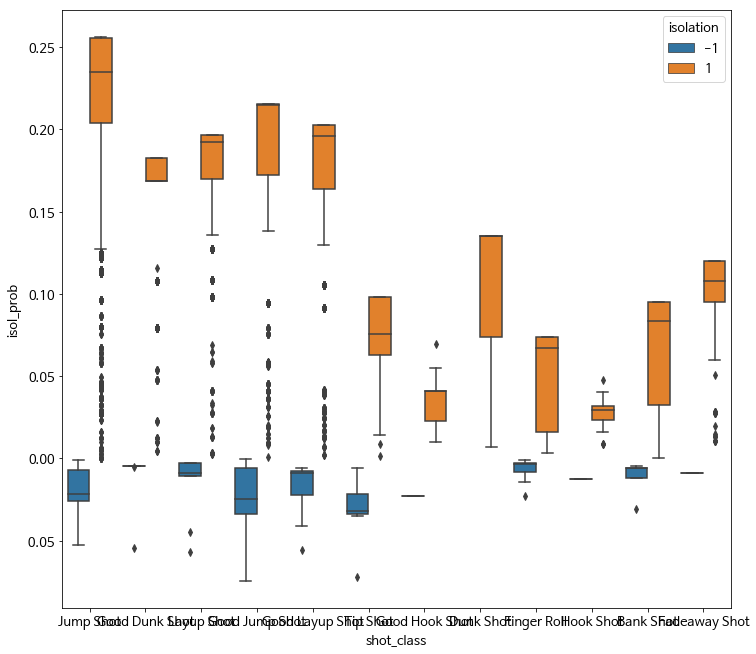

In [1056]:
sns.boxplot(x='shot_class', y='isol_prob', data=itrain, hue='isolation')

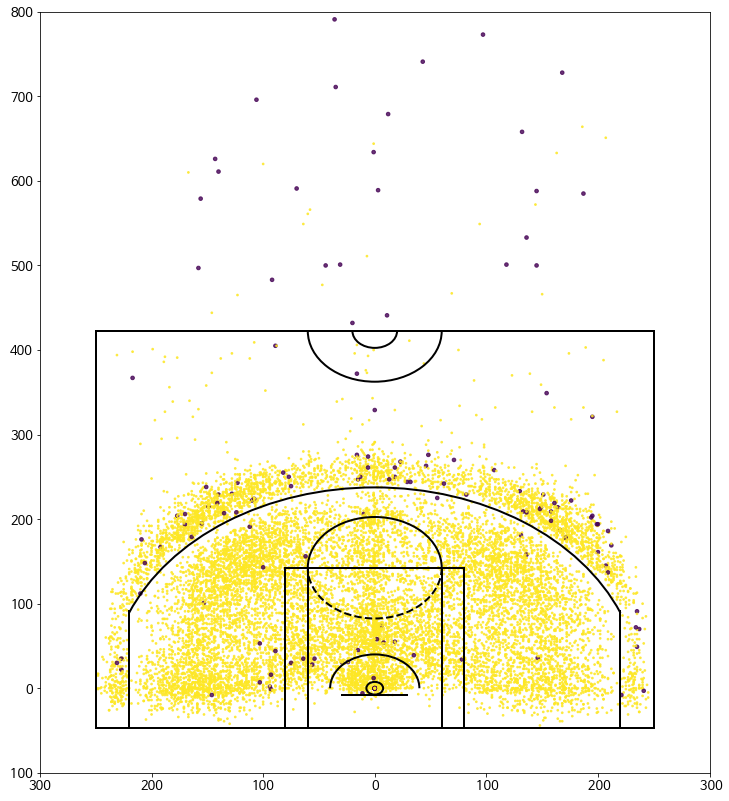

In [1073]:
plt.figure(figsize=(12,14))
plt.scatter(itrain['loc_x'], itrain['loc_y'], c = itrain['isolation'], s=-5*itrain['isolation']+8, alpha=0.8)

draw_court(outer_lines=True)
plt.ylim(-100,800) # actually there are many shots before half line which are meaningless
plt.xlim(300,-300)
plt.savefig("isol_yn.png")
plt.show()

In [1074]:
print(isolated.loc_x[0:2])
print(isolated.loc_x.iloc[2])
print(isolated.loc_y[0:1]==0)
print(isolated['buzzer_beater'][1:2])

386     0
531   -71
Name: loc_x, dtype: int64
0
386    True
Name: loc_y, dtype: bool
531    1
Name: buzzer_beater, dtype: category
Categories (2, int64): [0, 1]


In [1075]:
isolated.buzzer_beater.value_counts()

1    99
0    78
Name: buzzer_beater, dtype: int64

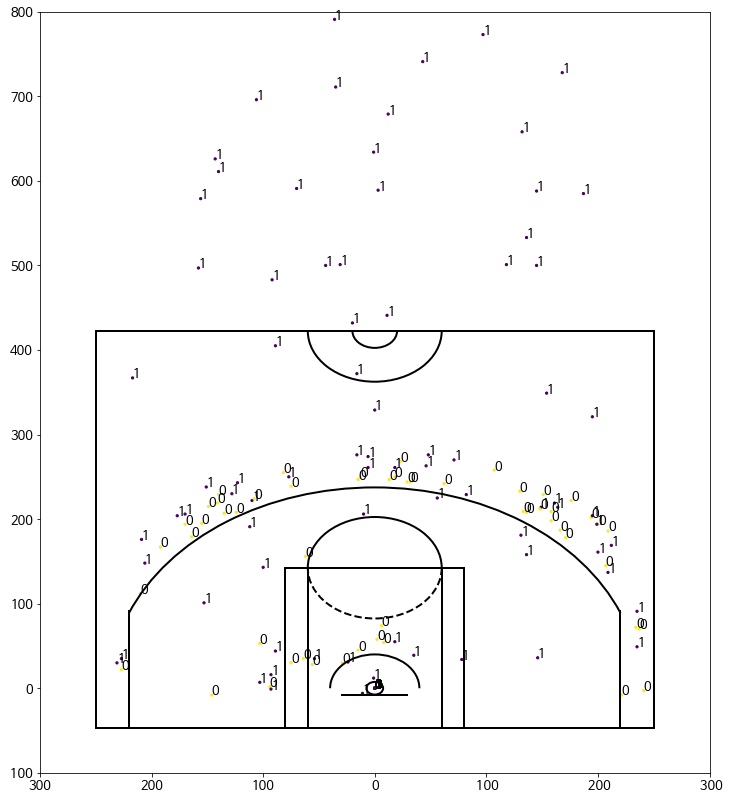

In [1076]:
plt.figure(figsize=(12,14))
plt.scatter(isolated['loc_x'], isolated['loc_y'], c = -isolated['buzzer_beater'], s=5)
for i in range(1, isolated.shape[0]):
    plt.text(x=isolated.loc_x.iloc[i], y=isolated.loc_y.iloc[i], s=isolated['buzzer_beater'].iloc[i])
draw_court(outer_lines=True)
plt.ylim(-100,800) # actually there are many shots before half line which are meaningless
plt.xlim(300,-300)
plt.savefig('buzzers.png')
plt.show()

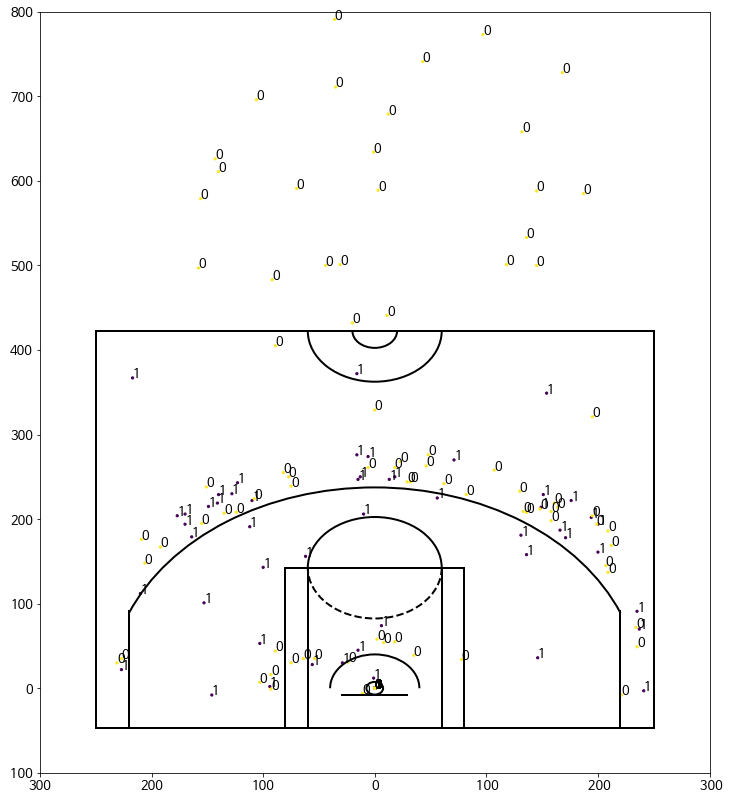

In [1077]:
plt.figure(figsize=(12,14))
plt.scatter(isolated['loc_x'], isolated['loc_y'], c = -isolated['quarter_5th'], s=5)
for i in range(1, isolated.shape[0]):
    plt.text(x=isolated.loc_x.iloc[i], y=isolated.loc_y.iloc[i], s=isolated['quarter_5th'].iloc[i])
draw_court(outer_lines=True)
plt.ylim(-100,800) # actually there are many shots before half line which are meaningless
plt.xlim(300,-300)
plt.savefig("quarter_5.png")
plt.show()

In [1026]:
heyday.season.value_counts()[seasons]

1996-97       NaN
1997-98       NaN
1998-99       NaN
1999-00    1312.0
2000-01    1575.0
2001-02    1708.0
2002-03    1852.0
2003-04    1371.0
2004-05       NaN
2005-06    1924.0
2006-07    1579.0
2007-08    1819.0
2008-09    1851.0
2009-10    1772.0
2010-11    1521.0
2011-12       NaN
2012-13       NaN
2013-14       NaN
2014-15       NaN
2015-16       NaN
Name: season, dtype: float64

In [1025]:
isolated.season.value_counts()[seasons]

1996-97     NaN
1997-98     NaN
1998-99     NaN
1999-00    15.0
2000-01    10.0
2001-02    13.0
2002-03    15.0
2003-04    22.0
2004-05     NaN
2005-06    25.0
2006-07    16.0
2007-08    18.0
2008-09    16.0
2009-10    21.0
2010-11     6.0
2011-12     NaN
2012-13     NaN
2013-14     NaN
2014-15     NaN
2015-16     NaN
Name: season, dtype: float64

In [1035]:
two_seas

season  shot_id  loc_x  loc_y playoffs  shot_distance hometeam  \
386    2000-01      387      0      0        0              0        1   
531    2000-01      532    -71    270        0             27        1   
603    2000-01      604      0      0        0              0        0   
1073   2000-01     1074    106    696        0             70        1   
1116   2000-01     1117      0      0        0              0        0   
1329   2000-01     1330     94      2        0              9        1   
1332   2000-01     1333      0      0        0              0        1   
15828  2010-11    17153    -18     55        0              5        1   
16066  2010-11    17391     15     45        0              4        1   
16506  2010-11    17831   -171    178        0             24        1   
16520  2010-11    17845   -133    209        0             24        1   
16658  2010-11    17983   -209    186        0             27        0   
18058  2000-01    26325      0      0        1              0        0   
18204  2000-01    26471      0      0        1              0        1   
18205  2000-01    26472    146     -8        1             14        1   
21444  2010-11    29711    206    148        1             25        0   

            shot_class buzzer_beater  shot_zone_basic quarter_5th  \
386           Tip Shot             1  Restricted Area           0   
531          Jump Shot             1           Point3           1   
603        Finger Roll             0  Restricted Area           1   
1073         Jump Shot             1        Backcourt           0   
1116   Good Layup Shot             1  Restricted Area           1   
1329    Good Hook Shot             0      Middle Shot           1   
1332    Good Dunk Shot             0  Restricted Area           1   
15828        Bank Shot             1      Middle Shot           0   
16066  Good Layup Shot             0      Middle Shot           1   
16506        Jump Shot             0           Point3           1   
16520   Good Jump Shot             0           Point3           0   
16658   Good Jump Shot             0           Point3           0   
18058         Tip Shot             1  Restricted Area           0   
18204  Good Layup Shot             0  Restricted Area           1   
18205   Good Jump Shot             0      Middle Shot           1   
21444   Good Jump Shot             1           Point3           0   

       shot_made_flag  isolation  
386               1.0         -1  
531               0.0         -1  
603               1.0         -1  
1073              0.0         -1  
1116              1.0         -1  
1329              1.0         -1  
1332              1.0         -1  
15828             1.0         -1  
16066             1.0         -1  
16506             0.0         -1  
16520             0.0         -1  
16658             0.0         -1  
18058             0.0         -1  
18204             1.0         -1  
18205             1.0         -1  
21444             0.0         -1

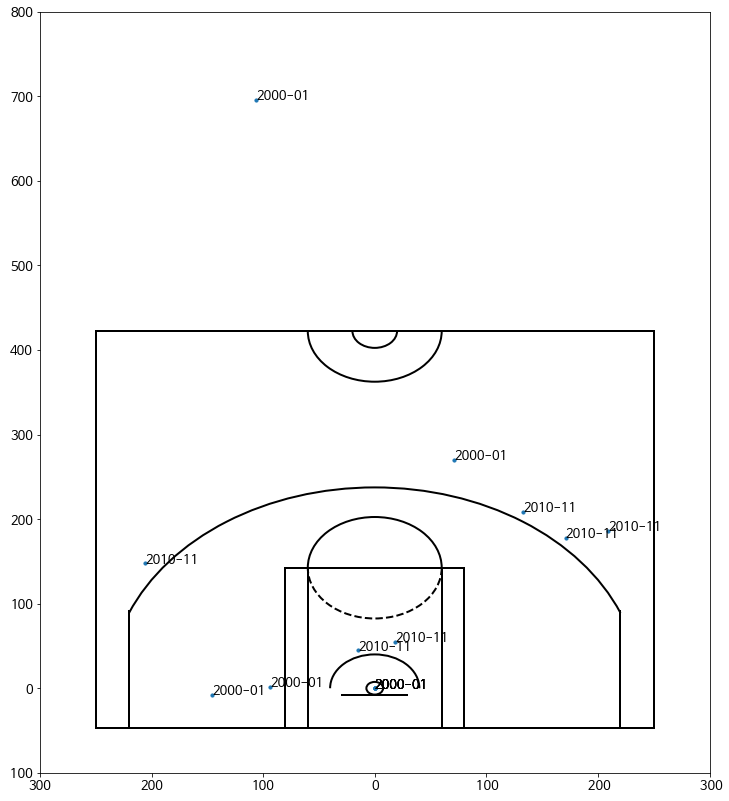

In [1078]:
two_seas = isolated[(isolated['season'] == '2000-01') | (isolated['season'] == '2010-11')]
plt.figure(figsize=(12,14))
plt.scatter(two_seas['loc_x'], two_seas['loc_y'], s=10)
for i in range(1, two_seas.shape[0]):
    plt.text(x=two_seas.loc_x.iloc[i], y=two_seas.loc_y.iloc[i], s=two_seas['season'].iloc[i])
draw_court(outer_lines=True)
plt.ylim(-100,800) # actually there are many shots before half line which are meaningless
plt.xlim(300,-300)
plt.savefig("two_season.png")
plt.show()

In [1045]:
train.columns[train.columns.str.startswith('shot_class')]

Index(['shot_class#Bank Shot', 'shot_class#Dunk Shot',
       'shot_class#Fadeaway Shot', 'shot_class#Finger Roll',
       'shot_class#Good Dunk Shot', 'shot_class#Good Hook Shot',
       'shot_class#Good Jump Shot', 'shot_class#Good Layup Shot',
       'shot_class#Hook Shot', 'shot_class#Jump Shot', 'shot_class#Layup Shot',
       'shot_class#Tip Shot'],
      dtype='object')

In [1048]:
pd.crosstab([itrain['isolation'], itrain['shot_zone_basic'], itrain['shot_made_flag'].astype(int)], 
            itrain['shot_class'], margins='index')

shot_class                                Bank Shot  Dunk Shot  Fadeaway Shot  \
isolation shot_zone_basic shot_made_flag                                        
-1        Backcourt       0                       0          0              0   
                          1                       0          0              0   
          Middle Shot     0                       0          0              0   
                          1                       3          0              0   
          Point3          0                       0          0              1   
                          1                       0          0              0   
          Restricted Area 0                       0          0              0   
                          1                       1          0              0   
1         Backcourt       0                       0          0              0   
          Middle Shot     0                      16          0             63   
                          1                      90          1            114   
          Point3          0                       0          0              0   
                          1                       0          0              1   
          Restricted Area 0                       1         36              0   
                          1                       0        130              0   
All                                             111        167            179   

shot_class                                Finger Roll  Good Dunk Shot  \
isolation shot_zone_basic shot_made_flag                                
-1        Backcourt       0                         0               0   
                          1                         0               0   
          Middle Shot     0                         1               0   
                          1                         3               0   
          Point3          0                         0               0   
                          1                         0               0   
          Restricted Area 0                         4               0   
                          1                         1               8   
1         Backcourt       0                         0               0   
          Middle Shot     0                         6               0   
                          1                         5               1   
          Point3          0                         0               0   
                          1                         0               0   
          Restricted Area 0                        13              21   
                          1                        55             589   
All                                                88             619   

shot_class                                Good Hook Shot  Good Jump Shot  \
isolation shot_zone_basic shot_made_flag                                   
-1        Backcourt       0                            0               2   
                          1                            0               0   
          Middle Shot     0                            0               5   
                          1                            2               4   
          Point3          0                            0              18   
                          1                            0              20   
          Restricted Area 0                            0               0   
                          1                            0               0   
1         Backcourt       0                            0               0   
          Middle Shot     0                            5             704   
                          1                           23            1548   
          Point3          0                            0               0   
                          1                            0              23   
          Restricted Area 0                            0               8   
          

In [1046]:
pd.crosstab([isolated['shot_zone_basic'], isolated['shot_made_flag'].astype(int)], 
            isolated['shot_class'], margins='index')

shot_class                      Bank Shot  Fadeaway Shot  Finger Roll  \
shot_zone_basic shot_made_flag                                          
Backcourt       0                       0              0            0   
                1                       0              0            0   
Middle Shot     0                       0              0            1   
                1                       3              0            3   
Point3          0                       0              1            0   
                1                       0              0            0   
Restricted Area 0                       0              0            4   
                1                       1              0            1   
All                                     4              1            9   

shot_class                      Good Dunk Shot  Good Hook Shot  \
shot_zone_basic shot_made_flag                                   
Backcourt       0                            0               0   
                1                            0               0   
Middle Shot     0                            0               0   
                1                            0               2   
Point3          0                            0               0   
                1                            0               0   
Restricted Area 0                            0               0   
                1                            8               0   
All                                          8               2   

shot_class                      Good Jump Shot  Good Layup Shot  Hook Shot  \
shot_zone_basic shot_made_flag                                               
Backcourt       0                            2                0          0   
                1                            0                0          0   
Middle Shot     0                            5                1          1   
                1                            4                1          0   
Point3          0                           18                0          0   
                1                           20                0          0   
Restricted Area 0                            0                5          0   
                1                            0                8          0   
All                                         49               15          1   

shot_class                      Jump Shot  Layup Shot  Tip Shot  All  
shot_zone_basic shot_made_flag                                        
Backcourt       0                      22           0         0   24  
                1                       1           0         0    1  
Middle Shot     0                       1           0         0    9  
                1                       6           0         0   19  
Point3          0                      18           0         0   37  
                1                      19           0         0   39  
Restricted Area 0                       1          10         4   24  
                1                       0           3         3   24  
All                                    68          13         7  177

In [1021]:
pd.crosstab([isolated['buzzer_beater'], isolated['quarter_5th'], isolated['shot_made_flag'].astype(int)], 
            isolated['shot_class'], margins='index')

shot_class                                Bank Shot  Fadeaway Shot  \
buzzer_beater quarter_5th shot_made_flag                             
0             0           0                       0              0   
                          1                       0              0   
              1           0                       0              0   
                          1                       0              0   
1             0           0                       0              1   
                          1                       4              0   
              1           0                       0              0   
                          1                       0              0   
All                                               4              1   

shot_class                                Finger Roll  Good Dunk Shot  \
buzzer_beater quarter_5th shot_made_flag                                
0             0           0                         4               0   
                          1                         3               0   
              1           0                         1               0   
                          1                         1               6   
1             0           0                         0               0   
                          1                         0               1   
              1           0                         0               0   
                          1                         0               1   
All                                                 9               8   

shot_class                                Good Hook Shot  Good Jump Shot  \
buzzer_beater quarter_5th shot_made_flag                                   
0             0           0                            0               9   
                          1                            0              13   
              1           0                            0               0   
                          1                            2               6   
1             0           0                            0              14   
                          1                            0               4   
              1           0                            0               2   
                          1                            0               1   
All                                                    2              49   

shot_class                                Good Layup Shot  Hook Shot  \
buzzer_beater quarter_5th shot_made_flag                               
0             0           0                             0          0   
                          1                             0          0   
              1           0                             3          0   
                          1                             7          0   
1             0           0                             2          1   
                          1                             0          0   
              1           0                             1          0   
                          1                             2          0   
All                                                    15          1   

shot_class                                Jump Shot  Layup Shot  Tip Shot  All  
buzzer_beater quarter_5th shot_made_flag                                        
0             0           0                       0           0         0   13  
                          1                       0           0         0   16  
              1           0                       9           5         1   19  
                          1                       8           0         0   30  
1             0           0                      22           4         3   47  
                          1                       9           2         2   22  
              1           0                      11           1         0   15  
                          1                       9           1   

In [1017]:
pd.crosstab(isolated['shot_made_flag'], [isolated['buzzer_beater'], isolated['playoffs']])

buzzer_beater    0       1    
playoffs         0   1   0   1
shot_made_flag                
0.0             18  14  32  30
1.0             24  22  18  19

In [1002]:
i_exception = isolated[isolated['quarter_5th'] | isolated['buzzer_beater'] == 0]
i_exception.head()

season  shot_id  loc_x  loc_y playoffs  shot_distance hometeam  \
2868  2001-02     2869    -23    268        0             26        1   
4283  2002-03     4284   -130    233        0             26        1   
4807  2002-03     4808   -158    209        0             26        1   
8052  2005-06     9377   -107    258        0             27        1   
9452  2006-07    10777   -207    145        0             25        0   

          shot_class buzzer_beater shot_zone_basic quarter_5th  \
2868  Good Jump Shot             0          Point3           0   
4283  Good Jump Shot             0          Point3           0   
4807  Good Jump Shot             0          Point3           0   
8052  Good Jump Shot             0          Point3           0   
9452  Good Jump Shot             0          Point3           0   

      shot_made_flag  isolation  
2868             0.0         -1  
4283             1.0         -1  
4807             1.0         -1  
8052             1.0         -1  
9452             0.0         -1

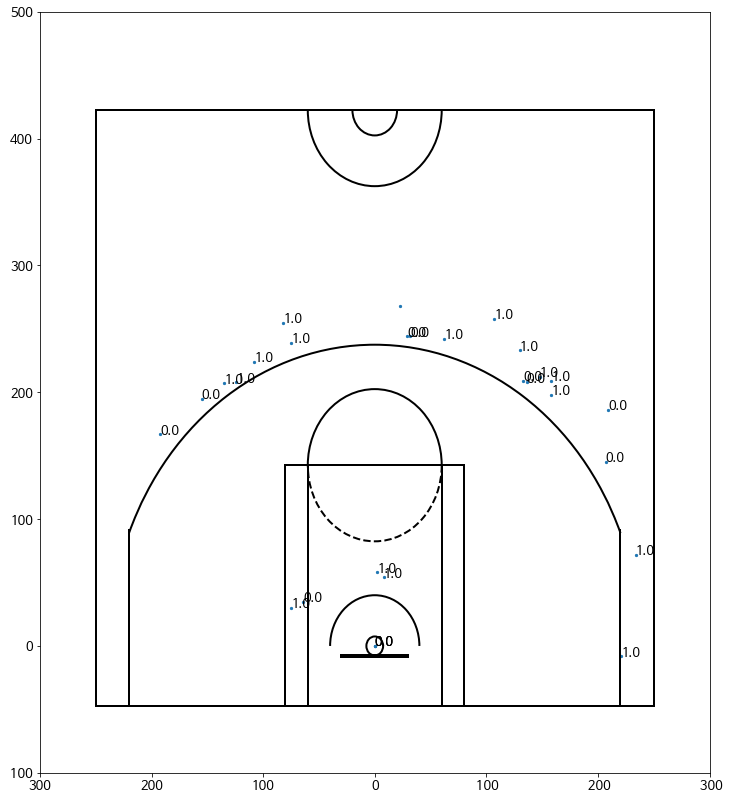

In [1012]:
plt.figure(figsize=(12,14))
plt.scatter(i_exception['loc_x'], i_exception['loc_y'], s=5)
for i in range(1, i_exception.shape[0]):
    plt.text(x=i_exception.loc_x.iloc[i], y=i_exception.loc_y.iloc[i], s=i_exception['shot_made_flag'].iloc[i])
draw_court(outer_lines=True)
plt.ylim(-100,500) # actually there are many shots before half line which are meaningless
plt.xlim(300,-300)
#plt.savefig('buzzers.png')
plt.show()

In [1084]:
print(heyX.shape)
print(heyZ.shape)

(18284, 21)
(17387, 21)


In [1080]:
heyZ = heyX[(heyX['quarter_5th']==0)&(heyX['buzzer_beater']==0)]

In [1085]:
isol_fit_bq = isol.fit(heyZ)

In [1086]:
isol_pred_bq = isol_fit_bq.predict(heyZ)

In [1095]:
sum(isol_pred_bq==-1) # 겨우 4개 빠졌다

173

In [1090]:
itrain_bq = heyday[(heyX['quarter_5th']==0)&(heyX['buzzer_beater']==0)].copy()

In [1091]:
itrain_bq["isolation"] = isol_pred_bq

In [1096]:
isolated_bq = itrain_bq[itrain_bq["isolation"] == -1]
isolated_bq.head()

season  shot_id  loc_x  loc_y playoffs  shot_distance hometeam  \
63    2000-01       64     56     21        0              5        1   
1606  2001-02     1607      1     40        0              4        1   
2001  2001-02     2002      0     51        0              5        1   
2238  2001-02     2239     85      0        0              8        1   
2765  2001-02     2766     -4     57        0              5        1   

           shot_class buzzer_beater shot_zone_basic quarter_5th  \
63    Good Layup Shot             0     Middle Shot           0   
1606  Good Layup Shot             0     Middle Shot           0   
2001      Finger Roll             0     Middle Shot           0   
2238        Hook Shot             0     Middle Shot           0   
2765      Finger Roll             0     Middle Shot           0   

      shot_made_flag  isolation  
63               0.0         -1  
1606             1.0         -1  
2001             1.0         -1  
2238             0.0         -1  
2765             1.0         -1

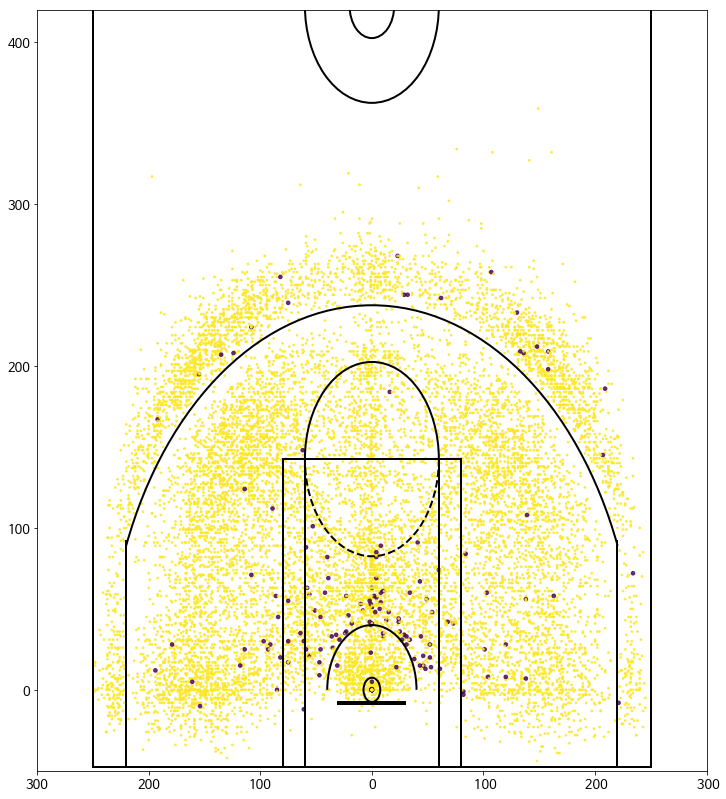

In [1120]:
plt.figure(figsize=(12,14))
plt.scatter(itrain_bq['loc_x'], itrain_bq['loc_y'], c = itrain_bq['isolation'], s=-5*itrain_bq['isolation']+8, alpha=0.8)

draw_court(outer_lines=True)
plt.ylim(-50,420) # actually there are many shots before half line which are meaningless
plt.xlim(300,-300)
plt.savefig("isol_yn_bq.png")
plt.show()

In [1107]:
pd.DataFrame([heyday.season.value_counts()[seasons],isolated_bq.season.value_counts()[seasons]]).iloc[:, 3:15]

1999-00  2000-01  2001-02  2002-03  2003-04  2004-05  2005-06  \
season   1312.0   1575.0   1708.0   1852.0   1371.0      NaN   1924.0   
season     14.0     13.0     17.0     12.0     14.0      NaN      6.0   

        2006-07  2007-08  2008-09  2009-10  2010-11  
season   1579.0   1819.0   1851.0   1772.0   1521.0  
season      9.0     19.0     23.0     20.0     26.0

In [1109]:
train.columns

Index(['playoffs', 'hometeam', 'buzzer_beater', 'quarter_5th',
       'shot_made_flag', 'shot_class#Bank Shot', 'shot_class#Dunk Shot',
       'shot_class#Fadeaway Shot', 'shot_class#Finger Roll',
       'shot_class#Good Dunk Shot', 'shot_class#Good Hook Shot',
       'shot_class#Good Jump Shot', 'shot_class#Good Layup Shot',
       'shot_class#Hook Shot', 'shot_class#Jump Shot', 'shot_class#Layup Shot',
       'shot_class#Tip Shot', 'shot_zone_basic#Backcourt',
       'shot_zone_basic#Middle Shot', 'shot_zone_basic#Point3',
       'shot_zone_basic#Restricted Area', 'isolation'],
      dtype='object')

In [1108]:
pd.crosstab([itrain_bq['isolation'], itrain_bq['shot_zone_basic'], itrain_bq['shot_made_flag'].astype(int)], 
            itrain_bq['shot_class'], margins='index')

shot_class                                Bank Shot  Dunk Shot  Fadeaway Shot  \
isolation shot_zone_basic shot_made_flag                                        
-1        Middle Shot     0                      16          0              6   
                          1                       8          0             12   
          Point3          0                       0          0              0   
                          1                       0          0              0   
          Restricted Area 0                       0          6              0   
                          1                       0          0              0   
1         Middle Shot     0                       0          0             56   
                          1                      80          1             99   
          Point3          0                       0          0              0   
                          1                       0          0              1   
          Restricted Area 0                       1         30              0   
                          1                       0        128              0   
All                                             105        165            174   

shot_class                                Finger Roll  Good Dunk Shot  \
isolation shot_zone_basic shot_made_flag                                
-1        Middle Shot     0                         7               0   
                          1                         7               0   
          Point3          0                         0               0   
                          1                         0               0   
          Restricted Area 0                         3               4   
                          1                        11               0   
1         Middle Shot     0                         0               0   
                          1                         1               1   
          Point3          0                         0               0   
                          1                         0               0   
          Restricted Area 0                        13              17   
                          1                        43             577   
All                                                85             599   

shot_class                                Good Hook Shot  Good Jump Shot  \
isolation shot_zone_basic shot_made_flag                                   
-1        Middle Shot     0                            0               0   
                          1                            4               0   
          Point3          0                            0               9   
                          1                            0              13   
          Restricted Area 0                            0               0   
                          1                            0               0   
1         Middle Shot     0                            5             684   
                          1                           19            1488   
          Point3          0                            0               0   
                          1                            0              23   
          Restricted Area 0                            0               7   
                          1                            4              32   
All                                                   32            2256   

shot_class                                Good Layup Shot  Hook Shot  \
isolation shot_zone_basic shot_made_flag                               
-1        Middle Shot     0                            12         10   
                          1                            11         14   
          Point3          0                             0          0   
                          1                             0          0   
          Restricted Area 0                             0          3   
                          1                

In [1111]:
pd.crosstab([itrain_bq['isolation'], itrain_bq['shot_zone_basic'], itrain_bq['shot_made_flag'].astype(int)], 
            [itrain_bq['playoffs'], itrain_bq['hometeam']], margins='index')

playoffs                                     0           1          All
hometeam                                     0     1     0     1       
isolation shot_zone_basic shot_made_flag                               
-1        Middle Shot     0                 17    21     6     7     51
                          1                  7    15    12    22     56
          Point3          0                  6     3     0     0      9
                          1                  0     6     6     1     13
          Restricted Area 0                  0     3     6    15     24
                          1                  0     0     8    12     20
1         Middle Shot     0               2456  2293   573   477   5799
                          1               1838  1727   418   358   4341
          Point3          0                831   768   198   172   1969
                          1                433   460   106    90   1089
          Restricted Area 0                615   655   106   136   1512
                          1               1024  1093   179   208   2504
All                                       7227  7044  1618  1498  17387

In [1116]:
pd.crosstab([isolated_bq['shot_zone_basic'], isolated_bq['shot_made_flag'].astype(int)], 
            isolated_bq['shot_class'], margins='index')

shot_class                      Bank Shot  Dunk Shot  Fadeaway Shot  \
shot_zone_basic shot_made_flag                                        
Middle Shot     0                      16          0              6   
                1                       8          0             12   
Point3          0                       0          0              0   
                1                       0          0              0   
Restricted Area 0                       0          6              0   
                1                       0          0              0   
All                                    24          6             18   

shot_class                      Finger Roll  Good Dunk Shot  Good Hook Shot  \
shot_zone_basic shot_made_flag                                                
Middle Shot     0                         7               0               0   
                1                         7               0               4   
Point3          0                         0               0               0   
                1                         0               0               0   
Restricted Area 0                         3               4               0   
                1                        11               0               0   
All                                      28               4               4   

shot_class                      Good Jump Shot  Good Layup Shot  Hook Shot  \
shot_zone_basic shot_made_flag                                               
Middle Shot     0                            0               12         10   
                1                            0               11         14   
Point3          0                            9                0          0   
                1                           13                0          0   
Restricted Area 0                            0                0          3   
                1                            0                0          1   
All                                         22               23         28   

shot_class                      Tip Shot  All  
shot_zone_basic shot_made_flag                 
Middle Shot     0                      0   51  
                1                      0   56  
Point3          0                      0    9  
                1                      0   13  
Restricted Area 0                      8   24  
                1                      8   20  
All                                   16  173

In [1115]:
pd.crosstab(isolated_bq['shot_made_flag'].astype(int), 
            isolated_bq['shot_class'], margins='index')

shot_class      Bank Shot  Dunk Shot  Fadeaway Shot  Finger Roll  \
shot_made_flag                                                     
0                      16          6              6           10   
1                       8          0             12           18   
All                    24          6             18           28   

shot_class      Good Dunk Shot  Good Hook Shot  Good Jump Shot  \
shot_made_flag                                                   
0                            4               0               9   
1                            0               4              13   
All                          4               4              22   

shot_class      Good Layup Shot  Hook Shot  Tip Shot  All  
shot_made_flag                                             
0                            12         13         8   84  
1                            11         15         8   89  
All                          23         28        16  173

In [1113]:
pd.crosstab(isolated_bq['shot_made_flag'], isolated_bq['playoffs'])

playoffs         0   1
shot_made_flag        
0.0             50  34
1.0             28  61